In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qadence import *

import torch
from torch.autograd import grad

### Hyperparams

In [2]:
RANDOM_STATES = [717305734, 1578134139, 1857775320, 329580779, 92438078, 2080648082,
1804607396, 686568447, 1413643310, 392023464, 2059869379, 1148461192,
79601690, 707693586, 782043329, 1444461484, 1627556802, 1319074224,
119362002, 943916590, 506150419, 1844084285, 925356441, 1134839023,
910058856, 1440406125, 1513362805, 1272256016, 1882501760, 1692578607,
1538138854, 1744359993, 673580467, 47129890, 1053044469, 126340966,
2002216988, 1214846897, 551364282, 399490524, 1569758850, 1377520610,
58809029, 2139517420, 1639666245, 651893777, 283141215, 1351164964,
1285827380, 1651518512] #np.random.randint(0, 2**31-1, size=50) 
print("Seeds: ", RANDOM_STATES)
LEARNING_RATES = [0.1]
K= [0.1] 
LAMBDA = [8]

Seeds:  [717305734, 1578134139, 1857775320, 329580779, 92438078, 2080648082, 1804607396, 686568447, 1413643310, 392023464, 2059869379, 1148461192, 79601690, 707693586, 782043329, 1444461484, 1627556802, 1319074224, 119362002, 943916590, 506150419, 1844084285, 925356441, 1134839023, 910058856, 1440406125, 1513362805, 1272256016, 1882501760, 1692578607, 1538138854, 1744359993, 673580467, 47129890, 1053044469, 126340966, 2002216988, 1214846897, 551364282, 399490524, 1569758850, 1377520610, 58809029, 2139517420, 1639666245, 651893777, 283141215, 1351164964, 1285827380, 1651518512]


### Inputs

In [3]:
def generate_chebyshev_grid(n, a, b, requires_grad=True):
    k = torch.arange(n)
    chebyshev_nodes = torch.cos(torch.pi * (2*k + 1) / (2*n))  #standard Chebyshev nodes in [-1,1]
    scaled_nodes = ((chebyshev_nodes + 1) / 2) * (b - a) + a  #rescale to [a, b]
    
    return scaled_nodes.requires_grad_(requires_grad=requires_grad)

# X train
N_POINTS = 20
a = 0.0
b = 0.9
x = generate_chebyshev_grid(N_POINTS, a, b)
print(x.detach().numpy())
cp_fixed = torch.reshape(x, (N_POINTS,1))

# X test
sample_points = generate_chebyshev_grid(100, a, b, requires_grad=False).reshape(-1, 1)

[0.8986128  0.88756646 0.86574579 0.83368807 0.79218268 0.74225162
 0.68512435 0.62220754 0.55505041 0.48530659 0.41469341 0.34494959
 0.27779246 0.21487565 0.15774838 0.10781732 0.06631193 0.03425421
 0.01243354 0.0013872 ]


In [14]:
print(sample_points)

tensor([[8.9994e-01],
        [8.9950e-01],
        [8.9861e-01],
        [8.9728e-01],
        [8.9551e-01],
        [8.9330e-01],
        [8.9065e-01],
        [8.8757e-01],
        [8.8405e-01],
        [8.8011e-01],
        [8.7574e-01],
        [8.7095e-01],
        [8.6575e-01],
        [8.6013e-01],
        [8.5411e-01],
        [8.4769e-01],
        [8.4088e-01],
        [8.3369e-01],
        [8.2611e-01],
        [8.1817e-01],
        [8.0986e-01],
        [8.0119e-01],
        [7.9218e-01],
        [7.8283e-01],
        [7.7316e-01],
        [7.6316e-01],
        [7.5286e-01],
        [7.4225e-01],
        [7.3136e-01],
        [7.2019e-01],
        [7.0875e-01],
        [6.9706e-01],
        [6.8512e-01],
        [6.7296e-01],
        [6.6057e-01],
        [6.4797e-01],
        [6.3518e-01],
        [6.2221e-01],
        [6.0906e-01],
        [5.9576e-01],
        [5.8232e-01],
        [5.6874e-01],
        [5.5505e-01],
        [5.4125e-01],
        [5.2737e-01],
        [5

### Pseudo-Exhaustive search

Seed id:  0
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.47163765 0.77766449 0.32738463 0.67151975 0.06972196 0.63543333
 0.69077918 0.54673015 0.8867317  0.47078638 0.11989547 0.38815219
 0.88220691 0.59885932 0.80354937 0.06142231 0.82244488 0.6186896
 0.90992316 0.74462859 0.86710531 0.70336207 0.4147598  0.27444206
 0.57220044 0.74160704 0.00098673 0.4742618  0.13733622 0.38527417
 0.84911943 0.57598487 0.49486736 0.13981847 0.74136957 0.94918934
 0.77091867 0.32318135 0.6017892  0.62937086 0.52499096 0.46590843
 0.81048963 0.87933556 0.32267063 0.1893866  0.13420264 0.31089329
 0.63769231 0.34365099 0.59207301 0.22463116 0.82464105 0.83847864
 0.60149408 0.59642925 0.34786436 0.97180221 0.45140744 0.15613718
 0.33655146 0.91471318 0.70770095 0.49908603 0.94481145 0.56771022
 0.74588661 0.31450222 0.30575093 0.19007659 0.34906013 0.2596061
 0.82559848 0.73421    0.69338956 0.39229425 0.05381058 0.72465261
 0.75164373 0.60538886 0.71686337 0.47379311 0.96043364 0.5259852

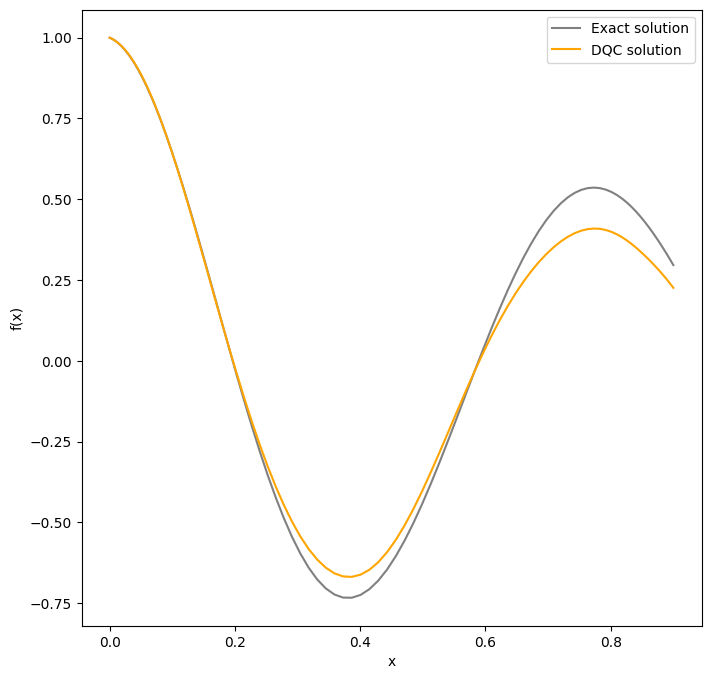

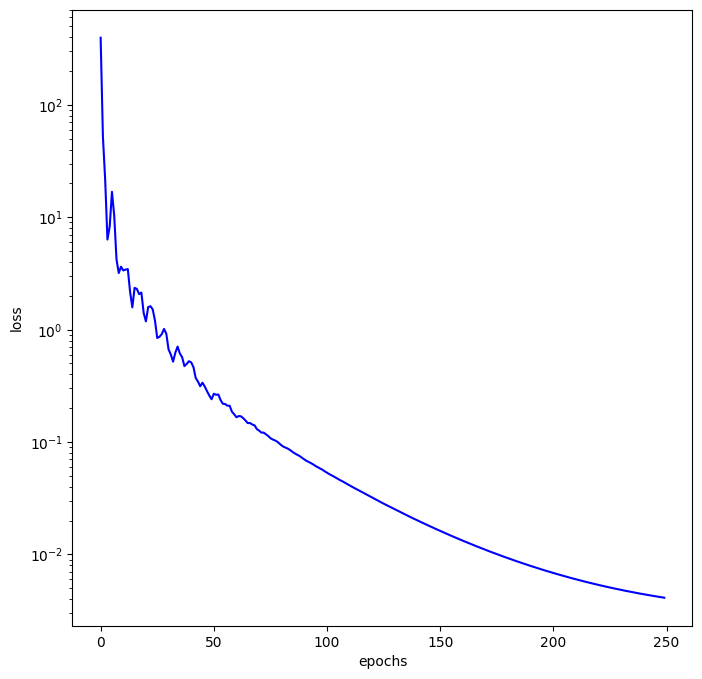

Seed id:  1
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.93526835 0.51613875 0.93647593 0.80409691 0.2807147  0.95198413
 0.88117934 0.42586596 0.82568511 0.95578194 0.48811755 0.80938648
 0.38981725 0.97299126 0.28127853 0.412327   0.44304796 0.10084513
 0.59584886 0.66523717 0.49459753 0.86181155 0.16237623 0.4823259
 0.94606919 0.02895589 0.02644914 0.45164574 0.07076762 0.9189895
 0.14597372 0.0598991  0.30258243 0.56311177 0.56430051 0.72769949
 0.25225272 0.91865389 0.9345626  0.41982096 0.30582874 0.95631165
 0.01108141 0.25689694 0.69001906 0.0485617  0.96804344 0.61332071
 0.10919009 0.56558246 0.2839667  0.31777877 0.79657935 0.11356781
 0.07711965 0.57646562 0.10848579 0.0709515  0.18988935 0.1096177
 0.5209842  0.40792528 0.64751118 0.86017701 0.95771257 0.95764679
 0.01871337 0.62078696 0.74595248 0.52061755 0.59851491 0.21384902
 0.03413883 0.95679398 0.62156095 0.9625691  0.07440143 0.28971426
 0.9537518  0.91211901 0.72665826 0.56387611 0.35522674 0.39358676

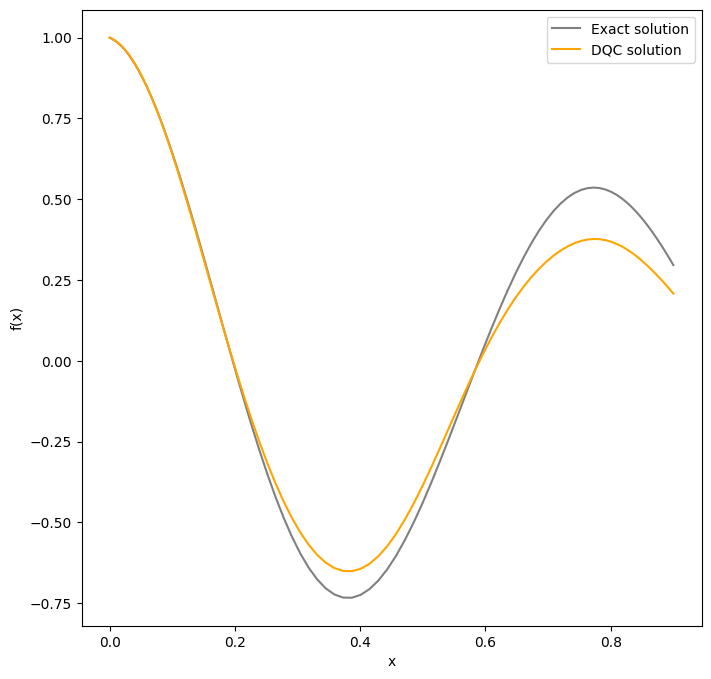

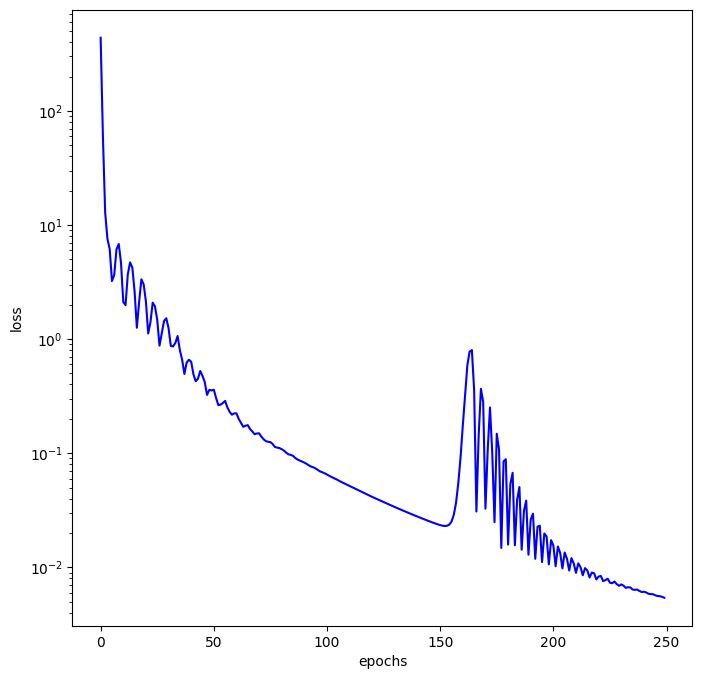

Seed id:  2
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [3.83738731e-01 1.40285091e-01 9.07095921e-01 9.81760035e-01
 4.84813484e-01 4.45451741e-01 8.88030944e-02 8.09748687e-01
 2.70547333e-01 6.24552283e-01 5.17235112e-01 3.17726933e-01
 8.73018779e-01 4.25492702e-01 6.82761870e-01 2.17579984e-01
 3.47476200e-01 5.37024352e-01 9.28191751e-01 3.45990758e-01
 6.08798665e-01 5.42104674e-01 9.39779454e-02 1.54451412e-01
 4.84262294e-04 9.88497912e-01 8.32348831e-01 9.13511824e-01
 7.22683930e-01 3.04237636e-02 2.48178889e-01 2.23375208e-01
 5.58315207e-01 8.95625599e-01 7.01750239e-01 1.36337190e-01
 7.97520785e-01 8.00966309e-01 7.23320020e-01 9.35637077e-01
 2.66603480e-01 2.10395163e-01 6.30329429e-01 1.32158724e-01
 3.31493650e-01 1.68935981e-01 6.74773600e-01 1.83928813e-02
 3.80669795e-01 3.58498450e-01 1.58245873e-01 2.06773864e-02
 3.96977103e-01 4.85367411e-01 2.77733467e-02 4.67824519e-01
 7.22077656e-01 7.36992196e-01 1.29991546e-02 1.20184165e-02
 3.49855674e-02 6.8

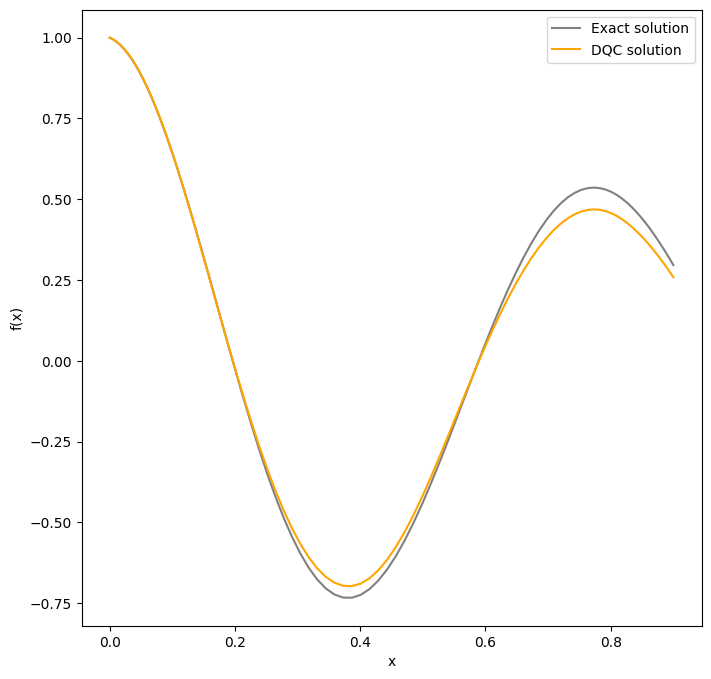

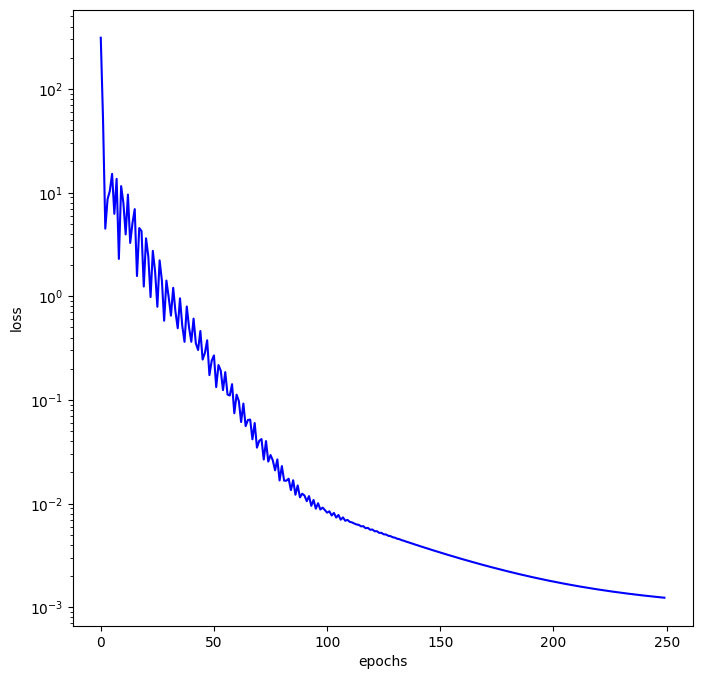

Seed id:  3
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.67766263 0.64112325 0.37039792 0.55356525 0.85061074 0.57592126
 0.38129294 0.44593831 0.85009662 0.32304875 0.19916769 0.44156463
 0.86079681 0.70685401 0.45065656 0.27051979 0.68470666 0.6172282
 0.47264594 0.56926346 0.62303358 0.17355395 0.93059113 0.07846087
 0.90685107 0.95416611 0.66079205 0.69745614 0.86059054 0.71663204
 0.77000201 0.19471386 0.0209621  0.69626848 0.95378867 0.86067858
 0.88722732 0.72686836 0.01570315 0.59365767 0.98276009 0.03474678
 0.11929444 0.17050141 0.01359447 0.51352727 0.31589896 0.1122109
 0.46822021 0.72898267 0.87459572 0.92536791 0.40292919 0.75540894
 0.9818177  0.57360147 0.86800018 0.80582715 0.1139985  0.90718693
 0.87442215 0.13514846 0.56611349 0.61885361 0.7160452  0.81597749
 0.76676517 0.07315358 0.02930359 0.70297413 0.41127137 0.84700982
 0.06916185 0.05250827 0.40812402 0.25545424 0.99294796 0.18826201
 0.50551305 0.07276254 0.43717535 0.24244662 0.04369337 0.1240052

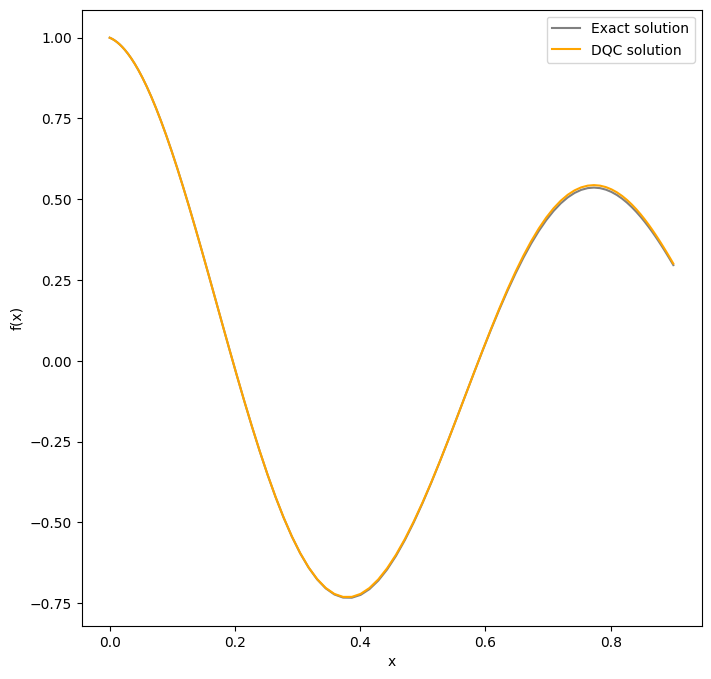

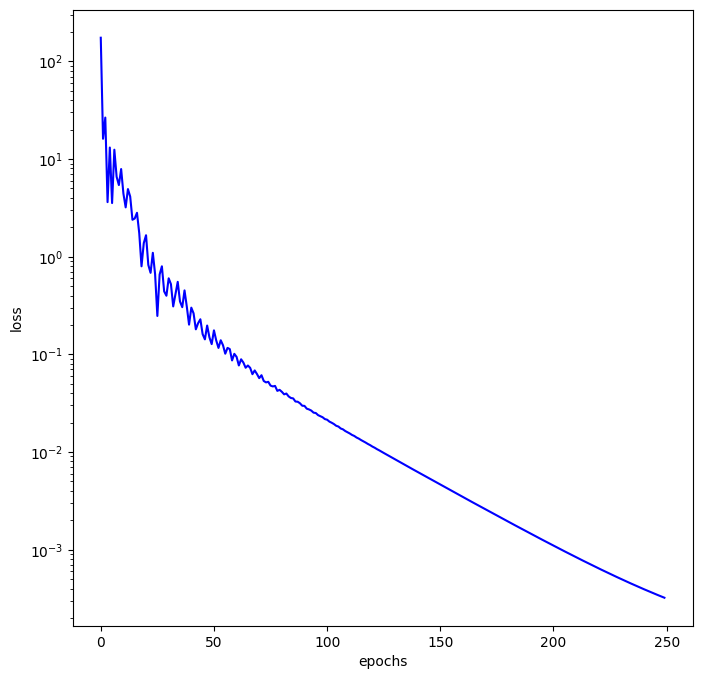

Seed id:  4
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.30193744 0.29616976 0.06471338 0.29747719 0.29903312 0.58959849
 0.2701523  0.13983022 0.93353043 0.0108036  0.07876334 0.54140191
 0.09325813 0.72120604 0.9455033  0.43190524 0.35345736 0.50634577
 0.36931048 0.85555158 0.87045421 0.12462251 0.77190324 0.68944506
 0.02638072 0.90360443 0.85218543 0.24799281 0.58200016 0.58171912
 0.28546516 0.03495978 0.67061192 0.95089398 0.71012897 0.23841496
 0.67391685 0.18051653 0.87282633 0.416361   0.55851026 0.552193
 0.72856105 0.10590518 0.94739059 0.16218668 0.73120166 0.60445341
 0.19693088 0.6335057  0.16187851 0.20806124 0.89918341 0.89809336
 0.44234663 0.9488307  0.09250326 0.18552476 0.10821659 0.01151686
 0.46578403 0.49270859 0.78120937 0.9215095  0.30219196 0.60606493
 0.94163396 0.03191981 0.5664698  0.45729283 0.04580854 0.29639014
 0.32774207 0.75667573 0.87230406 0.54231073 0.82722258 0.83208272
 0.39999623 0.80740626 0.39893684 0.34858249 0.0729721  0.2760047

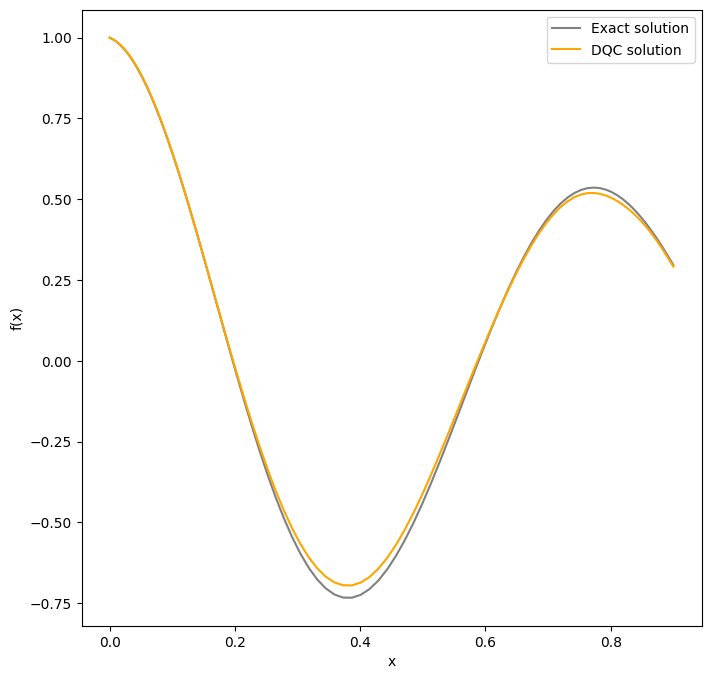

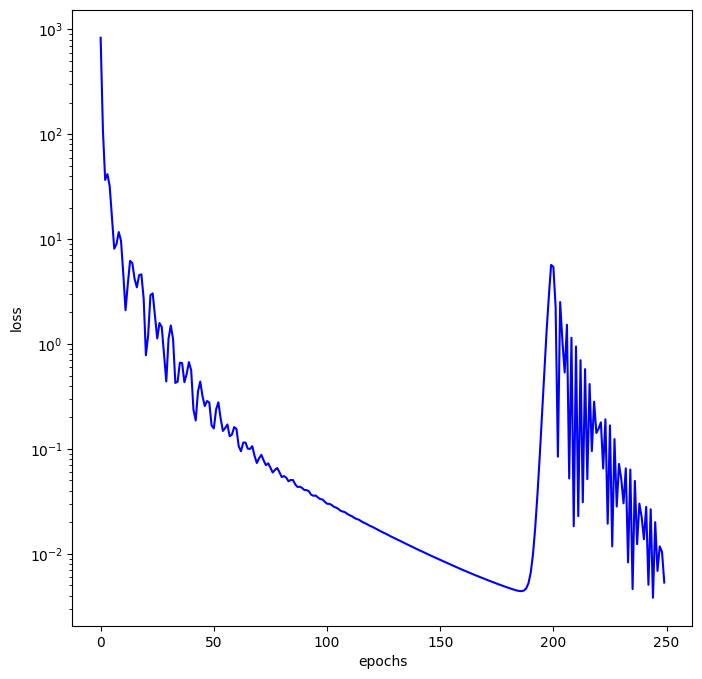

Seed id:  5
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.56705406 0.80442002 0.83893228 0.3365894  0.56816675 0.56247745
 0.48955797 0.93660168 0.0190498  0.66271652 0.63160267 0.30472913
 0.79288061 0.11070501 0.95167417 0.7004157  0.15000436 0.61445052
 0.06438569 0.04852803 0.82140648 0.30640592 0.53180848 0.50998628
 0.77835192 0.81038831 0.46301323 0.52347556 0.51810821 0.00742173
 0.64727955 0.01229208 0.78786416 0.37339625 0.67807382 0.53982421
 0.42519481 0.87126164 0.51106722 0.14339275 0.43721038 0.09854543
 0.46794122 0.21047962 0.76102358 0.66803087 0.54869422 0.22557494
 0.41320272 0.3191363  0.51387908 0.58143536 0.68393364 0.2432917
 0.75814194 0.97926797 0.09195792 0.55226879 0.70886674 0.99523691
 0.02912597 0.07568772 0.782091   0.19689045 0.34838328 0.79573466
 0.52436503 0.70743053 0.20636826 0.73295056 0.00243416 0.01092784
 0.13050772 0.81301949 0.43458357 0.80846526 0.4933097  0.16772035
 0.48017212 0.8237994  0.13830831 0.23225837 0.02107969 0.830273

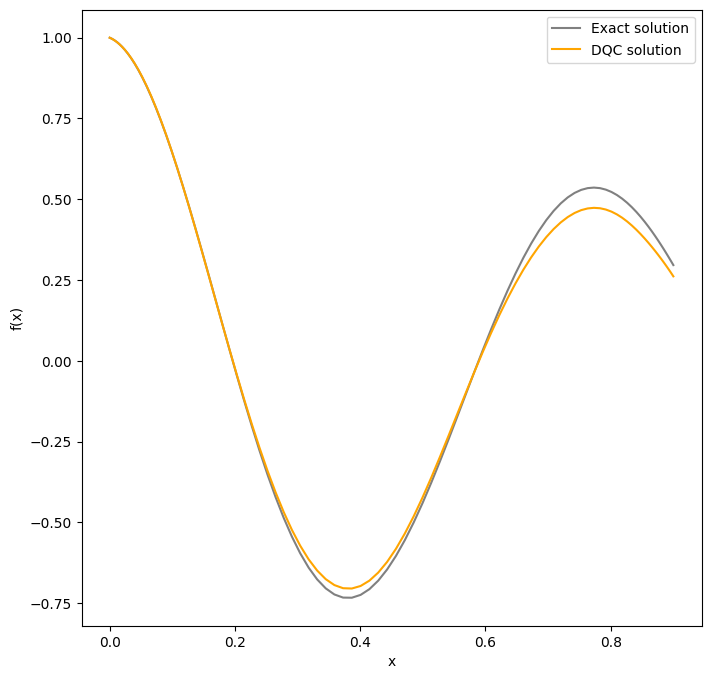

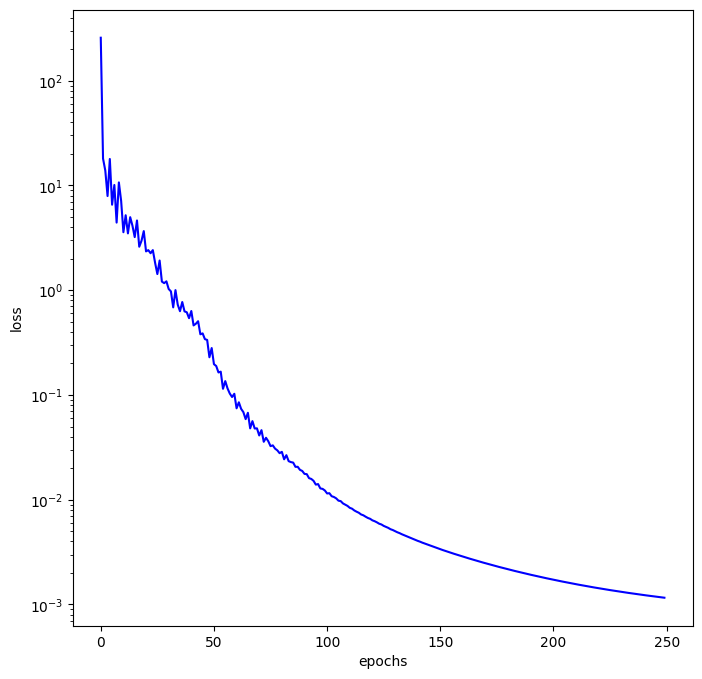

Seed id:  6
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.35716891 0.69855375 0.02875643 0.96832292 0.30784168 0.92713857
 0.51849677 0.8343253  0.90292746 0.84568703 0.1548778  0.94690083
 0.52816235 0.7349612  0.03655592 0.77781769 0.48837851 0.81495411
 0.58600636 0.24058848 0.88646667 0.29218027 0.53168344 0.26365707
 0.7823846  0.12051956 0.75441069 0.41129854 0.11624093 0.18969191
 0.70841162 0.77283542 0.18304612 0.68493856 0.63763245 0.63289039
 0.26732986 0.18214344 0.85343381 0.10350946 0.9268904  0.68103376
 0.71495711 0.82662203 0.06188078 0.971949   0.02920637 0.64885385
 0.03405676 0.9519967  0.64835598 0.51565908 0.90737417 0.66262077
 0.504857   0.91492827 0.21928644 0.57326247 0.33263723 0.16628195
 0.63827331 0.73036888 0.66468279 0.14506757 0.03214251 0.58277163
 0.69552845 0.49426866 0.44333423 0.32638262 0.84547278 0.89828075
 0.75202273 0.37351342 0.65280788 0.5848458  0.24630238 0.08989095
 0.37906516 0.58955657 0.36437151 0.75117423 0.88014536 0.14296

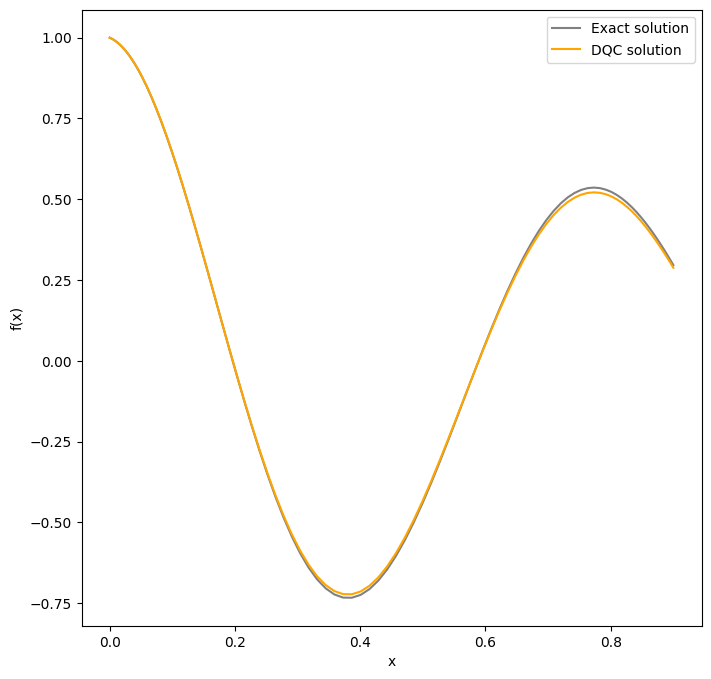

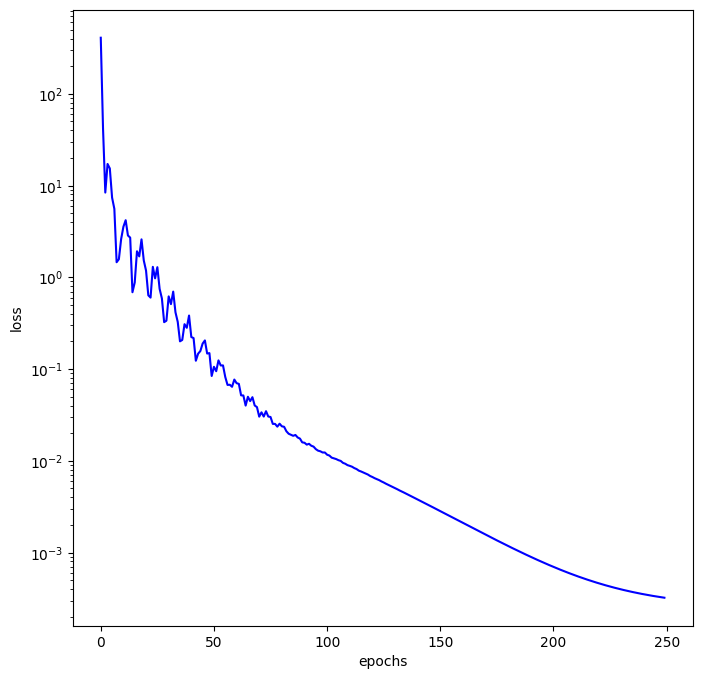

Seed id:  7
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.56771134 0.24998524 0.69322392 0.40367898 0.818519   0.61830234
 0.25934109 0.88046638 0.12341474 0.19765954 0.55931737 0.13259827
 0.61831878 0.53314531 0.01413813 0.47584248 0.10730035 0.65061064
 0.15027778 0.42744325 0.44649545 0.09088235 0.68402096 0.97945702
 0.97253172 0.27228683 0.25800914 0.11122569 0.44089448 0.52784226
 0.10123016 0.00277864 0.16017122 0.60862739 0.80866353 0.86429803
 0.4422308  0.48868587 0.55576569 0.32488027 0.07541101 0.98205458
 0.69638803 0.98861882 0.71374129 0.25051526 0.33487963 0.22778143
 0.93612021 0.46419022 0.20572807 0.72227393 0.36097866 0.21702021
 0.73143823 0.85910418 0.78212462 0.31476327 0.46876146 0.663548
 0.30760647 0.66772438 0.28879306 0.33797847 0.485169   0.32414032
 0.03806328 0.30138513 0.7494277  0.5395074  0.65415867 0.49994623
 0.62506035 0.90108642 0.06162222 0.45183676 0.04206193 0.75491076
 0.1267621  0.43035181 0.64037711 0.04099191 0.94213252 0.5137395

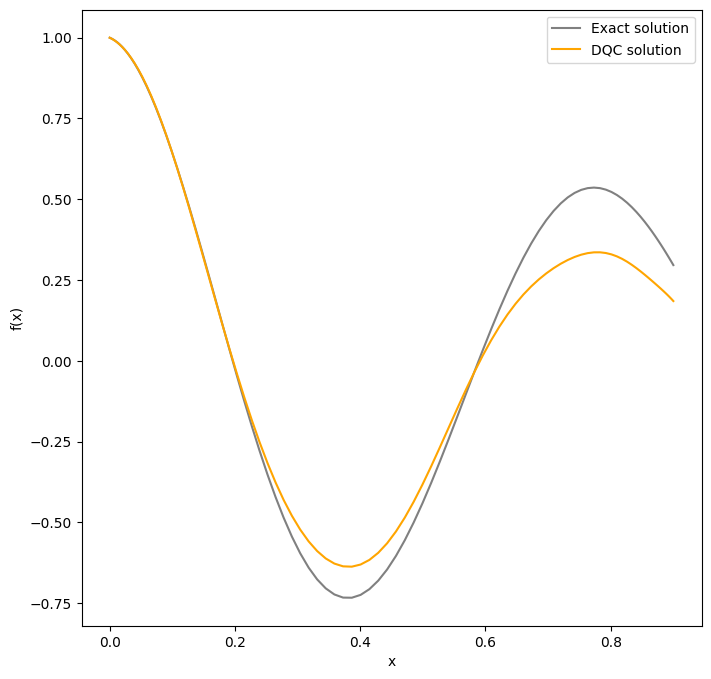

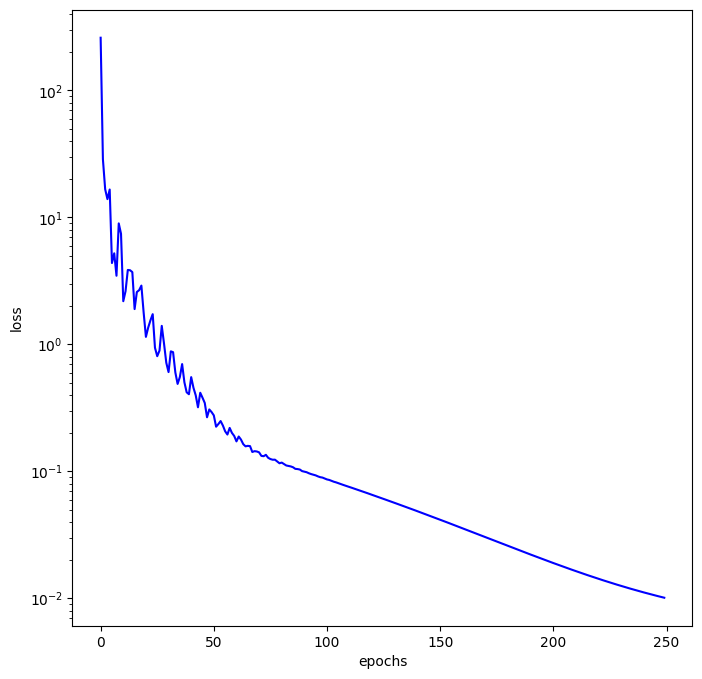

Seed id:  8
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.50161553 0.00566202 0.89627055 0.06327102 0.49968637 0.90927005
 0.73540474 0.39307447 0.41560955 0.18729634 0.85441593 0.90029513
 0.38394337 0.9261374  0.09092944 0.11763234 0.40133421 0.41703667
 0.0127179  0.42525531 0.28204033 0.19597582 0.86666026 0.5078717
 0.29454729 0.43342864 0.7864755  0.16770749 0.65014433 0.89718134
 0.13870416 0.44562673 0.98767255 0.28502972 0.80197844 0.39784334
 0.88364102 0.38879822 0.72033789 0.09323859 0.14987208 0.03508548
 0.95262964 0.64007289 0.74258622 0.61654506 0.07121143 0.35366651
 0.85918451 0.8767715  0.99990956 0.02767208 0.28334678 0.60390436
 0.57974182 0.96962763 0.06337309 0.96395446 0.61422255 0.23974757
 0.90547488 0.47301903 0.3747736  0.90819962 0.79567622 0.6836722
 0.12076224 0.07759188 0.65293411 0.97533453 0.21887119 0.71493953
 0.20117658 0.09663036 0.00957796 0.05160537 0.1487304  0.2534462
 0.20506714 0.81257166 0.50995506 0.26196096 0.39892897 0.45088213

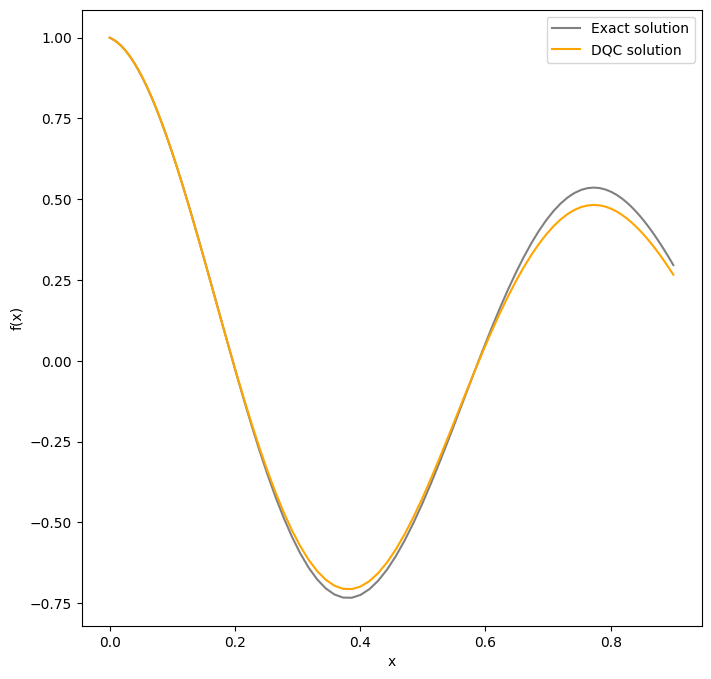

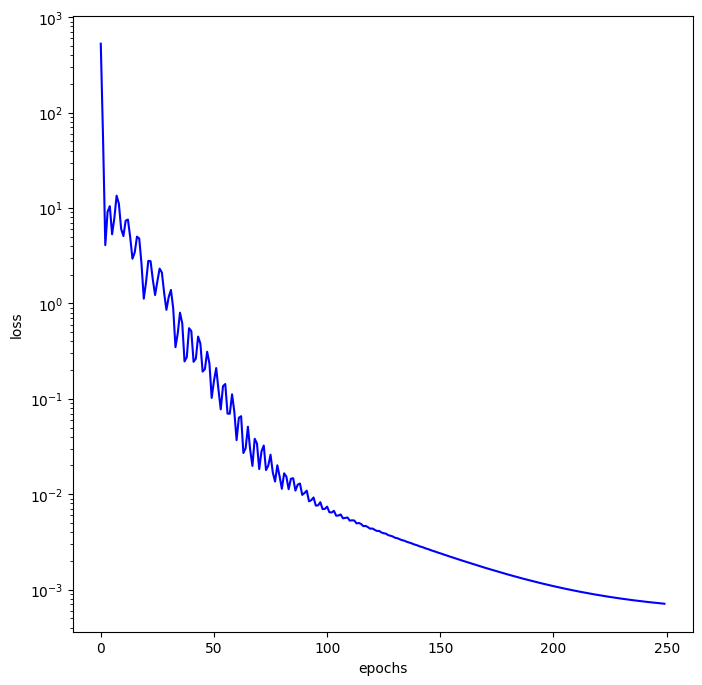

Seed id:  9
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [5.67986071e-01 8.80533756e-01 8.92233203e-01 3.43582118e-03
 4.76398536e-02 9.57632555e-01 2.68792396e-01 5.57517155e-01
 8.08215102e-01 7.33604207e-01 5.20826421e-01 5.01720071e-01
 2.14771646e-01 3.40773124e-01 9.61320204e-02 5.28960819e-01
 8.59318295e-01 7.48337795e-01 4.14916529e-01 6.34025770e-01
 3.94843419e-01 8.83685995e-01 1.70329031e-01 1.20030347e-01
 1.56582213e-01 4.87357752e-01 8.69862197e-01 7.36666179e-01
 9.77176170e-01 8.60917762e-01 2.29428770e-01 3.05563319e-01
 8.06264234e-03 1.52566870e-01 9.89532325e-01 4.30912404e-01
 2.81860698e-01 6.48128870e-02 4.67719604e-01 2.16615981e-01
 1.33734114e-01 6.93680935e-01 8.29711285e-01 3.31291471e-01
 6.38473211e-01 3.82869410e-01 3.64751375e-01 5.84074952e-01
 9.89926040e-01 5.24508642e-01 6.46515357e-01 4.21344525e-03
 8.35048992e-01 5.86980913e-01 9.50810544e-01 2.09133961e-01
 2.29772702e-01 4.57151465e-01 4.81935111e-01 8.68712433e-01
 2.75521050e-01 4.5

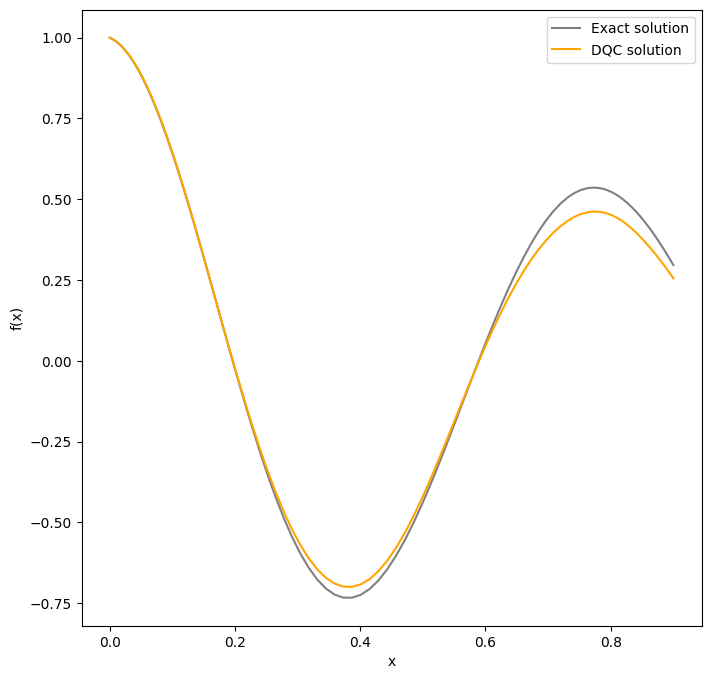

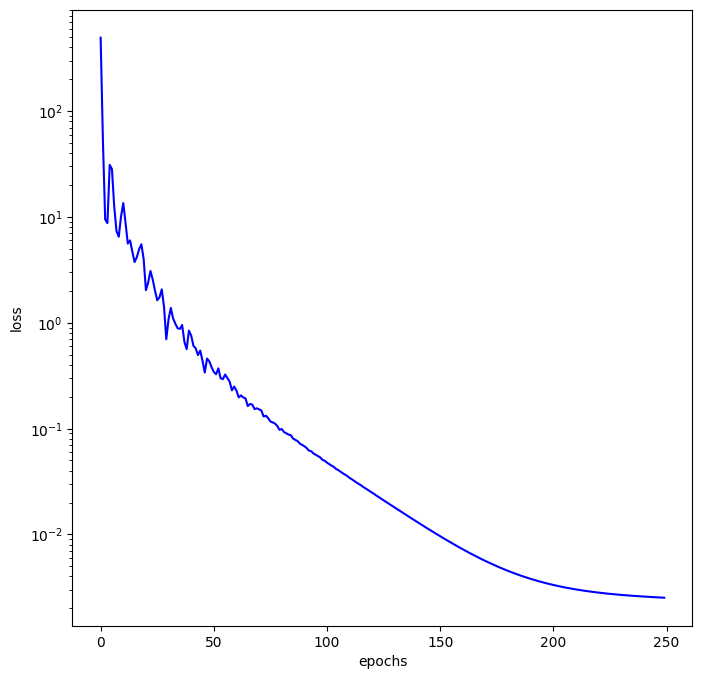

Seed id:  10
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.79026492 0.32265731 0.64076636 0.34228093 0.28698258 0.40419044
 0.65500089 0.86792746 0.28141598 0.00764042 0.19125231 0.16339556
 0.93887386 0.89101941 0.1754833  0.22754761 0.90291027 0.70563238
 0.79958479 0.73215916 0.51793474 0.33343831 0.56158407 0.83025312
 0.10457075 0.65110695 0.87163825 0.96182603 0.79825602 0.06648747
 0.52479443 0.53038984 0.42658033 0.27980129 0.11196026 0.26581155
 0.34601447 0.25752128 0.59573588 0.32970688 0.3564388  0.54501867
 0.20049243 0.41626905 0.16922582 0.10410612 0.13256137 0.6403439
 0.53080196 0.41688325 0.65340275 0.72240149 0.03553429 0.89966889
 0.03162228 0.89458576 0.74350682 0.70570788 0.77252851 0.55998973
 0.71766081 0.99526544 0.10910492 0.3800185  0.05218274 0.46378553
 0.46594557 0.14665141 0.42251519 0.62809548 0.5883926  0.2434575
 0.62514258 0.56610341 0.0863552  0.50807137 0.54336569 0.63150238
 0.48328795 0.28271902 0.49689867 0.8373857  0.00265059 0.624787

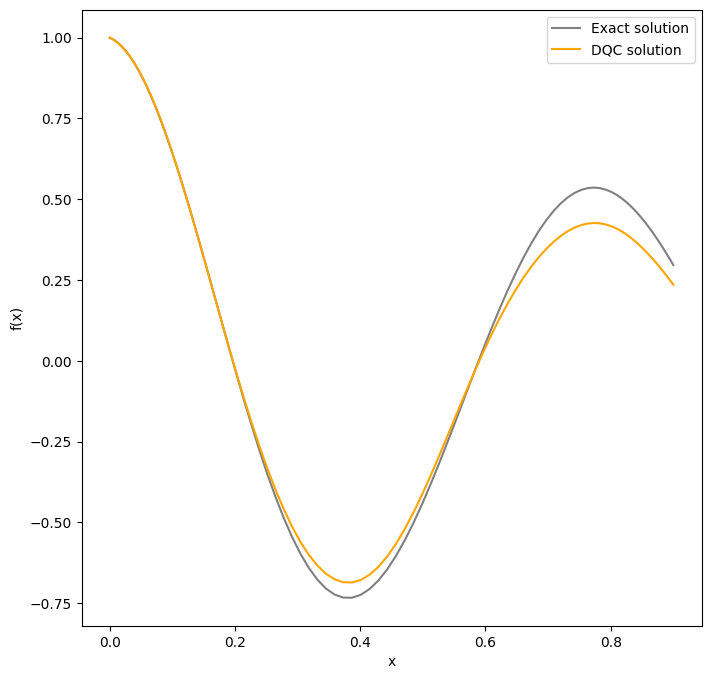

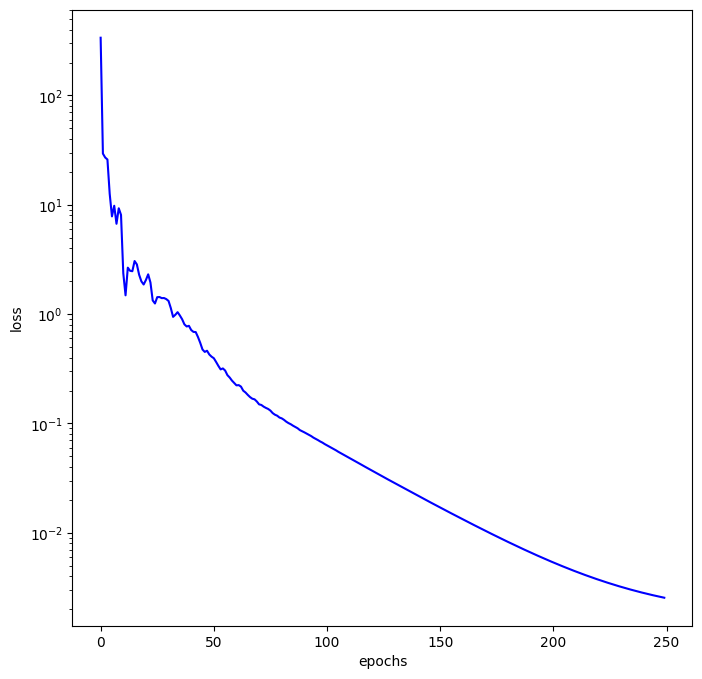

Seed id:  11
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.96188284 0.89849725 0.84069813 0.94187406 0.44010356 0.69396463
 0.49094033 0.79795431 0.68949122 0.60356561 0.51906862 0.52549716
 0.44540114 0.4722884  0.87895723 0.92702582 0.90095769 0.31472911
 0.87962701 0.98023292 0.45912873 0.92195859 0.23711499 0.21495868
 0.9820098  0.4369667  0.69286525 0.60972889 0.50904169 0.38949278
 0.14136594 0.41791671 0.13753556 0.62250015 0.8076108  0.12515437
 0.26741892 0.88442513 0.09128676 0.77364135 0.60188872 0.21024333
 0.65206276 0.48116447 0.04599115 0.54497995 0.2280026  0.63775005
 0.02343748 0.59495212 0.57851084 0.11366469 0.88817731 0.82614227
 0.56460516 0.29296713 0.35705752 0.60680584 0.0575322  0.55667371
 0.92588455 0.06792902 0.48099734 0.62248351 0.66299866 0.18433591
 0.53598835 0.12067447 0.62756418 0.81777462 0.126392   0.91736031
 0.95134653 0.24384794 0.3042339  0.45878742 0.74313089 0.38853274
 0.62085844 0.02070292 0.98406306 0.72581339 0.79242773 0.1627

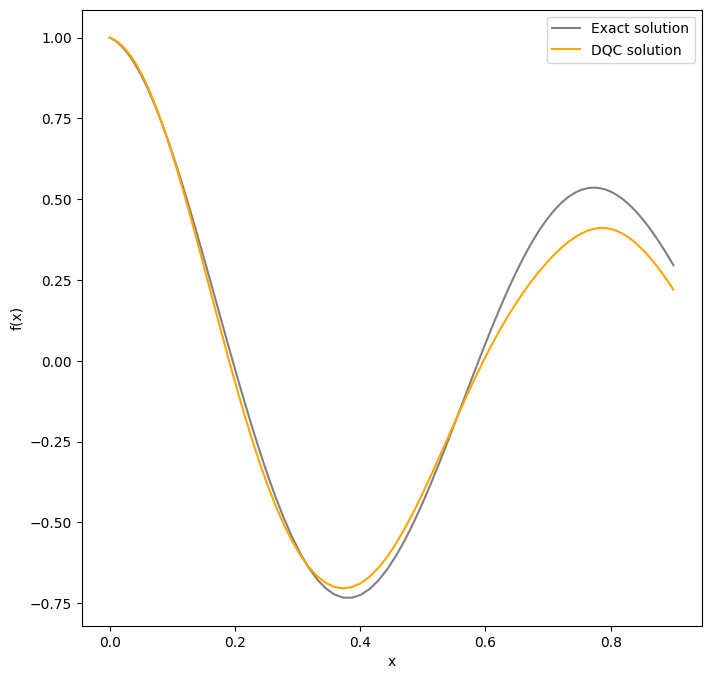

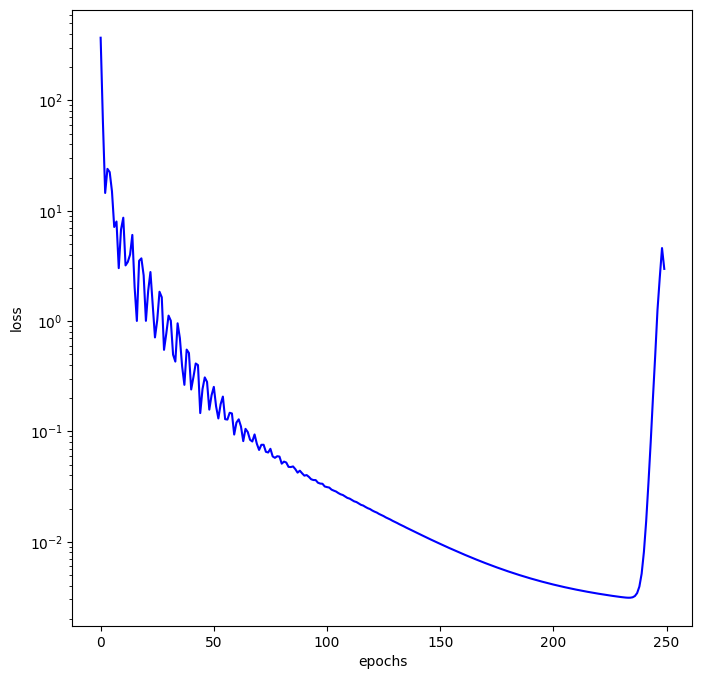

Seed id:  12
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.34426761 0.55392946 0.16982626 0.94990599 0.86814189 0.65981336
 0.78353459 0.89441363 0.69693873 0.95027321 0.24790629 0.92586858
 0.28628542 0.67023789 0.1467449  0.86111252 0.14817787 0.31223695
 0.39755129 0.73124139 0.10962092 0.92798245 0.94604529 0.76411354
 0.67528135 0.61739776 0.246508   0.62413846 0.8290352  0.21060483
 0.9810804  0.52839028 0.04692027 0.80494788 0.35150311 0.93049534
 0.52829016 0.22827271 0.61609562 0.43615499 0.18464462 0.60984626
 0.19792622 0.64360792 0.08500005 0.90504631 0.05768174 0.60275319
 0.58336118 0.06609342 0.62249208 0.34071175 0.73747575 0.05664388
 0.76862963 0.51617603 0.25010638 0.14746605 0.98880299 0.1528724
 0.25959673 0.41602959 0.10499216 0.52450619 0.68196746 0.4340568
 0.02942209 0.58390292 0.35442469 0.32248854 0.95475215 0.51520229
 0.18355877 0.68176826 0.02227217 0.88089409 0.7803966  0.17775179
 0.99801574 0.48587842 0.99882385 0.3332594  0.63495914 0.729008

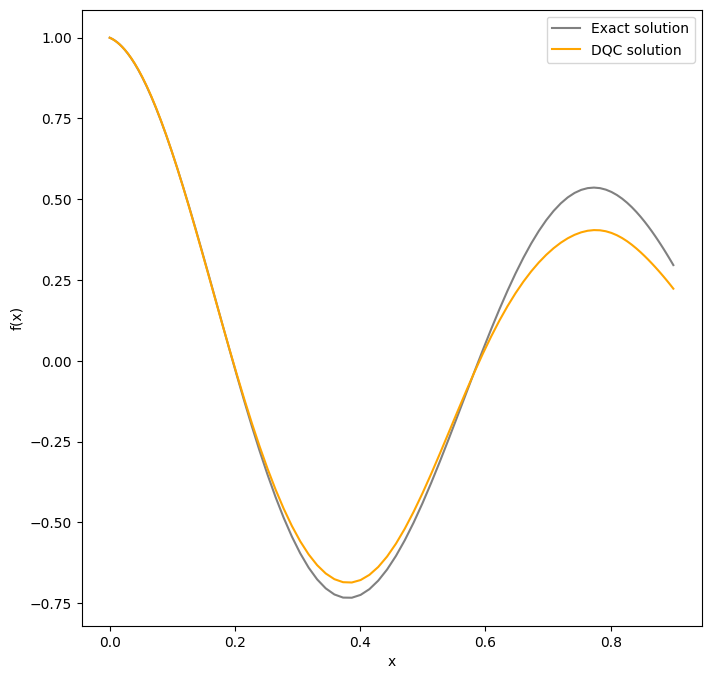

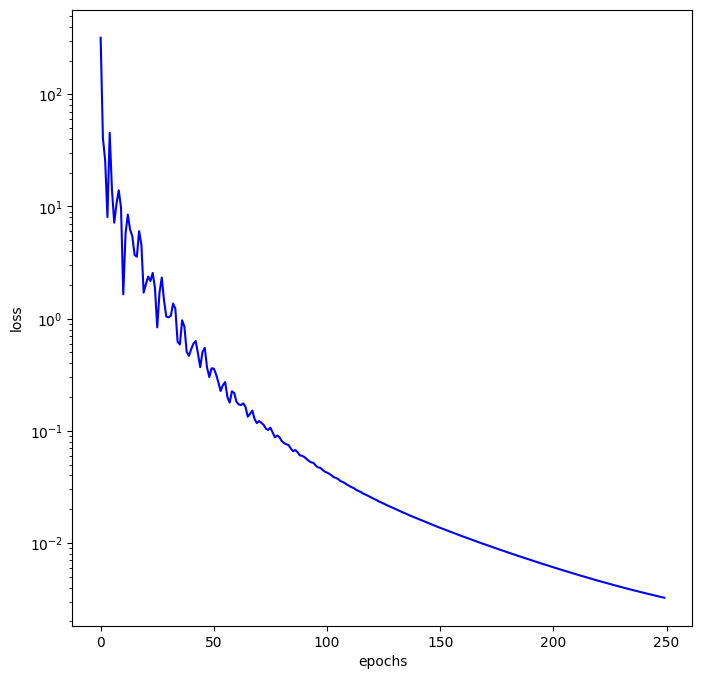

Seed id:  13
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.07342356 0.86003561 0.06395814 0.72475858 0.16110276 0.25458946
 0.94853992 0.04949589 0.47067386 0.50086241 0.63248175 0.97619144
 0.0167766  0.74069674 0.05812753 0.58484635 0.24766713 0.32853244
 0.02040185 0.9830344  0.63499642 0.91569395 0.12492605 0.89768313
 0.54732211 0.09379125 0.46569802 0.14868807 0.41425967 0.90357047
 0.59460949 0.76475482 0.46368306 0.85198866 0.02740571 0.06831797
 0.56340646 0.1739652  0.53652079 0.01558427 0.34741117 0.32773595
 0.33100609 0.69065797 0.19968027 0.22487271 0.95797508 0.23909039
 0.47203615 0.33307019 0.21220672 0.90234872 0.23577542 0.63740921
 0.70059119 0.00113462 0.27295158 0.58688615 0.47028855 0.08381962
 0.70637418 0.36330798 0.08665494 0.08571236 0.85821318 0.53881927
 0.30928823 0.33049163 0.94931546 0.1078329  0.6564775  0.38201935
 0.68797281 0.21053651 0.95788888 0.83278345 0.3802926  0.52231304
 0.12371428 0.01350281 0.55020241 0.12426384 0.62182115 0.2739

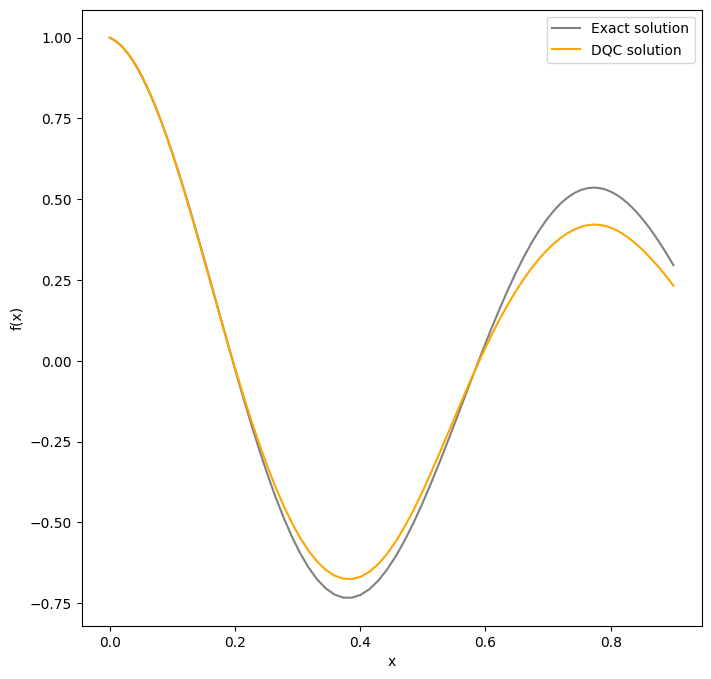

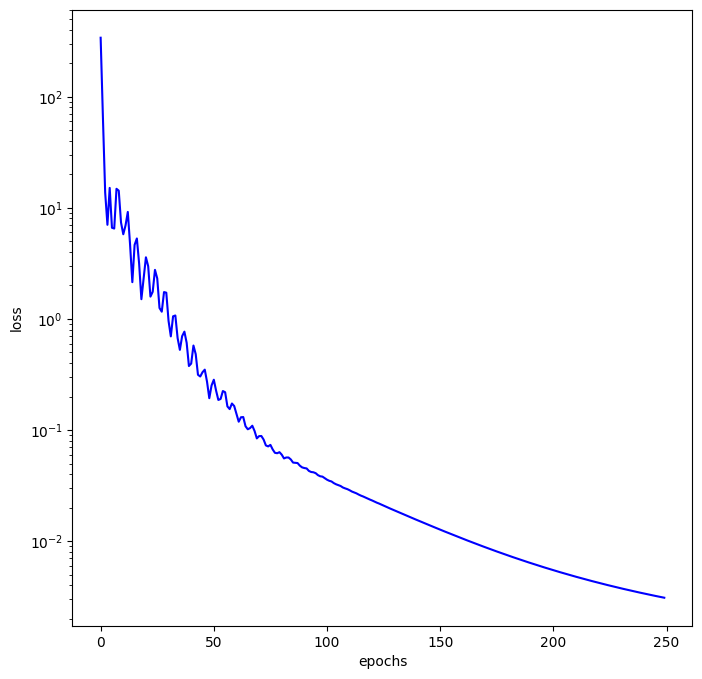

Seed id:  14
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.77217206 0.04067127 0.3197274  0.18064385 0.37071583 0.02787501
 0.62000295 0.65346831 0.28800922 0.10209839 0.84656548 0.14874484
 0.38062522 0.96613751 0.43249724 0.89108024 0.28771552 0.80834769
 0.12583324 0.54161541 0.91944205 0.18664579 0.73485254 0.86715898
 0.78880487 0.7880039  0.46199006 0.11048484 0.38928757 0.57822047
 0.44993383 0.5660816  0.58058911 0.62059219 0.20016641 0.08596639
 0.34259516 0.76519615 0.06686299 0.23343826 0.97215517 0.51994815
 0.85621691 0.46087375 0.2841255  0.80933513 0.54266835 0.7166603
 0.16072635 0.07598864 0.9885837  0.72245102 0.80223964 0.75539478
 0.37779759 0.70260503 0.07668316 0.46136456 0.07292825 0.60843746
 0.44459892 0.87813998 0.12350074 0.71804113 0.47604076 0.01865365
 0.37078429 0.69848632 0.05383897 0.20068543 0.3015365  0.97242445
 0.09768689 0.57007316 0.16093034 0.55632901 0.8252447  0.23138361
 0.53533974 0.73058753 0.56948887 0.86956044 0.79166705 0.50868

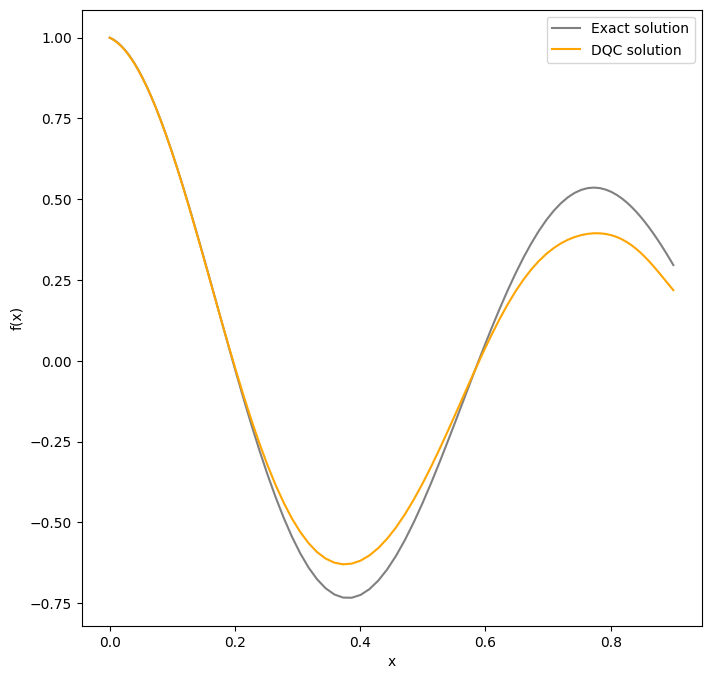

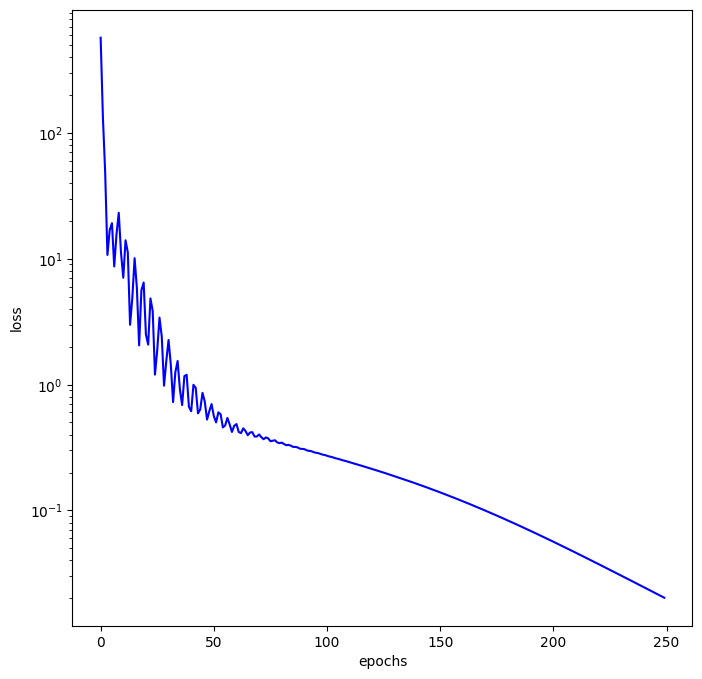

Seed id:  15
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.83843566 0.93096952 0.99097987 0.07445681 0.3457114  0.06383339
 0.42916249 0.08606168 0.57842225 0.18306521 0.89813611 0.39282215
 0.59531919 0.43605756 0.31591028 0.7495665  0.20768842 0.34931203
 0.65453042 0.97664037 0.92480976 0.51449069 0.74455537 0.21913007
 0.80793495 0.02386184 0.52526485 0.59202004 0.87240734 0.19900881
 0.92366805 0.85269629 0.67240824 0.6769387  0.60883183 0.70581165
 0.43026977 0.06731183 0.5635935  0.6479613  0.08622194 0.91521335
 0.994458   0.44963757 0.95065461 0.66798997 0.63654821 0.93514741
 0.951582   0.92363001 0.52083014 0.5262427  0.96883167 0.08950083
 0.44977927 0.49652162 0.24849501 0.6786694  0.90548226 0.25771174
 0.56375571 0.55329103 0.31640993 0.97041204 0.68898245 0.49111733
 0.68357694 0.56041841 0.17267586 0.25948464 0.2562963  0.8678461
 0.92296943 0.04583346 0.75341205 0.69550461 0.1324738  0.52269594
 0.16078371 0.78190789 0.90466368 0.65050753 0.99226071 0.13453

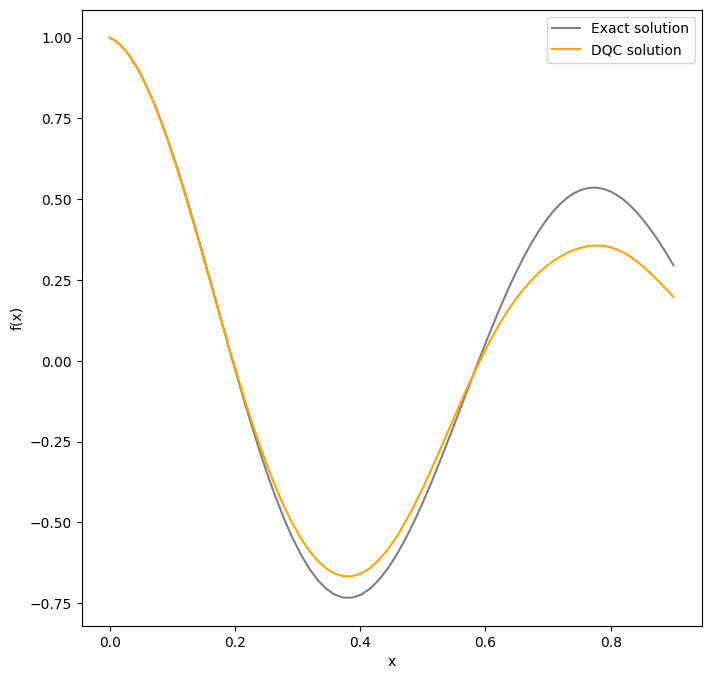

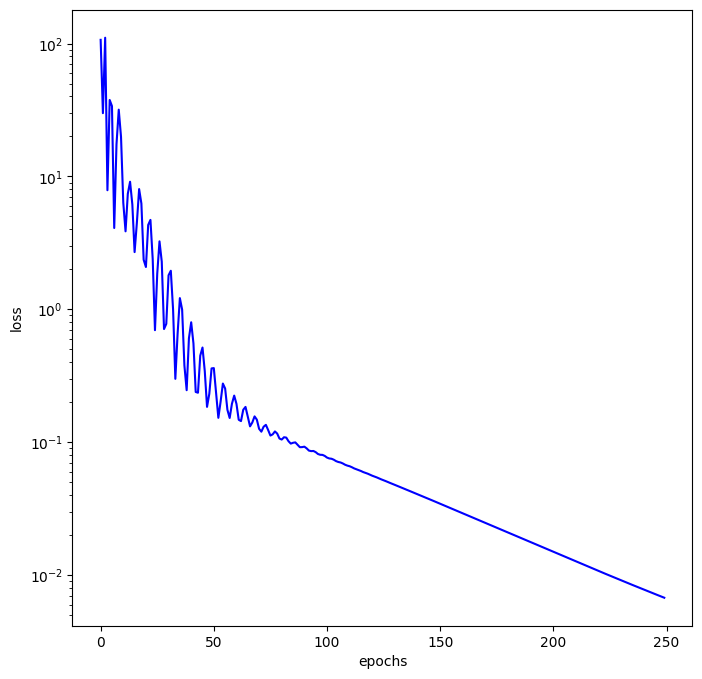

Seed id:  16
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.34211603 0.42033388 0.44353808 0.85312582 0.02694136 0.7734516
 0.34955682 0.20822325 0.71933132 0.48775025 0.09432186 0.13874629
 0.50247913 0.67959099 0.28658522 0.61605379 0.52223211 0.95479636
 0.95719338 0.97623673 0.04678901 0.49967062 0.76837688 0.82487003
 0.62785235 0.05380446 0.71224125 0.33952064 0.30309722 0.06938787
 0.80177076 0.66515145 0.4151866  0.64499322 0.11741557 0.21553624
 0.28603878 0.46615966 0.69200411 0.97753645 0.69381521 0.01747088
 0.68365697 0.22269223 0.8695326  0.83719763 0.00905038 0.21008094
 0.78749456 0.94600996 0.71451868 0.06239097 0.19555844 0.66405179
 0.93937577 0.20805742 0.22694638 0.51077819 0.30802401 0.14559469
 0.07171965 0.35048802 0.45798017 0.60814737 0.78397818 0.15587177
 0.15536143 0.48748983 0.67991295 0.91170003 0.77776207 0.20663387
 0.27791175 0.30391829 0.16907578 0.85414472 0.55549703 0.87349701
 0.71795236 0.69364411 0.53493376 0.05292129 0.15452827 0.75094

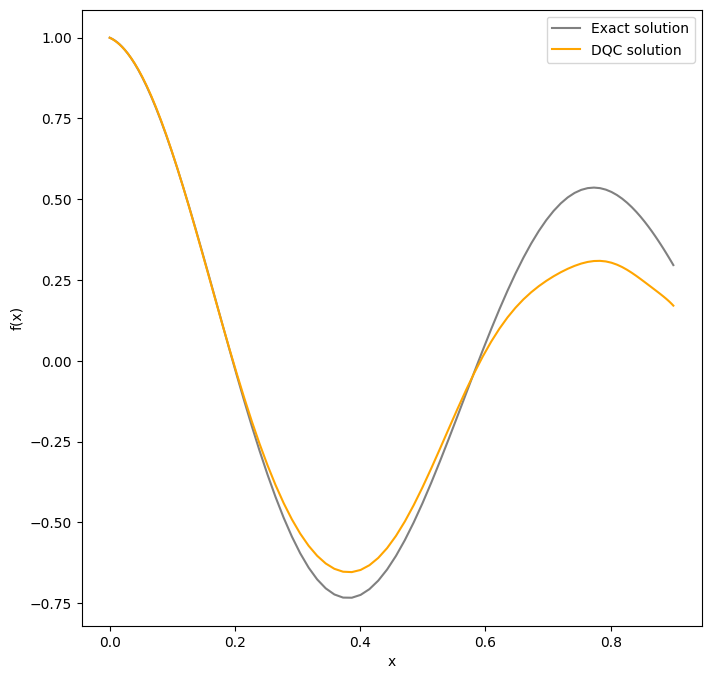

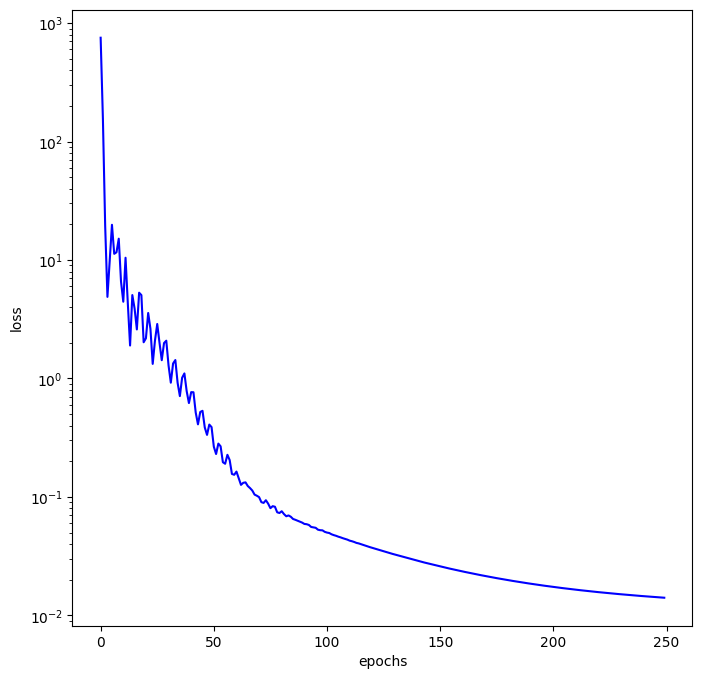

Seed id:  17
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.45812161 0.71715601 0.02272107 0.02496067 0.72997562 0.3047554
 0.37666686 0.16388536 0.0754555  0.22782769 0.55251485 0.35023773
 0.17923936 0.39384501 0.9975484  0.54408057 0.15840705 0.03509139
 0.86900052 0.47134287 0.94080811 0.4225723  0.70608396 0.16340969
 0.62559119 0.82046578 0.04920747 0.99484887 0.34781355 0.31574914
 0.41505539 0.04496548 0.15159969 0.17579187 0.05261581 0.96800477
 0.29198259 0.6215569  0.98643099 0.77672084 0.10311969 0.44288071
 0.11445556 0.27835709 0.11184939 0.24469586 0.45258324 0.16509775
 0.26726428 0.54772655 0.67207836 0.42863409 0.02552962 0.61164989
 0.32865353 0.20424232 0.26631752 0.37281146 0.52478584 0.11633085
 0.90620172 0.52687852 0.87698332 0.03485569 0.48730778 0.90419465
 0.57036334 0.67532194 0.03236339 0.69376997 0.59623502 0.73830903
 0.29080405 0.58577895 0.8337968  0.6541346  0.61972219 0.34952204
 0.06303726 0.08713224 0.52665196 0.63684268 0.54664769 0.47050

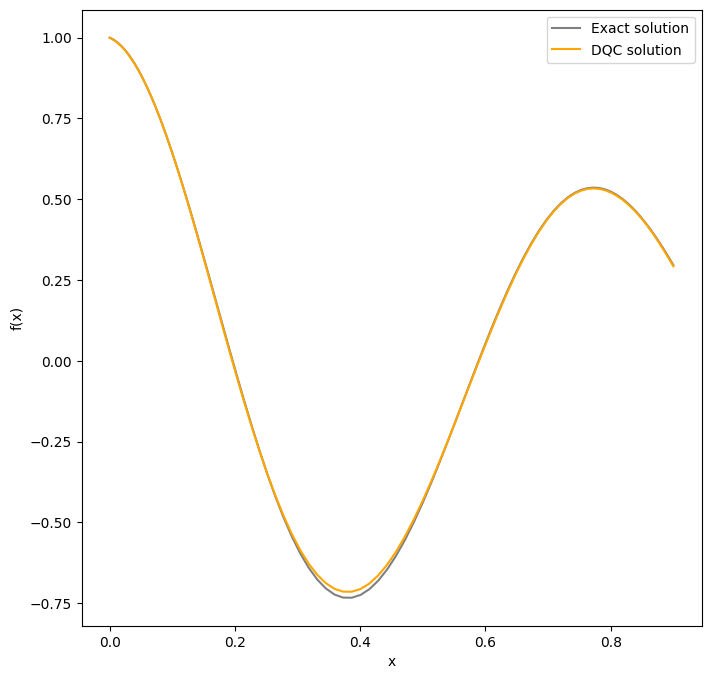

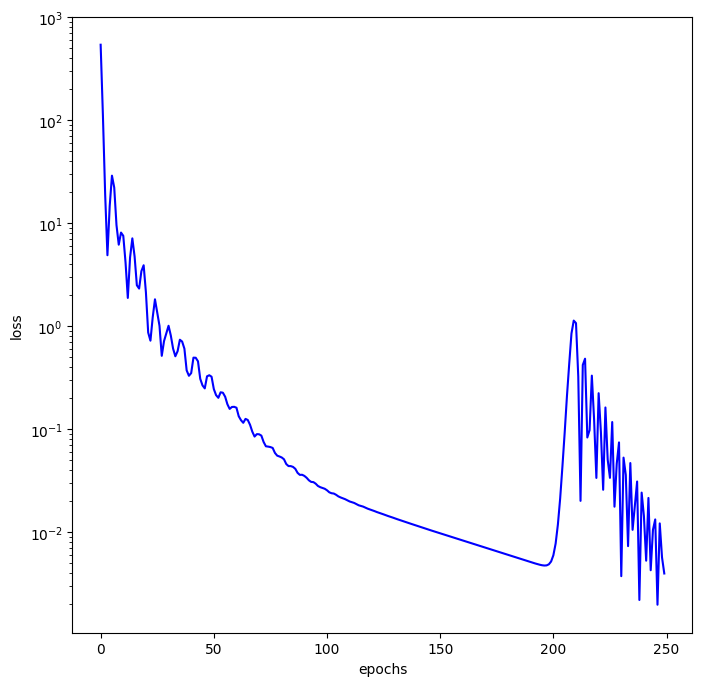

Seed id:  18
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.67859959 0.62991343 0.35731021 0.17175041 0.6447271  0.80712349
 0.52638076 0.09653545 0.25765422 0.38622309 0.17658878 0.85434155
 0.49456342 0.44884005 0.88471127 0.78216527 0.93465231 0.16353727
 0.16790078 0.3592349  0.41658272 0.00136478 0.30858702 0.59283389
 0.21347048 0.82955486 0.67079011 0.67592022 0.4911426  0.72289906
 0.71066106 0.8470779  0.83222867 0.31405572 0.24519152 0.06252178
 0.30681592 0.49819761 0.94701119 0.78148894 0.89390865 0.31559368
 0.20085418 0.53372794 0.28761781 0.63746926 0.7403498  0.26986208
 0.44661686 0.77585298 0.52525355 0.07205926 0.66622894 0.39571854
 0.52928029 0.90129045 0.60176983 0.21863676 0.31591777 0.73499457
 0.68721402 0.34201723 0.65649216 0.68359421 0.88081059 0.08221993
 0.22283974 0.79015678 0.21377089 0.01627149 0.19887264 0.95590349
 0.77092876 0.66272833 0.80142828 0.34827081 0.52849142 0.74714757
 0.37871355 0.6525597  0.85370773 0.26762493 0.43405155 0.6979

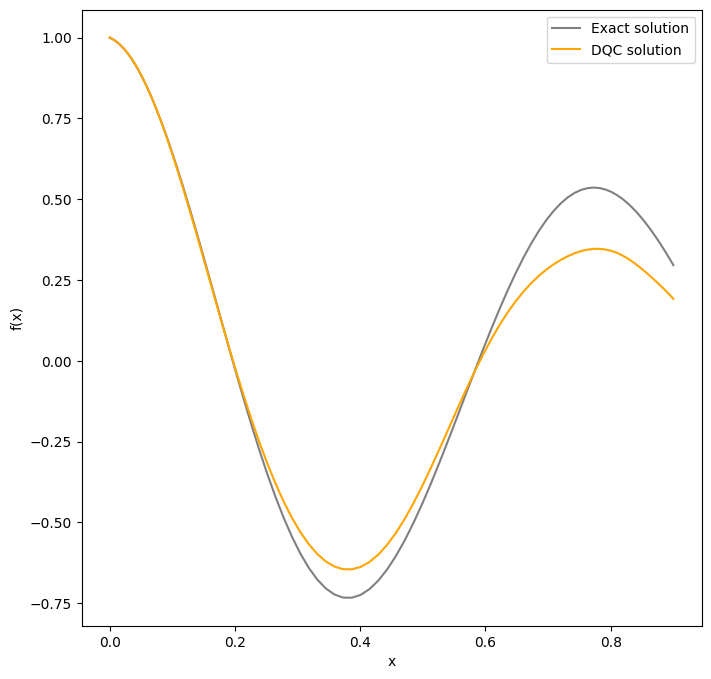

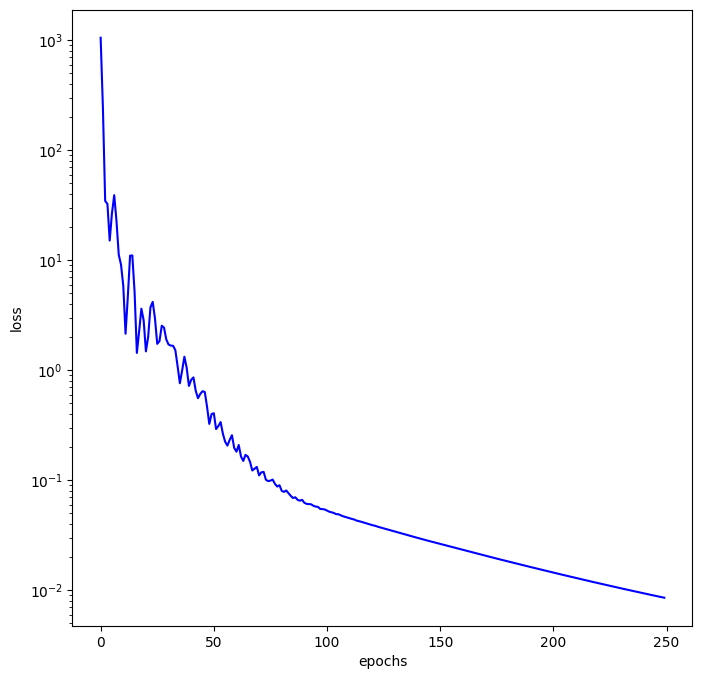

Seed id:  19
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.60001321 0.63225109 0.43255262 0.14881359 0.03113828 0.06082422
 0.7564834  0.52731576 0.00149418 0.15517632 0.44078621 0.54684054
 0.52199038 0.82981839 0.57992959 0.26879555 0.12292366 0.47473879
 0.30298543 0.4774444  0.60885236 0.18545133 0.08061812 0.11620142
 0.84992351 0.34391301 0.20544866 0.58993863 0.01993144 0.51407214
 0.11368906 0.56042019 0.94588703 0.03503114 0.86244625 0.74872973
 0.88145321 0.32917384 0.27108444 0.76400395 0.96759143 0.76659632
 0.31435966 0.44527789 0.01289821 0.76528703 0.49109034 0.15855909
 0.20817887 0.34359849 0.97495517 0.78118975 0.19188546 0.27680066
 0.86407409 0.24092354 0.13216591 0.12059877 0.38727958 0.54970556
 0.38102344 0.53264196 0.6522374  0.82863595 0.22841375 0.52226279
 0.44140357 0.59991394 0.33638085 0.94938746 0.62312376 0.16726477
 0.57824735 0.1900617  0.01890043 0.07760682 0.16301268 0.06047519
 0.59225935 0.43801027 0.42604809 0.32962519 0.42400157 0.6496

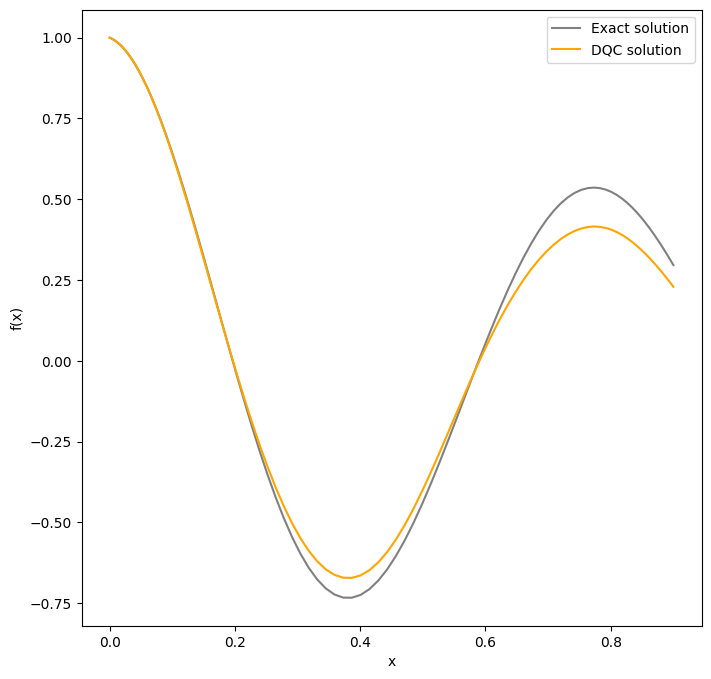

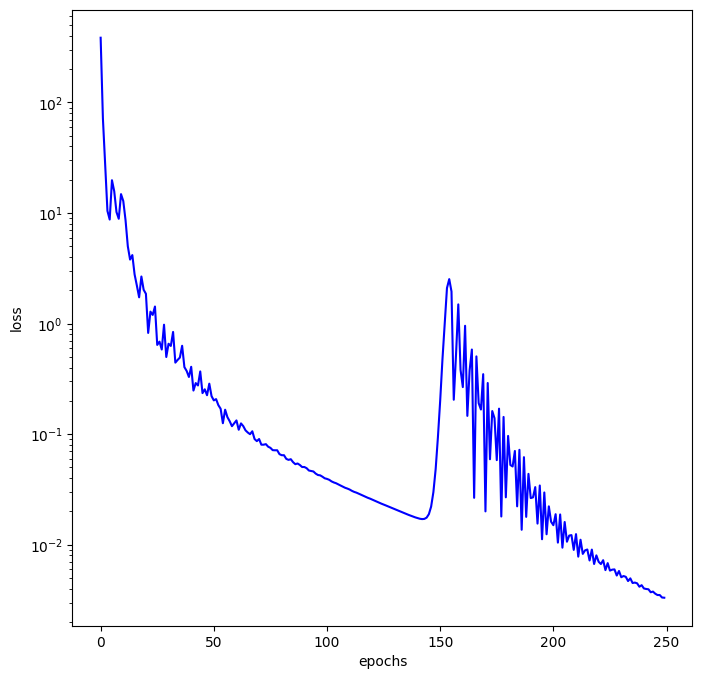

Seed id:  20
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.137015   0.61074966 0.52521195 0.9980081  0.67654446 0.08662912
 0.55521622 0.64250984 0.64785075 0.53728627 0.24670013 0.80819701
 0.49781887 0.24165109 0.07846539 0.69552197 0.20305115 0.99623918
 0.51476685 0.6120867  0.54416006 0.98307762 0.03100083 0.4348554
 0.20808946 0.88134843 0.57027888 0.77067723 0.1161818  0.73064448
 0.29011653 0.10090474 0.71102229 0.78185634 0.50332913 0.25252448
 0.49667842 0.54914185 0.55255602 0.64779701 0.99684672 0.37287409
 0.35378965 0.60979951 0.42960478 0.61167829 0.4424003  0.72341161
 0.62061439 0.68400864 0.72236839 0.72247928 0.36404267 0.3122045
 0.11370314 0.55817791 0.18986111 0.53045762 0.86219533 0.2966475
 0.6635872  0.08132411 0.10075638 0.20159245 0.50010481 0.2497875
 0.57073731 0.65109532 0.43927948 0.78669033 0.4320306  0.40055963
 0.9069176  0.67840412 0.94619341 0.17280148 0.4239701  0.2932499
 0.0772979  0.99073393 0.57222473 0.05468596 0.06265422 0.47377683


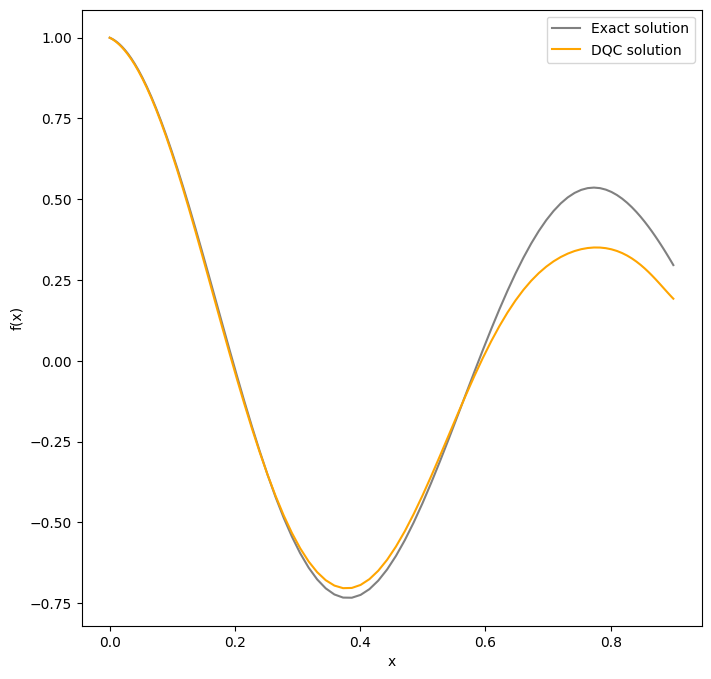

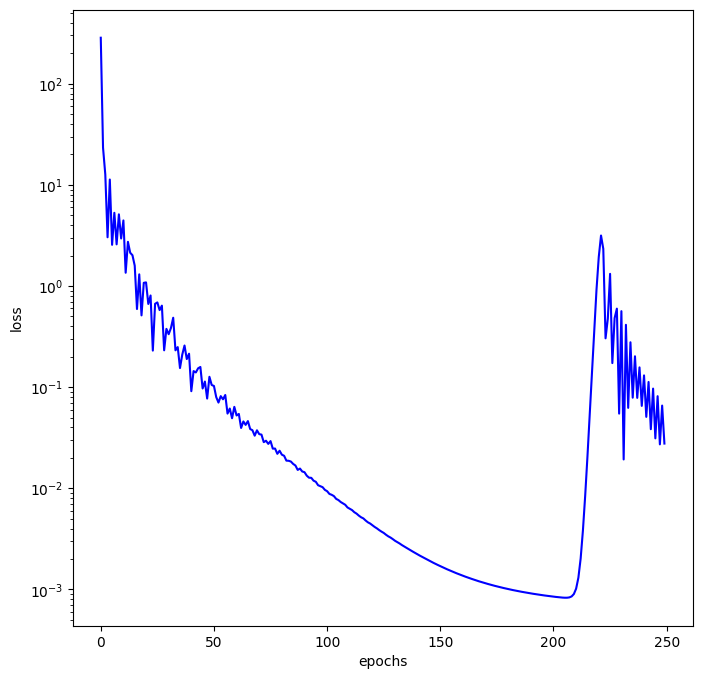

Seed id:  21
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.24865768 0.8779154  0.65890459 0.25813197 0.82620527 0.56256124
 0.77068894 0.90422375 0.13666429 0.6672322  0.31937742 0.74270691
 0.54263316 0.3504448  0.86097009 0.56426975 0.72139116 0.46027214
 0.0664925  0.70988391 0.40131678 0.46250939 0.44087037 0.05432173
 0.11474973 0.17492752 0.31479735 0.54027591 0.70827295 0.77741624
 0.02618163 0.60820691 0.26700293 0.85081007 0.69315095 0.07721234
 0.59457896 0.73032309 0.95506335 0.21192258 0.38247914 0.61581956
 0.16475284 0.18236698 0.13938674 0.58389381 0.46827116 0.24005036
 0.43669634 0.87356839 0.77492455 0.74870336 0.94450032 0.00846951
 0.48653234 0.27218262 0.58957328 0.95476868 0.83924947 0.54751454
 0.23702742 0.5597155  0.17226244 0.32660345 0.44359402 0.86080717
 0.72871432 0.29335044 0.70360034 0.74655566 0.5879741  0.30872639
 0.82075239 0.89168023 0.48103721 0.31652054 0.40555621 0.84659532
 0.48594123 0.89738903 0.0928837  0.40178614 0.98613554 0.3887

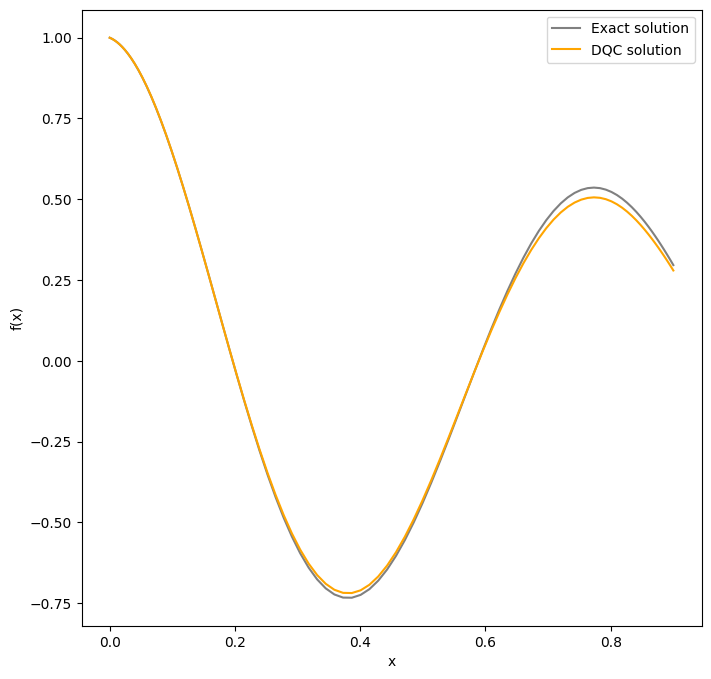

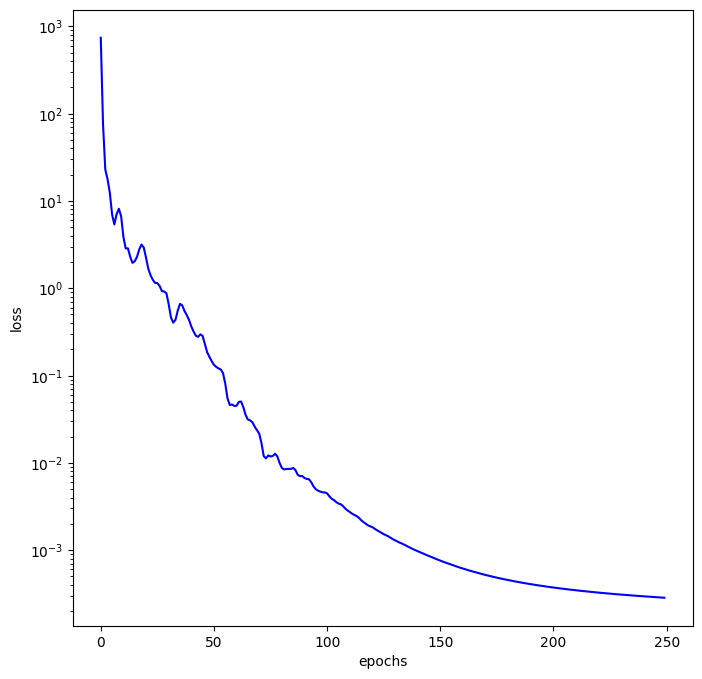

Seed id:  22
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [2.68852579e-04 6.16304575e-01 7.57010276e-01 4.11357368e-01
 1.04404255e-01 7.97698687e-01 1.02252363e-02 6.83452470e-01
 9.05358487e-01 2.36510205e-01 1.79889608e-04 9.45368039e-01
 4.50054733e-01 3.38107787e-01 8.95669171e-01 8.71287819e-01
 4.42718454e-01 5.47093828e-01 7.80592751e-02 2.88467069e-01
 6.35419034e-01 7.92413636e-01 6.95358440e-01 7.61395901e-01
 1.82853571e-01 2.96056310e-01 3.44631809e-01 9.15336612e-01
 6.65144581e-01 6.65656728e-01 3.01570231e-01 1.62052168e-01
 4.97012362e-01 1.23179557e-01 1.92889721e-02 2.55346016e-01
 4.84743112e-01 3.16972646e-01 9.69647535e-02 8.63556087e-01
 4.44247568e-01 9.78210984e-01 1.33103730e-01 7.48694620e-01
 8.20527856e-01 1.98376562e-01 9.92867563e-01 6.34157717e-01
 5.66853689e-01 9.06401614e-01 9.67359004e-01 3.73826239e-01
 2.29259829e-01 3.28691036e-01 6.21280534e-01 7.62926936e-01
 8.87495469e-01 7.02916090e-01 7.88321615e-01 2.93435987e-01
 8.17510894e-01 8.

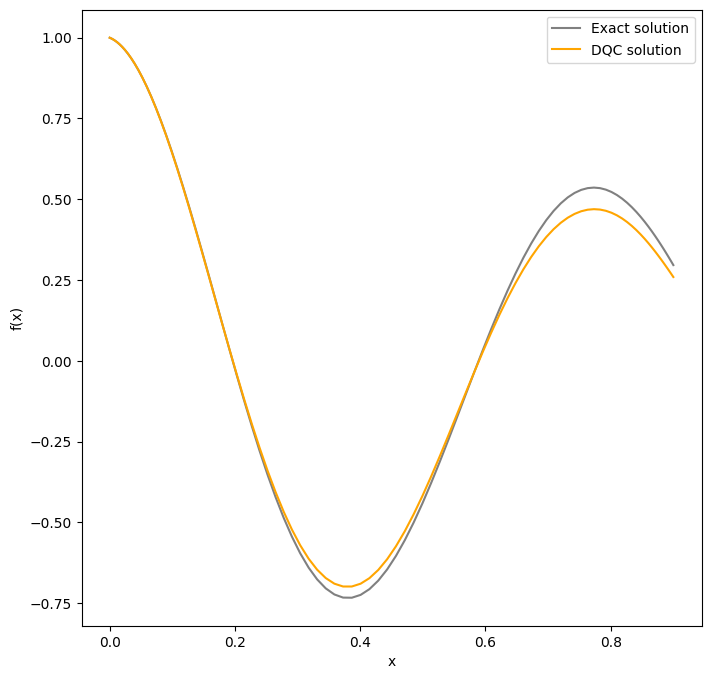

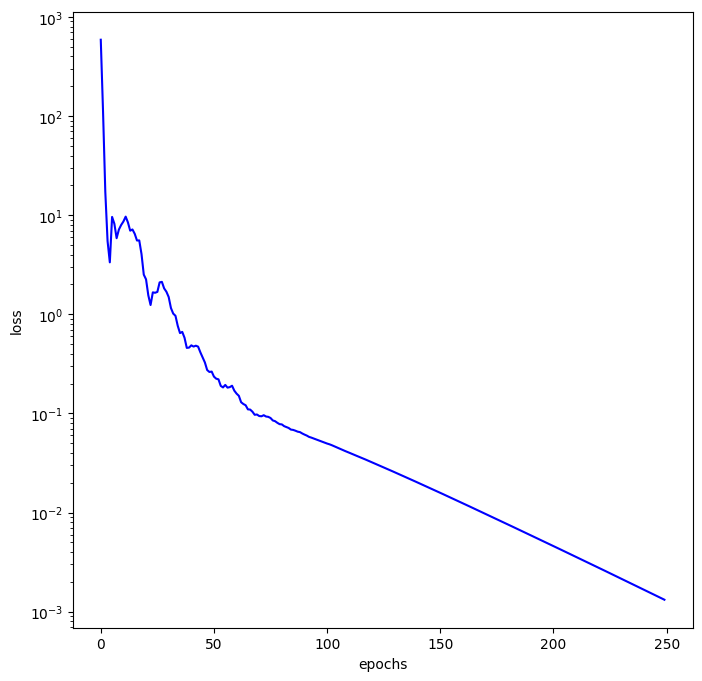

Seed id:  23
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.01082438 0.98675594 0.03138542 0.62879201 0.92308144 0.49413498
 0.49635189 0.18293232 0.96014176 0.80463304 0.54148577 0.48599646
 0.74009189 0.43691663 0.85768775 0.74986034 0.46660511 0.43330345
 0.56173765 0.61765325 0.01727569 0.85639839 0.25540397 0.1553324
 0.82167886 0.09086387 0.02624593 0.34176317 0.63729768 0.44419832
 0.18723912 0.64917833 0.49560829 0.68175994 0.91801218 0.02072021
 0.50349409 0.32565091 0.16163466 0.67725013 0.70658286 0.28571332
 0.57301388 0.86022811 0.22677563 0.48711983 0.86809155 0.11380178
 0.70022227 0.2082825  0.97252156 0.62541845 0.62037073 0.01600112
 0.3789836  0.34222545 0.73730748 0.92214568 0.29180975 0.46729688
 0.30112051 0.07055219 0.32426115 0.72721073 0.05291511 0.80252536
 0.78509156 0.14097092 0.67505771 0.41093094 0.18850724 0.83834442
 0.05601541 0.09536507 0.36882409 0.28039869 0.29592847 0.57430293
 0.132022   0.15763612 0.51859952 0.12518725 0.61780591 0.40387

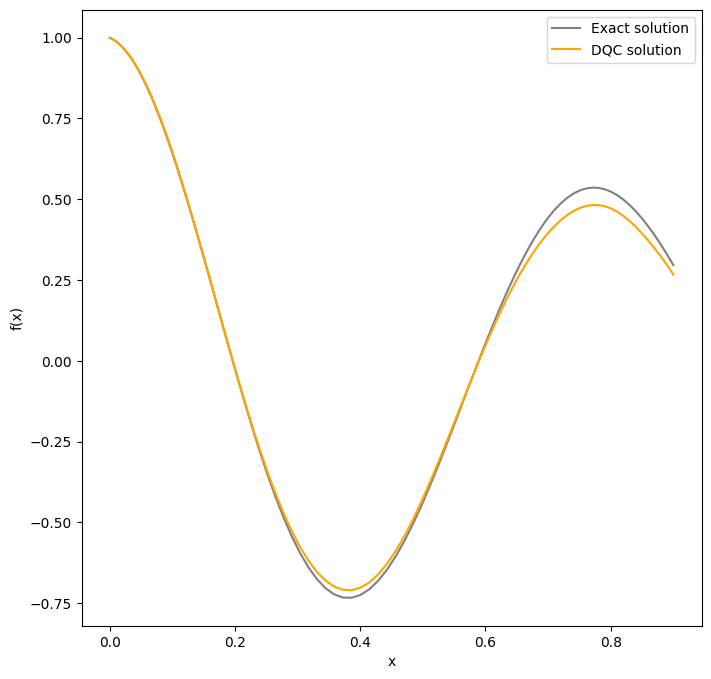

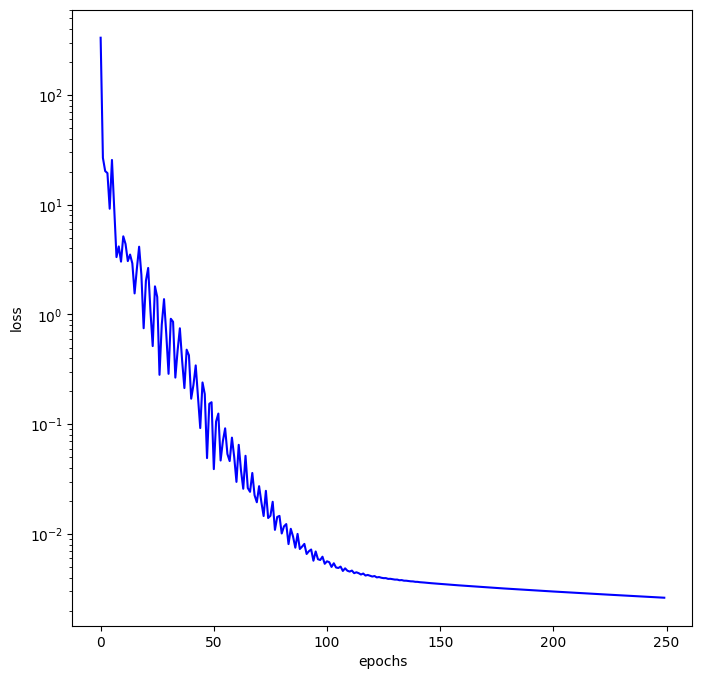

Seed id:  24
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.35120414 0.89836538 0.14717549 0.24603724 0.1432882  0.45312431
 0.33693343 0.43344612 0.47796022 0.27018325 0.96597108 0.97723536
 0.14109306 0.96676982 0.99013112 0.0641515  0.09194305 0.61789367
 0.91139344 0.9922982  0.59811871 0.03499952 0.14007593 0.81472053
 0.02649548 0.76843244 0.29115885 0.83927169 0.38601467 0.79719966
 0.4212178  0.33960124 0.96228613 0.98563943 0.82219344 0.57194025
 0.95801295 0.49436551 0.0163249  0.96706951 0.00854998 0.70431635
 0.64975156 0.6750216  0.95337079 0.27562913 0.47191038 0.10162734
 0.59480432 0.65993262 0.90248237 0.82442739 0.67190649 0.33947236
 0.63099288 0.51535415 0.11650699 0.76307638 0.88479681 0.59141204
 0.44807755 0.90692752 0.42710135 0.67575395 0.76374991 0.28602291
 0.43807014 0.64006603 0.99508689 0.16236023 0.10502262 0.31580209
 0.88261899 0.6612024  0.62892591 0.47637516 0.1752856  0.21750202
 0.66236439 0.43400917 0.04488736 0.74561931 0.0133672  0.7632

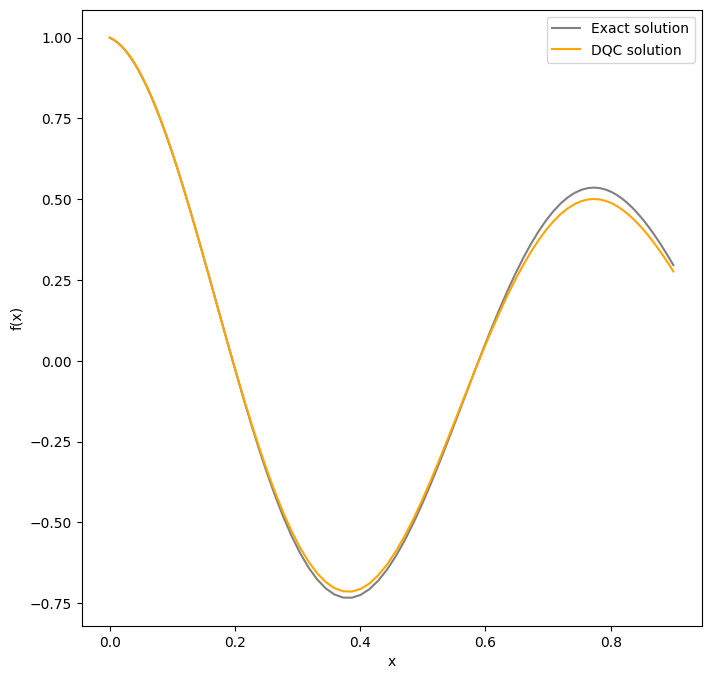

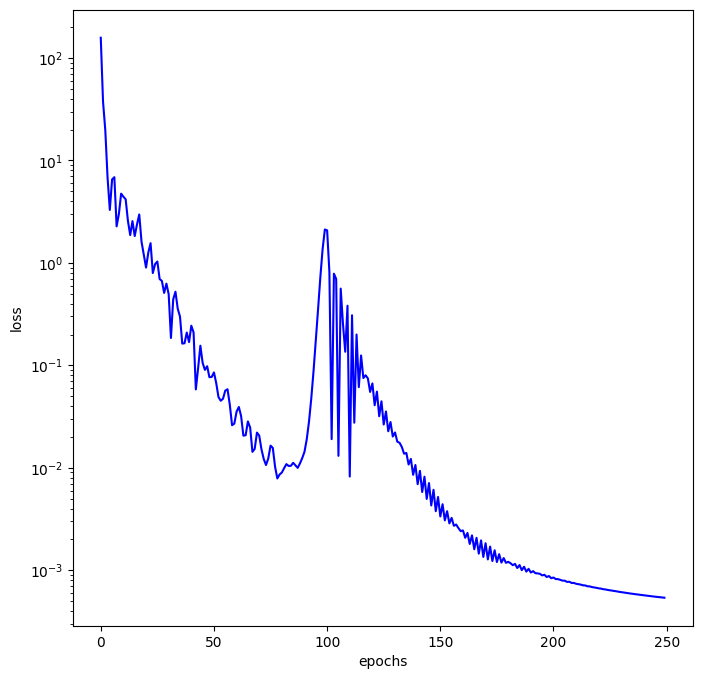

Seed id:  25
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.93096356 0.10494405 0.17467729 0.59175132 0.18160149 0.70922977
 0.70055216 0.64943927 0.59448632 0.15854768 0.81397078 0.18262852
 0.97625553 0.06052391 0.58717947 0.24450753 0.17321633 0.88546183
 0.05588855 0.90232192 0.99727475 0.89379328 0.08732882 0.22500844
 0.2299583  0.10167325 0.5118073  0.76933578 0.76560893 0.43680301
 0.51703081 0.98478183 0.60672684 0.04451383 0.13375692 0.33704895
 0.02148658 0.0543268  0.63997637 0.64616069 0.17862445 0.71392527
 0.47063941 0.35512667 0.84643009 0.08945323 0.86734177 0.51955786
 0.28849262 0.00714426 0.7626349  0.20483392 0.59624271 0.65680197
 0.21652957 0.3004225  0.08283013 0.61154275 0.25460788 0.41610358
 0.12761837 0.94529249 0.68167847 0.29775286 0.71510603 0.94134416
 0.11132891 0.96827372 0.8430155  0.73411839 0.59047752 0.66186114
 0.61918748 0.30251747 0.06409091 0.2855017  0.18473029 0.3941299
 0.72440927 0.15895722 0.57609823 0.09539274 0.03187078 0.50470

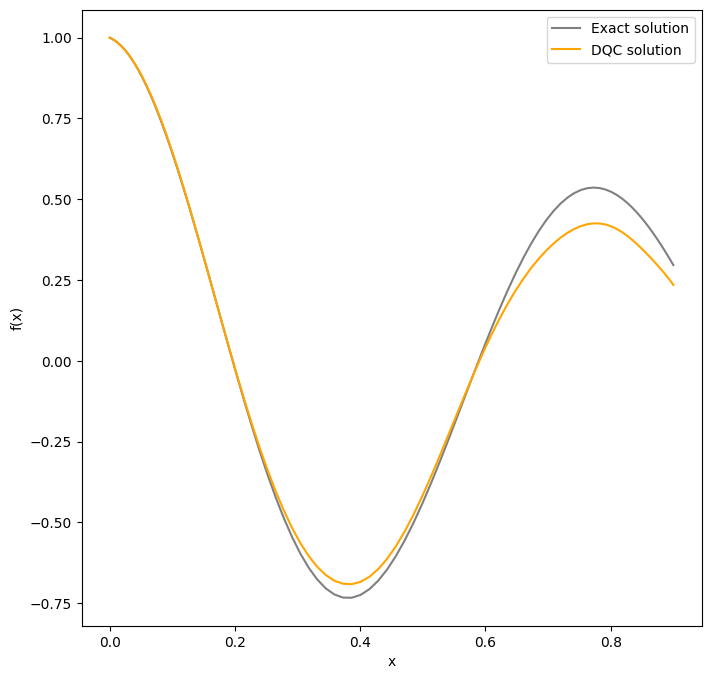

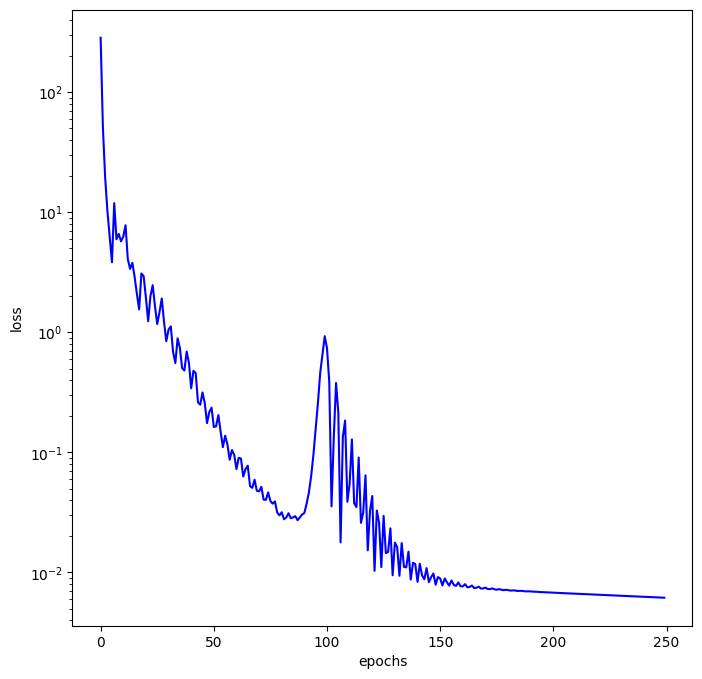

Seed id:  26
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.77028148 0.53409741 0.22692505 0.89326059 0.95000088 0.3849293
 0.84035924 0.18144345 0.47059362 0.29409633 0.18113377 0.77717931
 0.01187561 0.52707503 0.19367956 0.60641549 0.68345006 0.35341957
 0.61397455 0.60136214 0.49468957 0.11476824 0.70600488 0.52179554
 0.75187593 0.14326488 0.81046008 0.16291721 0.85090938 0.72506791
 0.85861819 0.75443888 0.54819073 0.67343366 0.17027751 0.73851582
 0.04480647 0.39936984 0.70788033 0.55159829 0.77951442 0.10384701
 0.87319985 0.58733363 0.42160839 0.34007263 0.5877121  0.00442386
 0.63989474 0.1214774  0.82889235 0.49380324 0.64677765 0.25446302
 0.71061283 0.34886793 0.25068675 0.50495609 0.8560323  0.08196433
 0.20938291 0.66192312 0.01494164 0.91115309 0.11337957 0.75451407
 0.30267495 0.16868738 0.97746768 0.40441317 0.62630394 0.46546138
 0.55669327 0.65344236 0.2734593  0.91378552 0.62561508 0.96911958
 0.33278462 0.7568295  0.55794889 0.56064042 0.69892159 0.32513

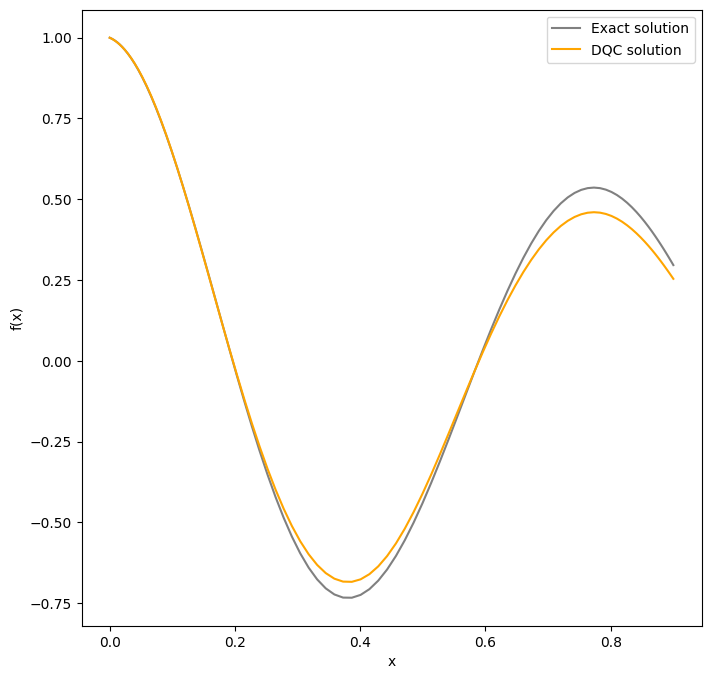

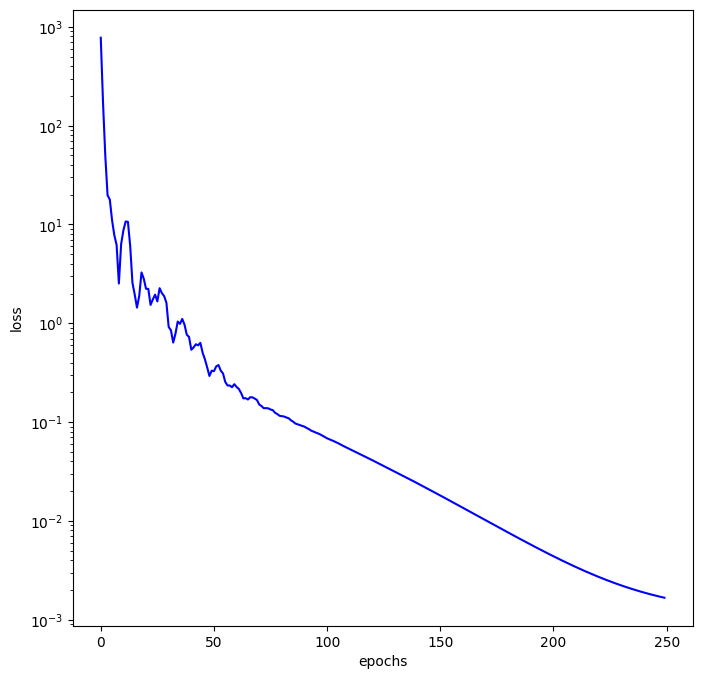

Seed id:  27
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.40623736 0.7724952  0.41187041 0.99346373 0.55898581 0.6698346
 0.70504537 0.76820865 0.95469661 0.25843718 0.61583062 0.47003128
 0.13135033 0.34677215 0.16027545 0.0133023  0.70679326 0.50723908
 0.00532101 0.01817166 0.87664335 0.11017786 0.19753706 0.12141392
 0.34539486 0.06417276 0.84223806 0.73880487 0.57123403 0.29733027
 0.96708864 0.8624039  0.80465838 0.63947407 0.4076988  0.36832707
 0.33266988 0.33797425 0.05737239 0.99187332 0.15734631 0.41268937
 0.00395919 0.76095967 0.81486078 0.91589371 0.29386167 0.57542862
 0.16778306 0.49175367 0.18802834 0.04658805 0.55028471 0.59479713
 0.92789096 0.39502949 0.06856022 0.02884041 0.40475978 0.47395864
 0.88603692 0.6461803  0.52651319 0.45698787 0.70758051 0.58997652
 0.24843205 0.2457815  0.18188516 0.78072427 0.69428546 0.8858449
 0.52689991 0.45554463 0.80378201 0.66526798 0.07243793 0.0241694
 0.27976578 0.39509027 0.12380789 0.06128737 0.83649886 0.5065880

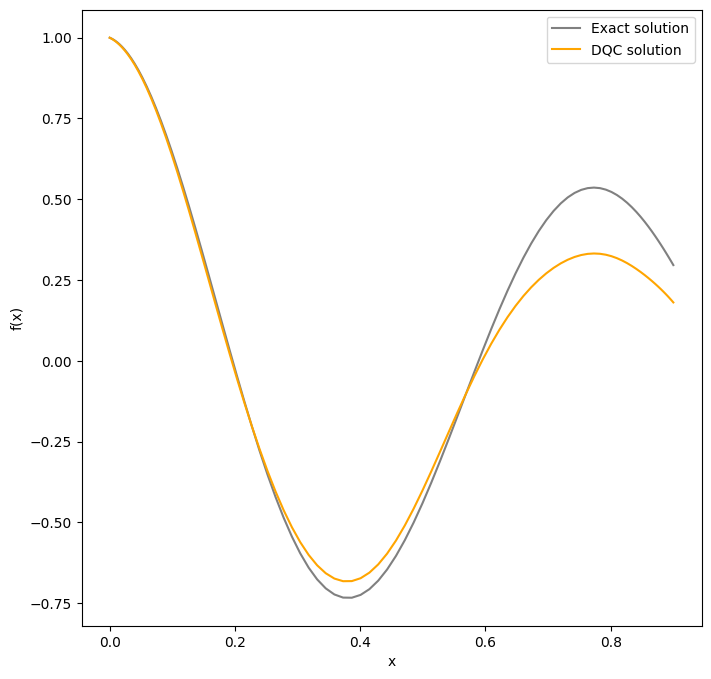

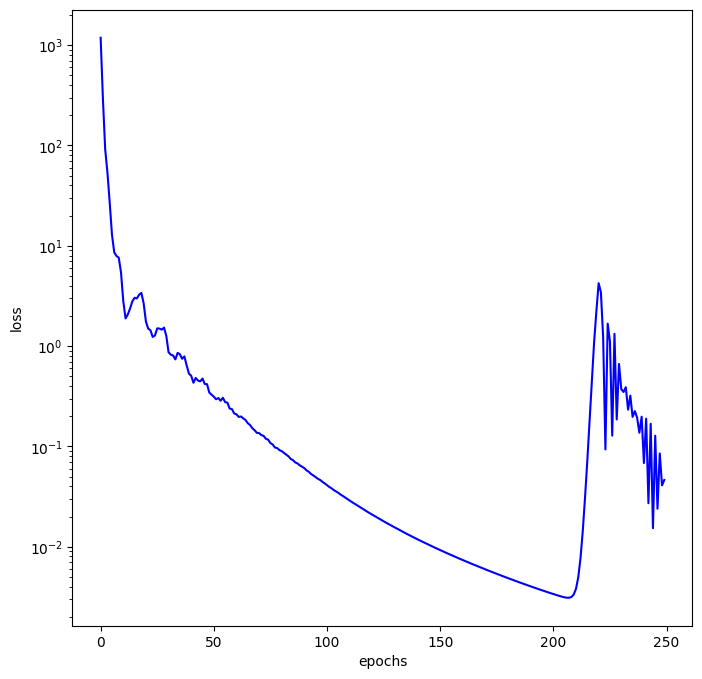

Seed id:  28
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.22702796 0.45278048 0.79988353 0.29062322 0.47141045 0.50689439
 0.85852853 0.69908528 0.38858904 0.39075314 0.97885992 0.90044289
 0.29236853 0.10520196 0.71919953 0.05221874 0.38633665 0.49965998
 0.05439512 0.20482323 0.47244993 0.94217378 0.99052474 0.96234782
 0.19980442 0.79435384 0.95103907 0.56010644 0.8038896  0.61875898
 0.50942741 0.5722378  0.59162395 0.04245531 0.43278228 0.04064228
 0.85332274 0.13695003 0.16189535 0.97255771 0.6720305  0.35135787
 0.24814457 0.12923272 0.29388132 0.36166377 0.34056931 0.81911733
 0.79188902 0.33424538 0.21107428 0.75364583 0.66106122 0.76375997
 0.72892741 0.25121774 0.75532683 0.13364225 0.63321407 0.92382205
 0.13836487 0.82373697 0.67883963 0.72675775 0.65466915 0.5277627
 0.95585055 0.4594646  0.50002247 0.19868116 0.38270717 0.28302334
 0.79050496 0.36559939 0.04235717 0.71661866 0.35700322 0.83090519
 0.27127535 0.80794651 0.80860008 0.24203338 0.16367851 0.82536

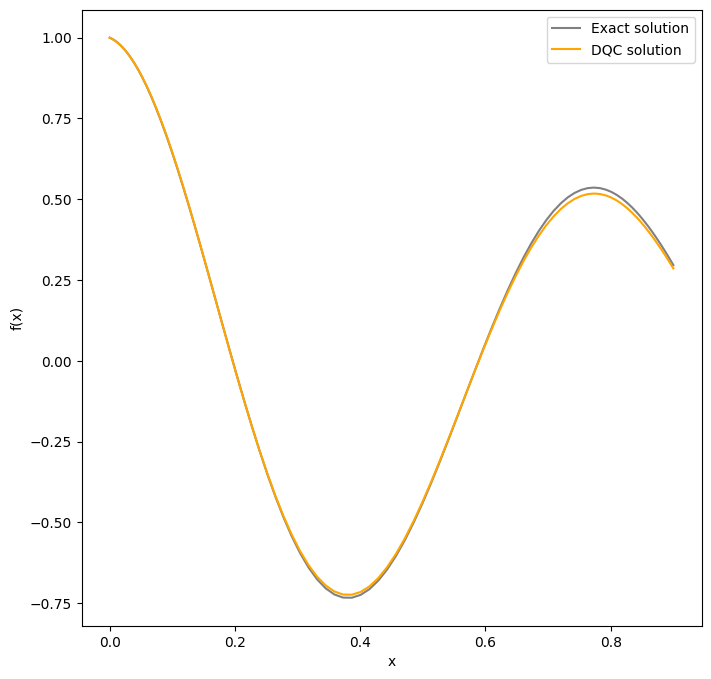

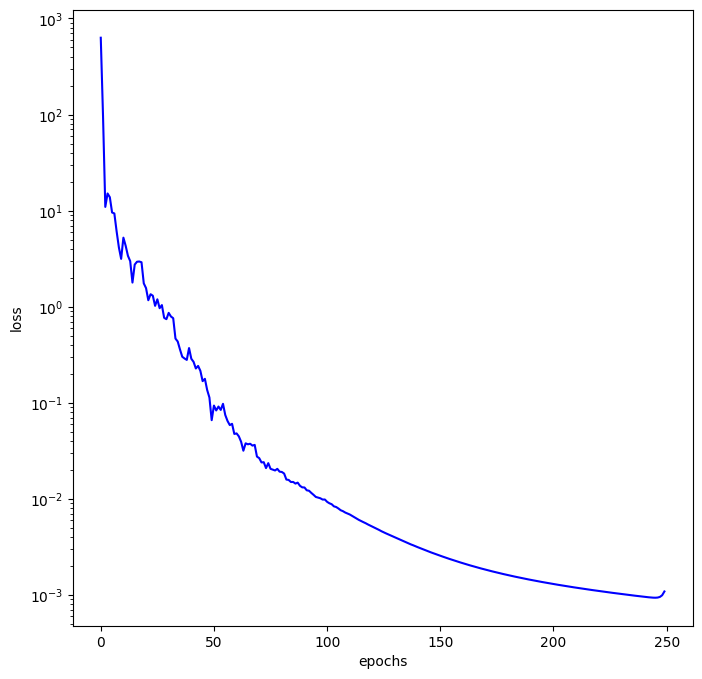

Seed id:  29
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.02149672 0.49909174 0.38190857 0.87095499 0.38535653 0.7284241
 0.4402065  0.82251589 0.4088419  0.88441041 0.77528763 0.66021445
 0.15772054 0.3541287  0.17619751 0.55634338 0.38603176 0.98370167
 0.31282165 0.13965676 0.63534149 0.15568865 0.19815437 0.8853724
 0.47760779 0.50377832 0.94094255 0.75474186 0.13213844 0.51776106
 0.57287875 0.0433311  0.49767775 0.39770331 0.72546348 0.66431738
 0.99286184 0.90520537 0.19867236 0.01175814 0.84169019 0.80704035
 0.45782472 0.22554864 0.16173531 0.1731322  0.49033833 0.69302473
 0.46903786 0.60302805 0.29791424 0.13551844 0.55143075 0.7708419
 0.08399278 0.12136128 0.57007429 0.27453591 0.26749121 0.47102385
 0.53623103 0.51113986 0.09998338 0.30865035 0.52921798 0.33261313
 0.09534174 0.38751445 0.3810271  0.95585588 0.09763594 0.57918152
 0.40334517 0.98550205 0.12734758 0.28683297 0.34108826 0.07248357
 0.71654835 0.1843008  0.26853601 0.8006324  0.60445248 0.3395638

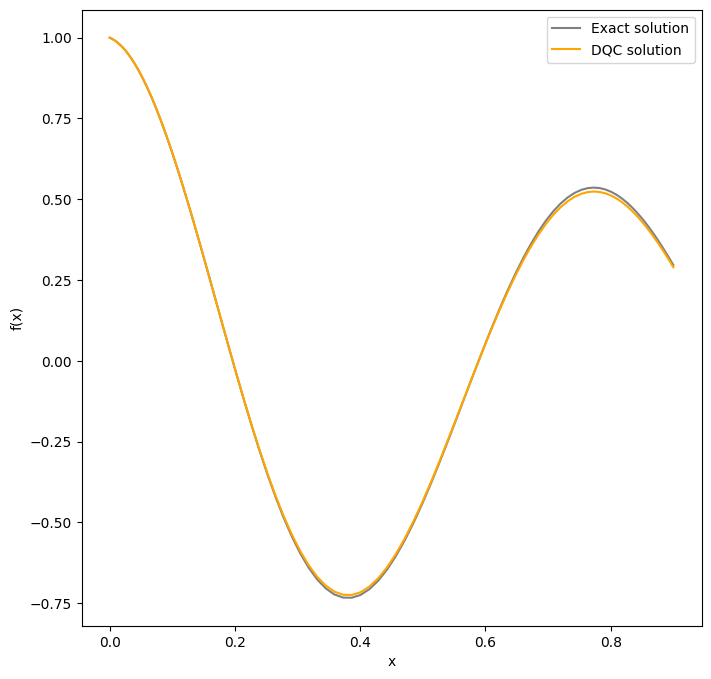

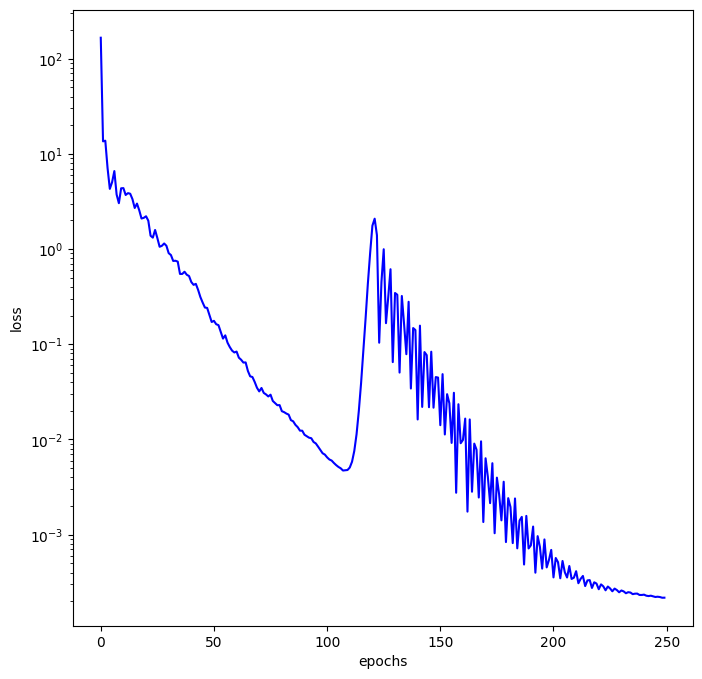

Seed id:  30
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.77350812 0.76536524 0.95413298 0.46423084 0.98662904 0.06495842
 0.87569391 0.64125773 0.59145647 0.80557412 0.98834453 0.40063552
 0.78719697 0.36006843 0.81515151 0.25530484 0.75932574 0.35458241
 0.83204908 0.32792298 0.32302673 0.50725541 0.82853958 0.18669963
 0.29022767 0.5240837  0.28789621 0.05661058 0.57933785 0.24529388
 0.43756701 0.74605823 0.49495145 0.55697383 0.21938916 0.12726255
 0.3663462  0.17841092 0.46746943 0.88673699 0.84075307 0.09042117
 0.45051355 0.76339601 0.11252464 0.62653358 0.69775156 0.57221381
 0.78462277 0.39865019 0.29035016 0.64718568 0.44659676 0.48532104
 0.51182689 0.1400747  0.18529075 0.47264708 0.35224271 0.07957508
 0.07487242 0.15115254 0.79668997 0.9620417  0.32427506 0.65760602
 0.21216631 0.59287622 0.17575733 0.97352273 0.28266659 0.21376557
 0.97242898 0.22138536 0.85262664 0.06130484 0.06165547 0.43247148
 0.98197294 0.48149704 0.4743858  0.87089268 0.85405561 0.7949

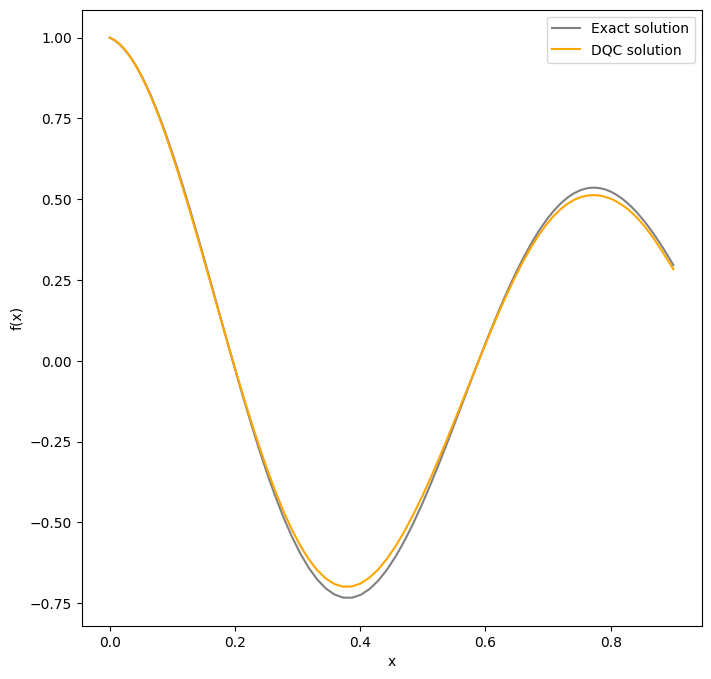

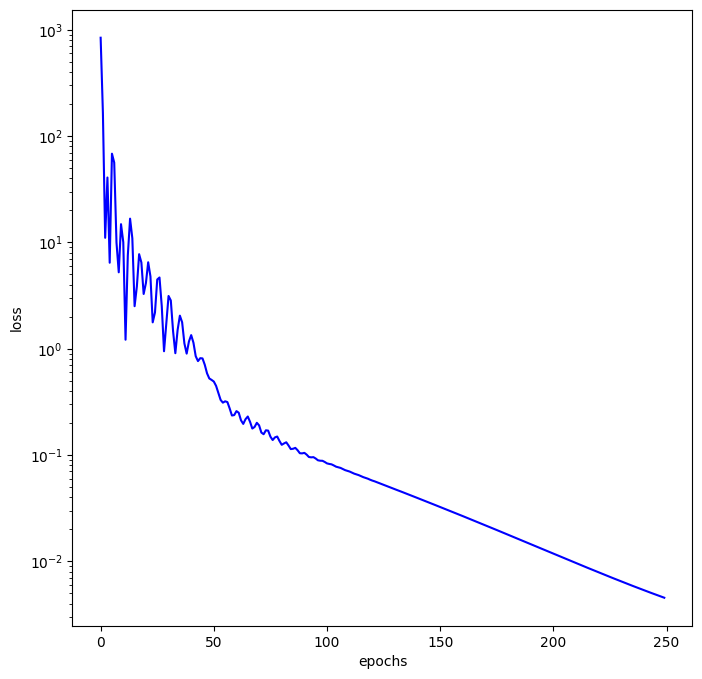

Seed id:  31
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.46198308 0.32042203 0.53296416 0.87714915 0.75473928 0.53321525
 0.5261383  0.16792705 0.69233372 0.43538605 0.66608129 0.99165503
 0.06159621 0.22073288 0.66338857 0.81233504 0.03942073 0.0818162
 0.92161288 0.7521458  0.30704323 0.29017123 0.35559568 0.19054436
 0.9644854  0.13149748 0.68910148 0.80985891 0.89685158 0.39616702
 0.55508916 0.96232352 0.70406468 0.13302185 0.82739745 0.80237403
 0.55822516 0.14164604 0.21091124 0.16366813 0.22851333 0.36782438
 0.00912817 0.06620844 0.98522654 0.1444981  0.25838911 0.59244541
 0.30820803 0.99019876 0.2223523  0.5895165  0.82580502 0.24461068
 0.14858809 0.66638613 0.07358554 0.64283861 0.50229495 0.41942893
 0.38201317 0.50879187 0.95259277 0.72476837 0.87116874 0.97066986
 0.17218191 0.54210527 0.23384981 0.89002906 0.22977382 0.97355839
 0.28517147 0.34856293 0.817043   0.34085291 0.71659008 0.11836662
 0.35959203 0.30654762 0.0488655  0.30561816 0.41408782 0.12148

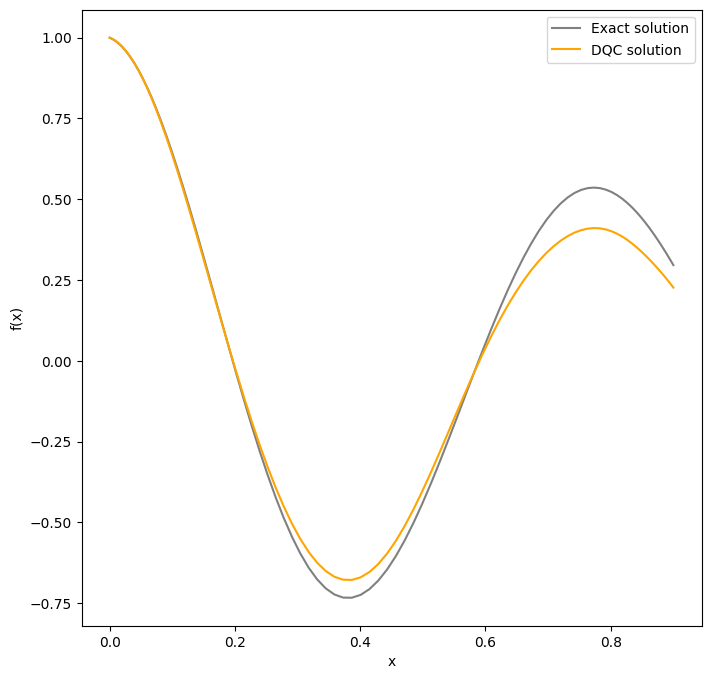

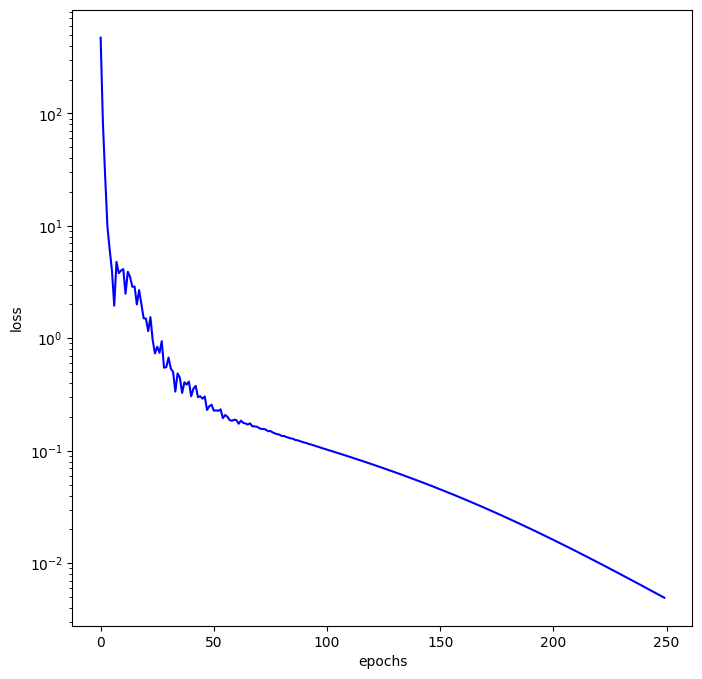

Seed id:  32
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [5.58640271e-01 6.39317203e-01 1.22505052e-01 6.80777592e-01
 1.13555239e-01 5.32332789e-01 9.00710563e-01 8.91896483e-01
 9.68988988e-01 3.83053983e-01 2.41527033e-01 7.06646011e-01
 2.17703523e-01 5.93163664e-01 6.84655667e-01 7.09405592e-01
 9.48058177e-01 4.85863594e-01 1.43982627e-02 7.60409345e-01
 4.93698826e-01 7.70237560e-01 7.89499895e-01 3.93545485e-01
 2.27803177e-02 7.42243735e-04 9.09795670e-01 3.80028351e-01
 1.78945138e-01 7.08050464e-02 5.90443967e-01 9.38180664e-01
 6.90051429e-01 6.37965843e-01 2.38224701e-01 5.53004751e-01
 8.79962381e-01 2.68456604e-01 7.41617972e-01 4.15775823e-01
 1.40574685e-01 6.94120327e-01 2.25947713e-01 8.92612860e-01
 6.30497825e-01 7.30122763e-01 4.99065142e-01 1.07192599e-01
 4.07428085e-01 9.05027739e-02 3.13573158e-01 9.73349865e-01
 7.93767124e-02 8.58146088e-02 7.12600769e-01 4.10492469e-01
 1.22481385e-01 7.56874091e-01 6.83474086e-01 5.05376682e-01
 5.26489462e-01 6.

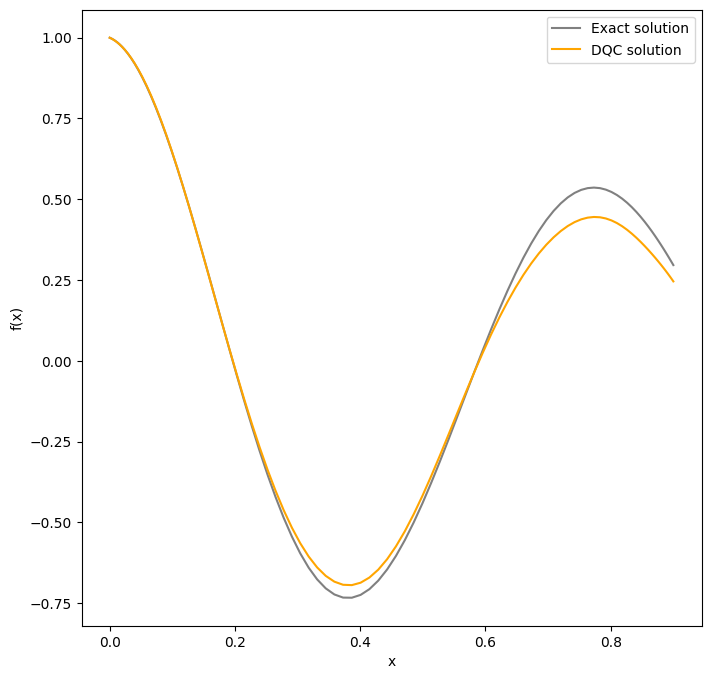

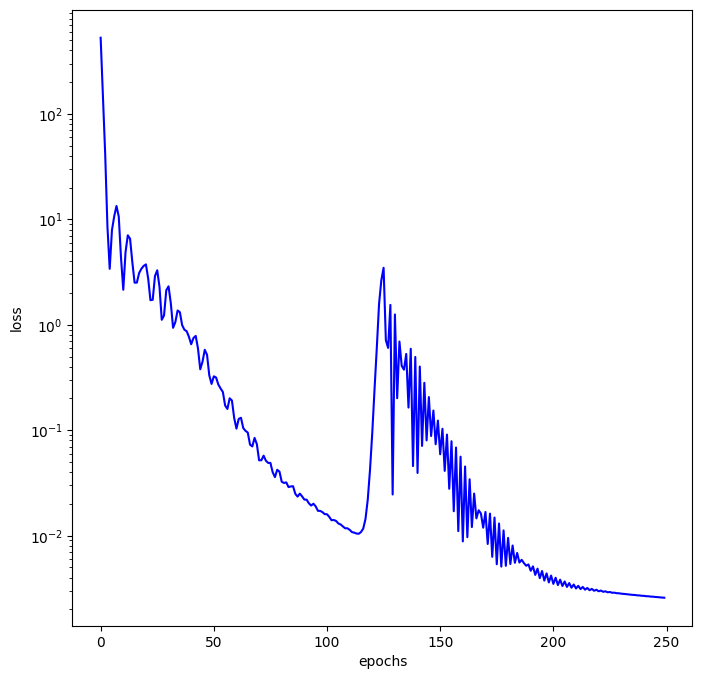

Seed id:  33
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.07415982 0.21144587 0.55331331 0.60649084 0.4050588  0.45841953
 0.97231086 0.08300442 0.18303169 0.23232408 0.88166027 0.88468657
 0.26481664 0.56244554 0.74243968 0.71432406 0.2477969  0.41454521
 0.70276174 0.90173648 0.5679312  0.2006079  0.82051756 0.80061772
 0.50563331 0.79012771 0.50031271 0.3577819  0.44992004 0.03673157
 0.40171432 0.81213502 0.26919705 0.90127081 0.38118795 0.2068668
 0.00163211 0.07939766 0.14746657 0.55025299 0.91930585 0.96605145
 0.60921525 0.51801639 0.41702556 0.14189673 0.61455512 0.13584925
 0.3800663  0.31569878 0.69894788 0.5842718  0.5071212  0.65519156
 0.70728118 0.06994067 0.07895192 0.99919431 0.39602049 0.46607538
 0.72611911 0.88194348 0.41314013 0.48207419 0.76965391 0.2484222
 0.49794297 0.50137122 0.01958245 0.75466862 0.99086881 0.39662601
 0.4480841  0.02207784 0.46923785 0.26651857 0.73512978 0.92037129
 0.59148668 0.04689402 0.19111871 0.97825963 0.64556084 0.036050

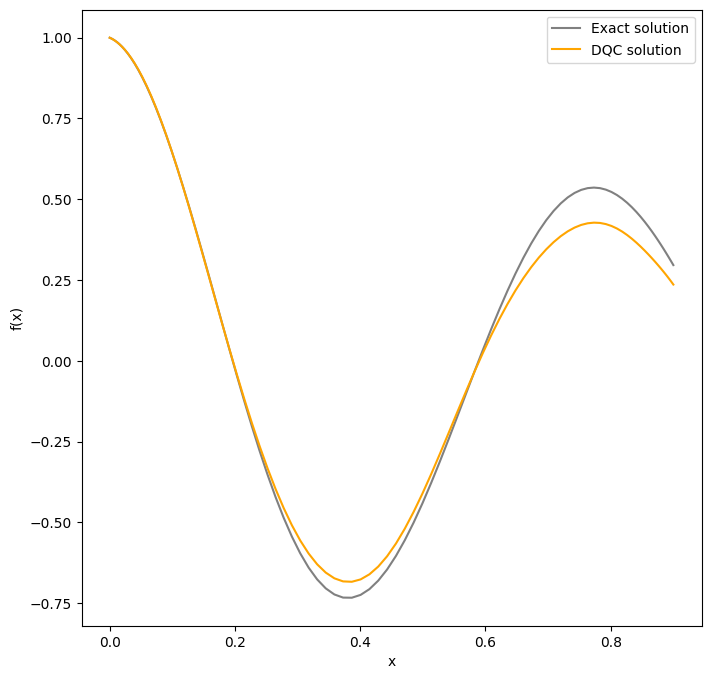

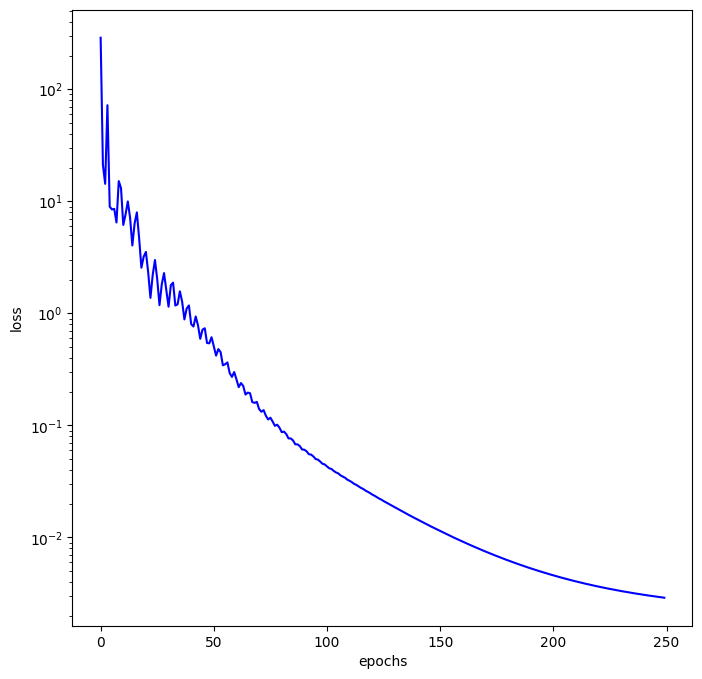

Seed id:  34
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.53286306 0.94526978 0.29243063 0.01767971 0.57798851 0.52856259
 0.21882717 0.88393117 0.9072639  0.42825378 0.42894292 0.39623662
 0.48183682 0.09419489 0.39634221 0.04666698 0.09091835 0.74568232
 0.1765509  0.59845593 0.31316157 0.23721783 0.16465961 0.51902632
 0.37616859 0.26525074 0.05953749 0.30706228 0.33377436 0.57192491
 0.36357931 0.51373321 0.84251902 0.24971616 0.12958222 0.21143634
 0.16795866 0.76680893 0.84278364 0.96978883 0.64875713 0.04249097
 0.54798216 0.38165586 0.66659282 0.01170139 0.49376156 0.775171
 0.13572983 0.17044081 0.09466834 0.25355775 0.9212801  0.1239749
 0.00165633 0.24279866 0.24544836 0.72564452 0.34885462 0.65522126
 0.84194875 0.03585294 0.92521038 0.25776172 0.41092779 0.55016
 0.22502411 0.86870765 0.69237149 0.23639774 0.07784209 0.46245018
 0.04206655 0.13587521 0.14363209 0.35352681 0.83917598 0.03008643
 0.64317558 0.81156097 0.84514249 0.78826771 0.78535694 0.3670175
 0

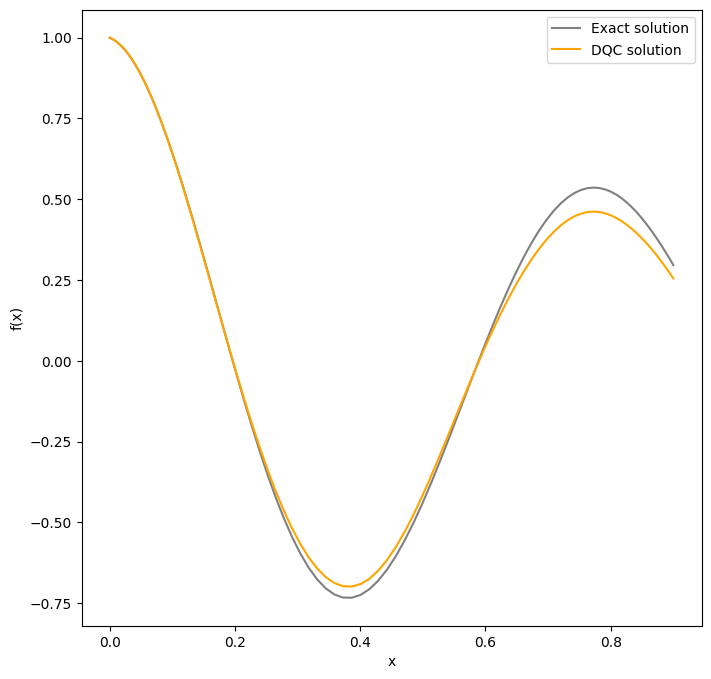

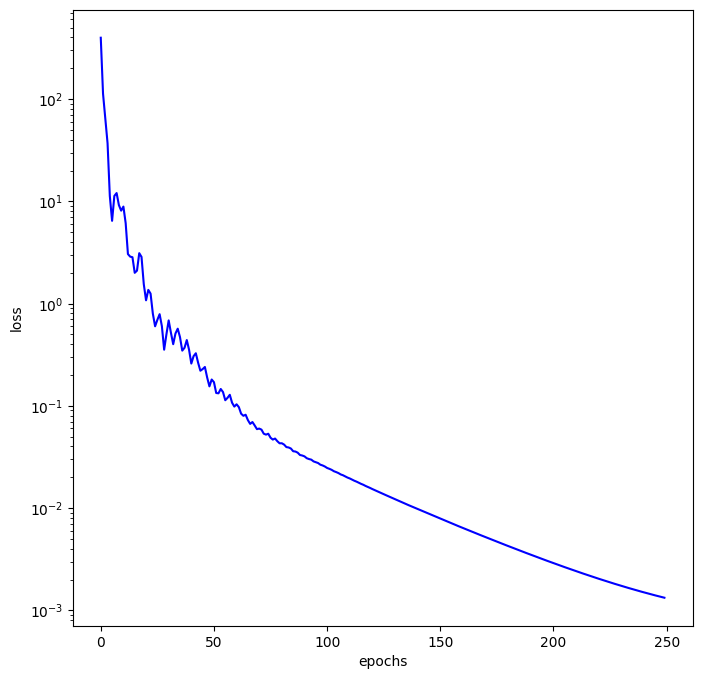

Seed id:  35
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.12211291 0.77647124 0.70353113 0.45069749 0.38364637 0.48812881
 0.14056228 0.47463041 0.90017176 0.15150769 0.93645118 0.26307392
 0.83845426 0.6707468  0.69455649 0.65825409 0.13648707 0.6527272
 0.87170247 0.9995298  0.26278719 0.80851717 0.94480085 0.04169876
 0.19745349 0.84985511 0.75089001 0.94905992 0.33708764 0.36619755
 0.61093096 0.61141134 0.7295323  0.03961369 0.8819     0.92906684
 0.92194648 0.59083469 0.32989494 0.19922263 0.13714122 0.76070131
 0.98757852 0.8410061  0.30123565 0.37254298 0.99027308 0.09805655
 0.65763416 0.15416898 0.71075221 0.82688214 0.7475518  0.12940016
 0.66749407 0.77563916 0.88561124 0.02000206 0.08286126 0.48030848
 0.54701592 0.97545949 0.64851771 0.93484396 0.5733299  0.45561515
 0.61976713 0.58797859 0.37412519 0.32488483 0.23988509 0.62770053
 0.95543695 0.38191521 0.95089433 0.30510044 0.08809425 0.72311087
 0.46788562 0.06986519 0.95071801 0.85448462 0.80864925 0.56618

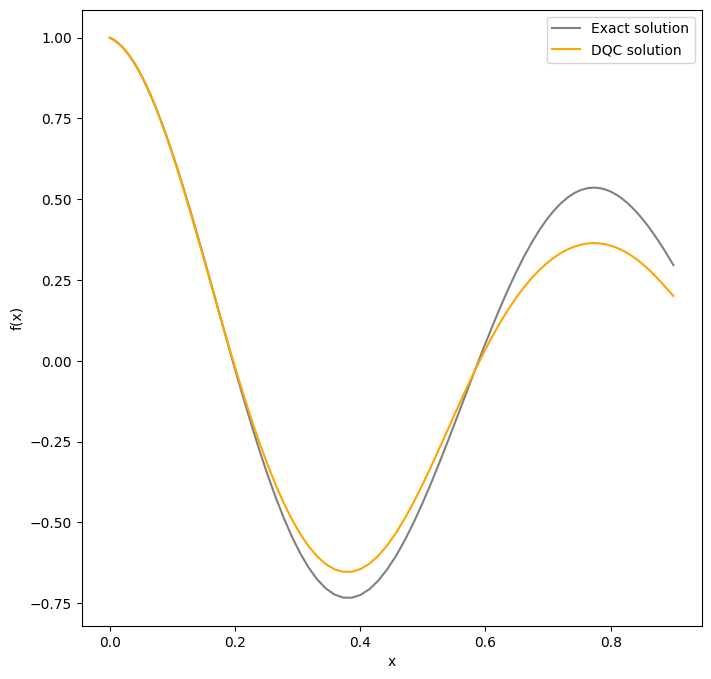

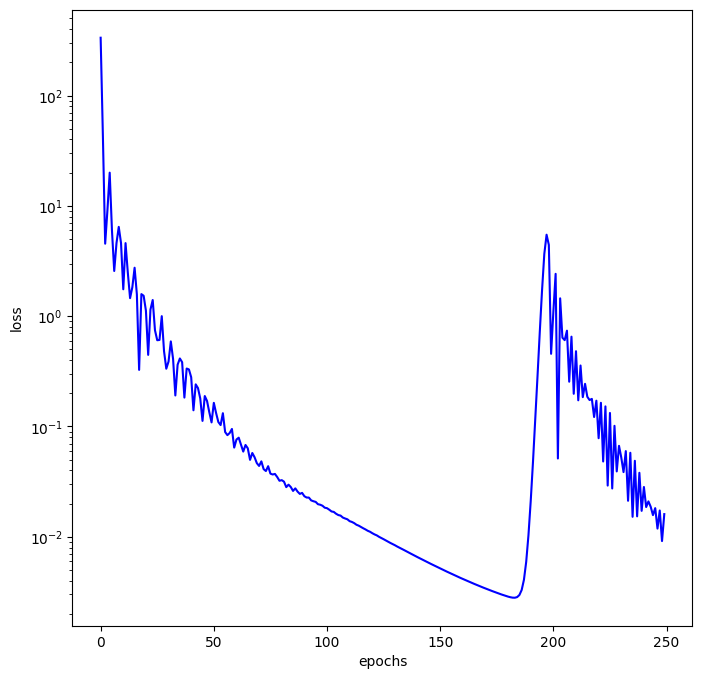

Seed id:  36
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.93410877 0.84138039 0.39195567 0.51447013 0.34236905 0.13916418
 0.86509906 0.50406999 0.78906255 0.26178867 0.44020654 0.15058528
 0.39027438 0.82302726 0.78018455 0.53551009 0.23406505 0.04265423
 0.52658396 0.8603079  0.85896377 0.70097081 0.36597987 0.12817946
 0.49027152 0.10450238 0.638042   0.30950825 0.21012211 0.04319213
 0.04485401 0.64851143 0.86873253 0.68364572 0.78364843 0.15608471
 0.34328888 0.32050209 0.53194285 0.3411441  0.44368007 0.82261412
 0.64465038 0.13605668 0.65662205 0.37944105 0.50041238 0.0374042
 0.85015322 0.64500467 0.77965287 0.81278376 0.39019537 0.65145819
 0.09283857 0.47303387 0.54728039 0.10784533 0.51808737 0.08595203
 0.69920618 0.87094176 0.28466728 0.38720342 0.91098777 0.12255685
 0.11544286 0.19803222 0.59938804 0.75136534 0.68044182 0.88172784
 0.01561135 0.67591368 0.65698417 0.778629   0.31521423 0.44372151
 0.02342528 0.43055575 0.23271723 0.08173573 0.44393285 0.20121

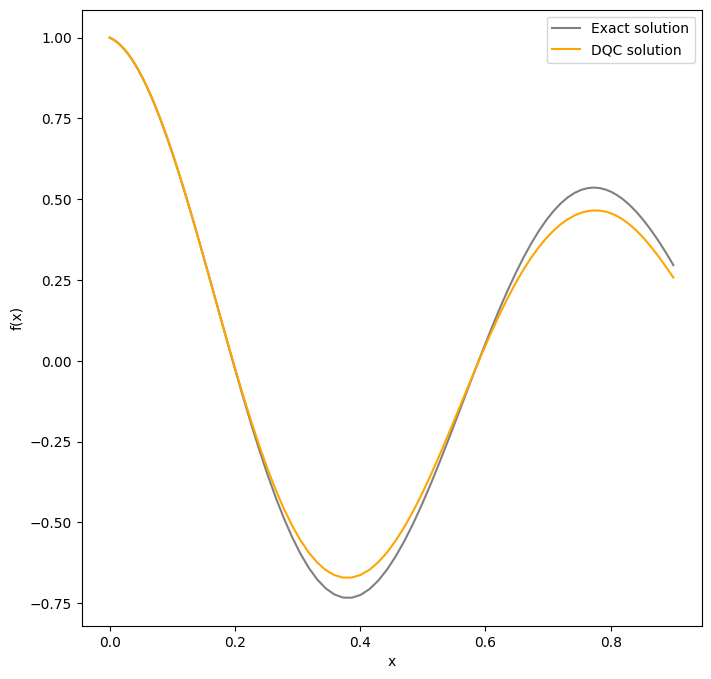

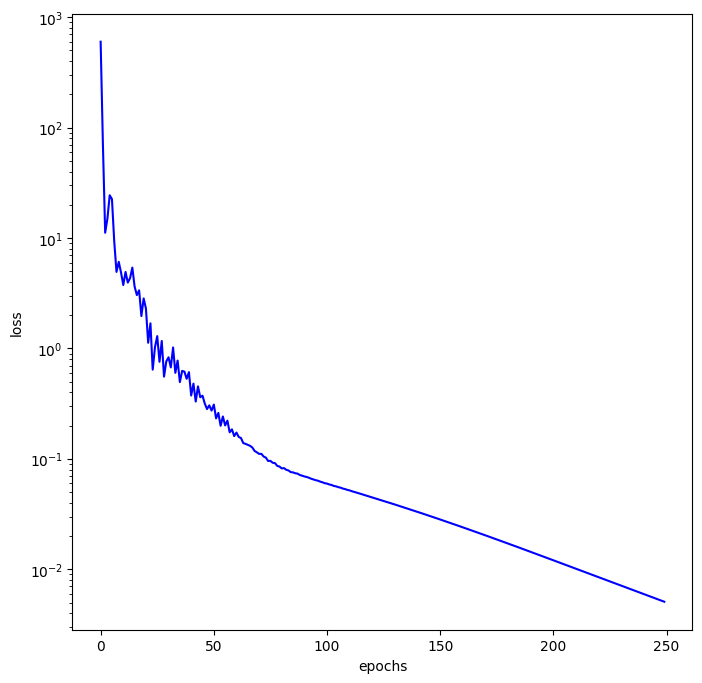

Seed id:  37
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.51181272 0.66748226 0.51496991 0.34348876 0.89084315 0.60174281
 0.23253782 0.2229999  0.52087391 0.05225487 0.90178543 0.4909178
 0.98419099 0.20440008 0.8928643  0.50031375 0.66884219 0.48639272
 0.70546103 0.18431982 0.25806874 0.12533676 0.93706321 0.3968995
 0.47268584 0.9338436  0.09528764 0.83083997 0.95189803 0.23979744
 0.32091295 0.89903009 0.92743053 0.82301683 0.63441299 0.67730853
 0.88776381 0.09294921 0.42241325 0.40431643 0.16943179 0.71568689
 0.5128904  0.50106302 0.69382269 0.78258723 0.95212319 0.00485287
 0.54565564 0.37163169 0.90569346 0.80757885 0.74160608 0.79275751
 0.67966139 0.51277785 0.73488891 0.26187707 0.18410541 0.21048019
 0.8684049  0.64649805 0.67214545 0.25145224 0.46042043 0.29200465
 0.2831225  0.77274942 0.72905215 0.19503743 0.15406351 0.07156842
 0.62464167 0.79377555 0.67434698 0.76410775 0.52053395 0.74218884
 0.13800342 0.56502162 0.85012686 0.41507807 0.79928654 0.963651

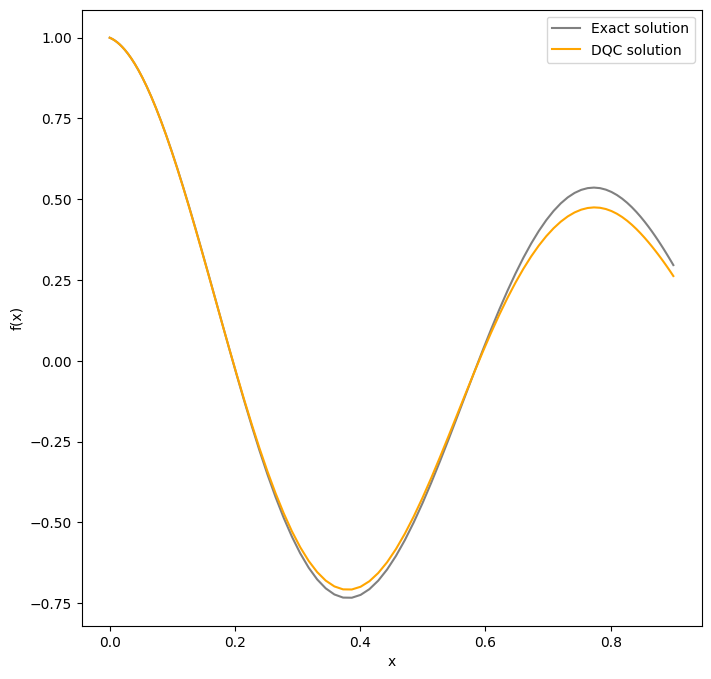

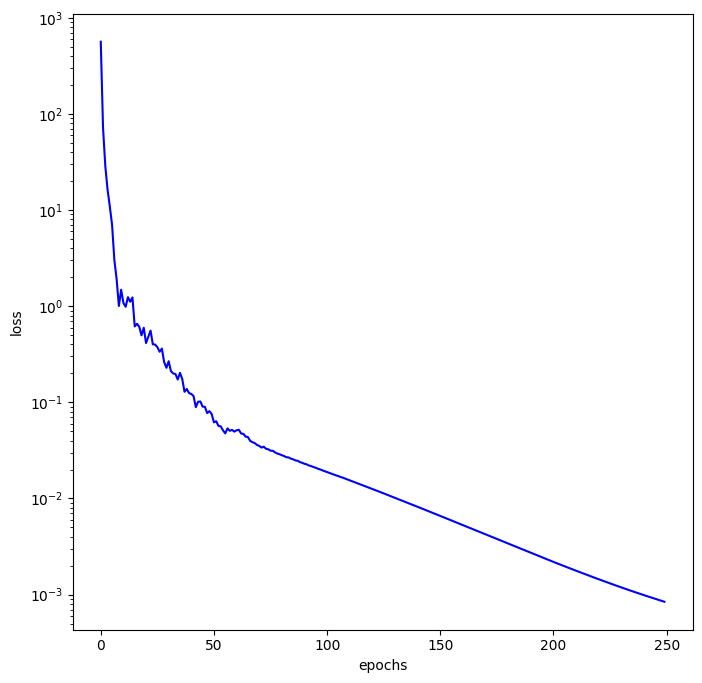

Seed id:  38
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.08038363 0.99926564 0.4066707  0.3348156  0.31666831 0.86187622
 0.44469794 0.46571332 0.08317553 0.55936595 0.12703981 0.57151162
 0.32420144 0.74605076 0.32314484 0.17929764 0.15273806 0.0965825
 0.68984411 0.09316457 0.48347726 0.53991158 0.40109    0.6623196
 0.78398809 0.66181972 0.89387989 0.15514613 0.45009162 0.5789862
 0.97751525 0.89456288 0.79710646 0.08022017 0.87230369 0.23143558
 0.60557494 0.23681952 0.60295768 0.2483125  0.25381391 0.12068369
 0.642987   0.48693881 0.16058292 0.15482573 0.96983054 0.9121873
 0.8186981  0.56816795 0.96255032 0.88221358 0.9837186  0.34927167
 0.17186871 0.02590896 0.93728594 0.23078026 0.15336715 0.7315706
 0.09814993 0.18896207 0.99652548 0.8270677  0.23619634 0.09628326
 0.42522484 0.86877692 0.06282414 0.34009899 0.27879069 0.9076213
 0.41984714 0.68246383 0.47065555 0.96645675 0.90976023 0.06619427
 0.91918626 0.26787438 0.85491177 0.1694269  0.32978819 0.06671814
 

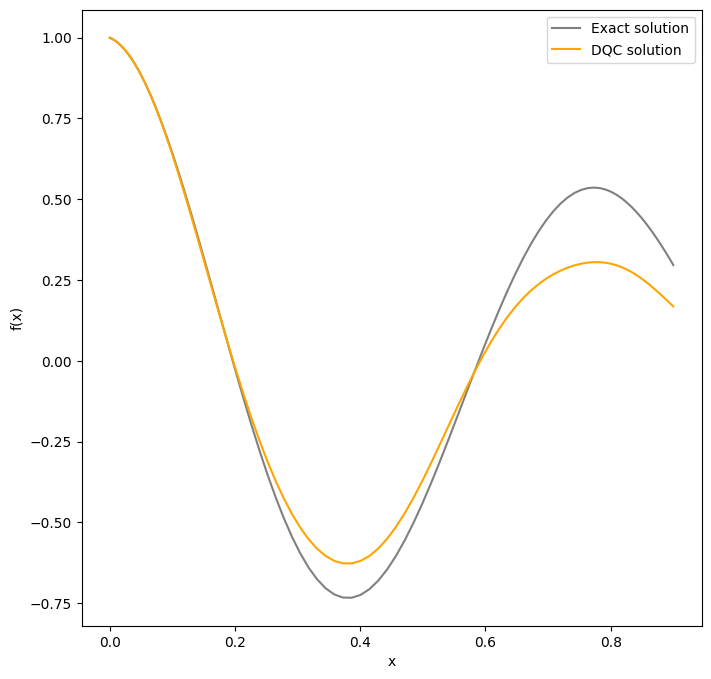

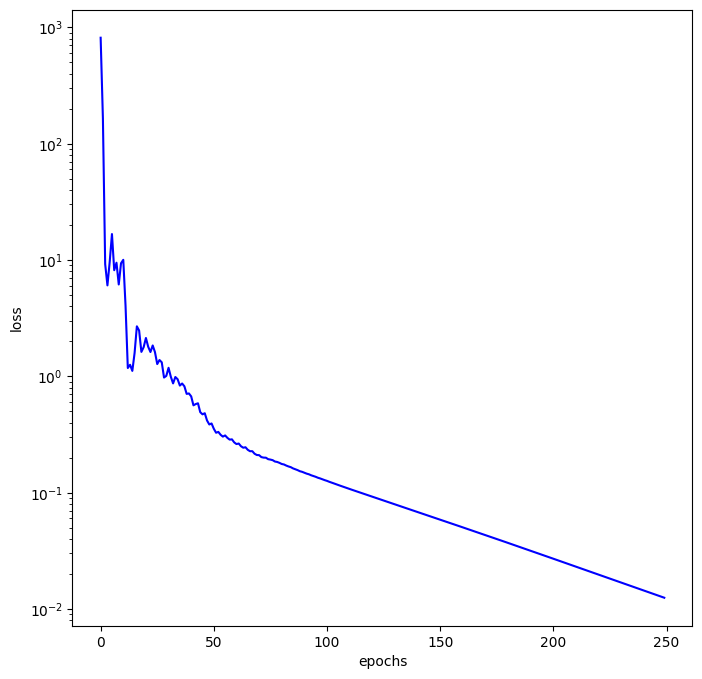

Seed id:  39
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.32233038 0.920691   0.87277135 0.03241964 0.8834427  0.31763223
 0.87989872 0.67184024 0.49294287 0.87306364 0.49725884 0.06567527
 0.55057589 0.28410421 0.88089506 0.66917441 0.70501459 0.68769276
 0.39374198 0.65331547 0.83473752 0.35145107 0.22617101 0.05281367
 0.26923592 0.48972232 0.01982474 0.68757686 0.00447661 0.1902747
 0.37138215 0.78622013 0.61279677 0.2325861  0.55448784 0.31423733
 0.19493024 0.95079019 0.45936537 0.95229358 0.33560189 0.73626144
 0.07792348 0.2831295  0.07149471 0.18019055 0.04766364 0.38640798
 0.54058236 0.61983725 0.32397374 0.18563549 0.67994695 0.84223076
 0.68840789 0.86464847 0.8789716  0.32106295 0.81609833 0.46282205
 0.09761818 0.96532654 0.91689634 0.42290577 0.24098083 0.92576217
 0.12980267 0.82759359 0.70029792 0.95788916 0.99352262 0.76181897
 0.27403387 0.53907734 0.28154672 0.47285768 0.85918538 0.37704651
 0.14674161 0.28138491 0.97905166 0.37915636 0.95465511 0.27865

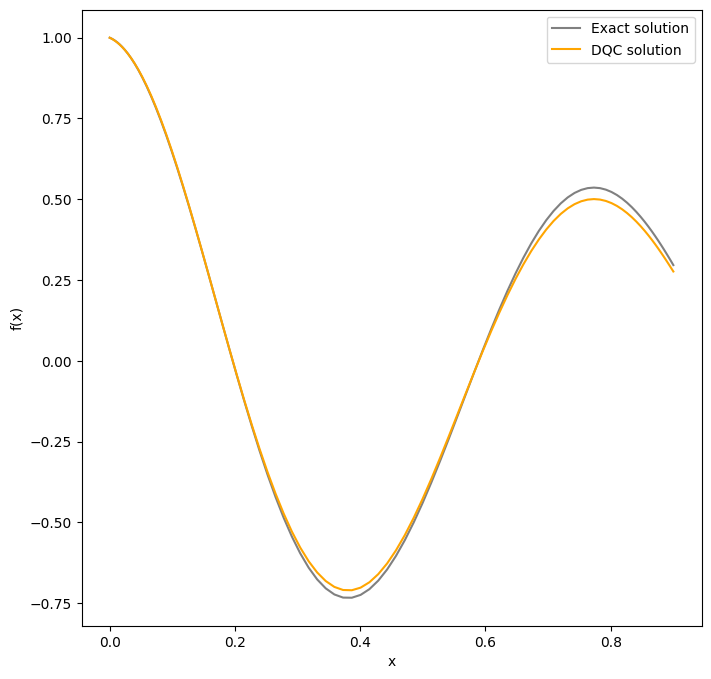

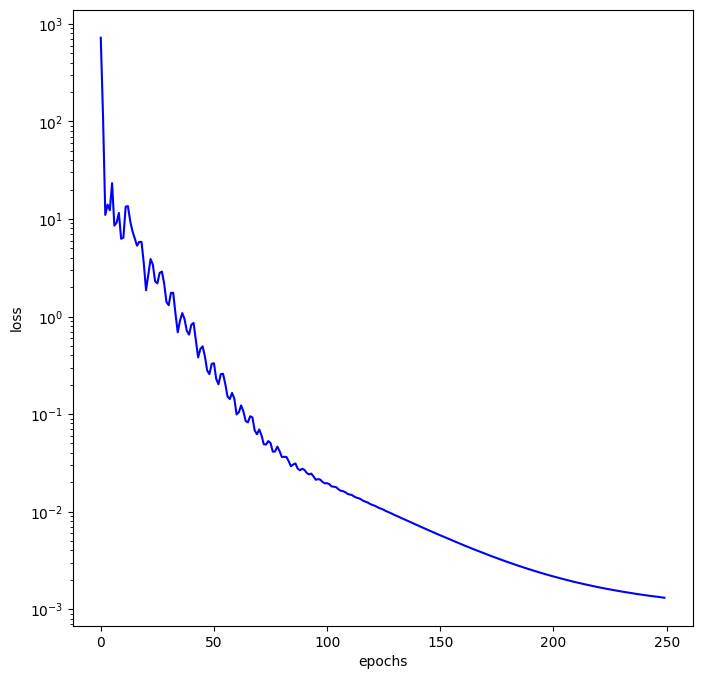

Seed id:  40
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.42036772 0.68078533 0.49779378 0.26715129 0.46153493 0.87876923
 0.52226859 0.2774716  0.77173952 0.03018763 0.47963201 0.53174529
 0.40813115 0.61044312 0.24675335 0.56549519 0.87803625 0.67518434
 0.78732042 0.57015944 0.90849959 0.72632523 0.31358886 0.80720762
 0.71132321 0.61792627 0.77876113 0.11999382 0.19182497 0.97276337
 0.75406753 0.46916024 0.6188211  0.17579193 0.39980282 0.91670904
 0.81770049 0.53988088 0.50544274 0.82576919 0.68104841 0.92097496
 0.33162373 0.34991971 0.72608616 0.42692392 0.05301034 0.53798827
 0.40437478 0.85603026 0.47951094 0.86707851 0.31649577 0.83193349
 0.54216874 0.57277138 0.7857703  0.30620373 0.17129114 0.89687609
 0.9408292  0.65462774 0.34899555 0.6772911  0.90880979 0.13541655
 0.05709977 0.01999668 0.10143928 0.5602543  0.13194303 0.92398628
 0.38754726 0.27885033 0.99095573 0.57227451 0.24084285 0.58320116
 0.30953938 0.17815374 0.02551255 0.75087    0.50364623 0.0594

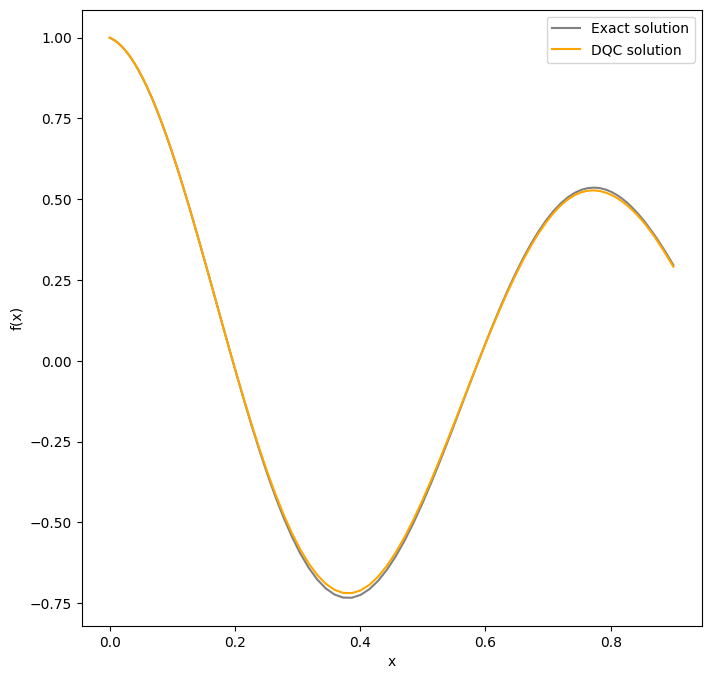

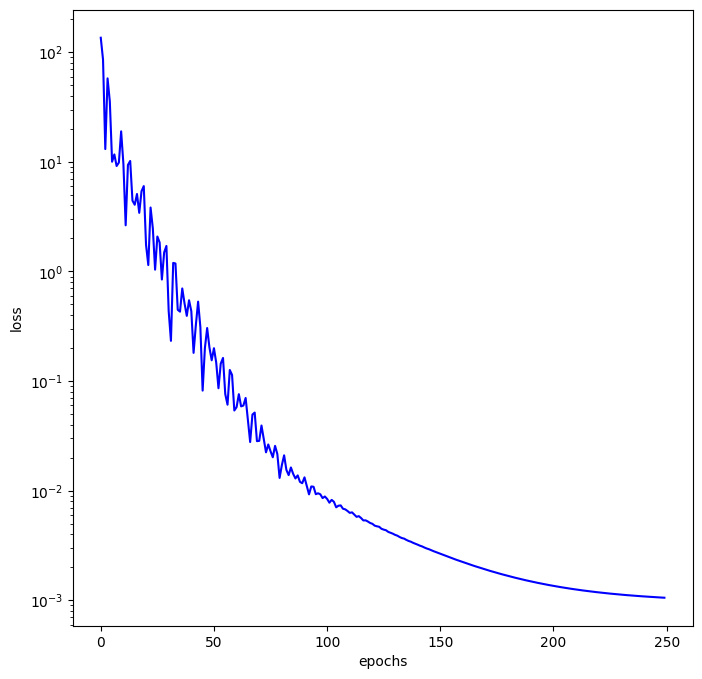

Seed id:  41
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.49351518 0.86088554 0.12716871 0.92396097 0.88858464 0.35753028
 0.66157602 0.12740663 0.8036943  0.91483882 0.8849535  0.132178
 0.53042374 0.7044299  0.44429795 0.3748543  0.32199721 0.75692273
 0.66696729 0.91311042 0.82373867 0.19071874 0.25364561 0.49603803
 0.79663765 0.13134252 0.13644282 0.07801285 0.15483198 0.43776547
 0.83062808 0.18499119 0.812583   0.78388906 0.49483161 0.76400443
 0.0442987  0.8601133  0.52483713 0.4713705  0.90711197 0.23446495
 0.7584337  0.27254133 0.41649368 0.87856584 0.31484269 0.9197383
 0.22797824 0.874825   0.5750361  0.096045   0.04407429 0.70656861
 0.77044951 0.3799163  0.71555111 0.8449109  0.58244112 0.19961486
 0.66939848 0.24129398 0.51780564 0.7240555  0.46509595 0.51288305
 0.82801189 0.36161074 0.65182194 0.94105081 0.70389067 0.17965063
 0.40478681 0.6072313  0.28480214 0.01064409 0.41874662 0.60548151
 0.97061807 0.51574199 0.69536235 0.56013167 0.41316883 0.7818928

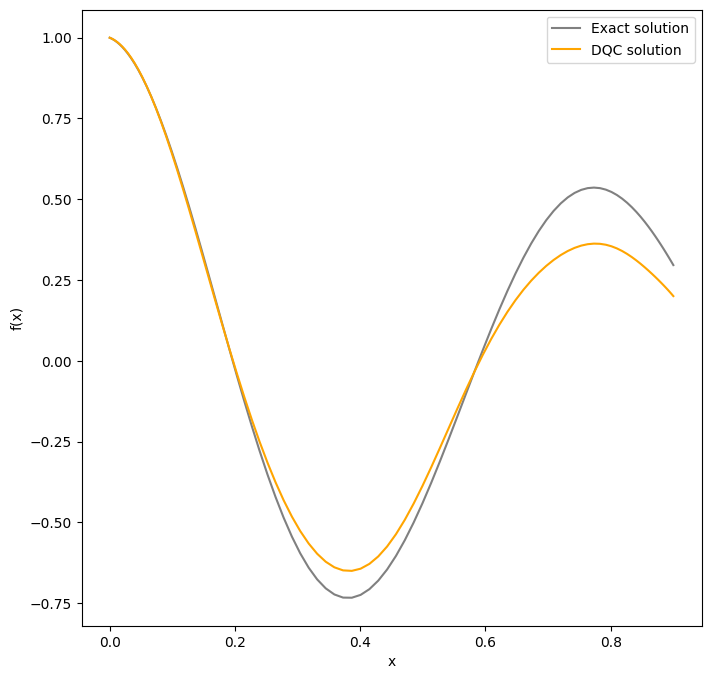

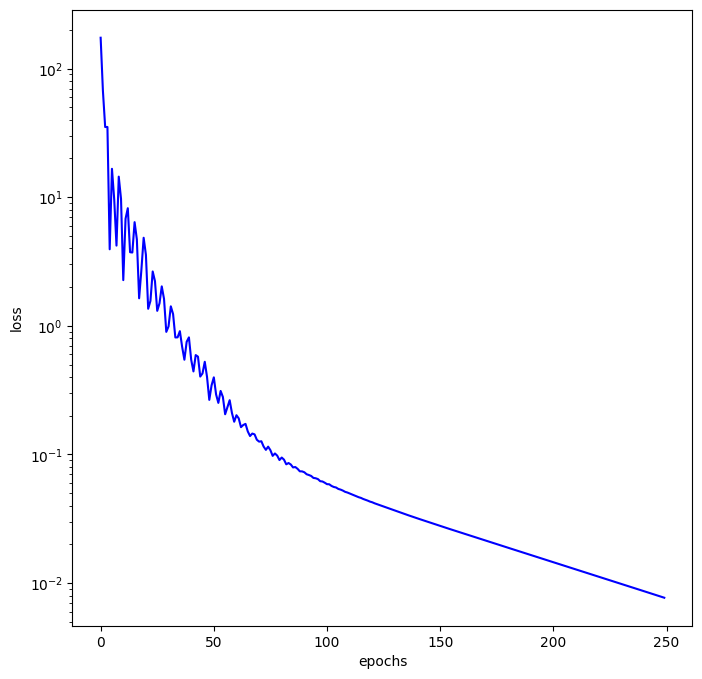

Seed id:  42
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.03381097 0.94118844 0.35594185 0.77374627 0.50067838 0.34071803
 0.95141914 0.81849555 0.57859392 0.3220337  0.37458782 0.81334163
 0.21749441 0.78205772 0.86523208 0.46670248 0.90942901 0.60782414
 0.89924409 0.7188595  0.80363509 0.47990756 0.18347045 0.65571241
 0.77733334 0.57546156 0.95332136 0.21725262 0.65576498 0.96395237
 0.42999732 0.2011471  0.49722366 0.81530156 0.27417038 0.52949538
 0.17898423 0.87001426 0.04664497 0.1016489  0.91681424 0.18555201
 0.84941052 0.14606805 0.11708808 0.35368414 0.04057731 0.58225645
 0.63172396 0.24166959 0.06617712 0.2533612  0.19222269 0.32765875
 0.27358173 0.66101224 0.23970037 0.0022784  0.10263085 0.07743941
 0.54916844 0.96399851 0.26499752 0.14064452 0.62208918 0.81132874
 0.89499042 0.40517541 0.876199   0.90424919 0.1443775  0.46510681
 0.90301977 0.57997793 0.81920055 0.95294974 0.73467685 0.89276203
 0.23392902 0.21514898 0.4832769  0.20085696 0.14005796 0.3223

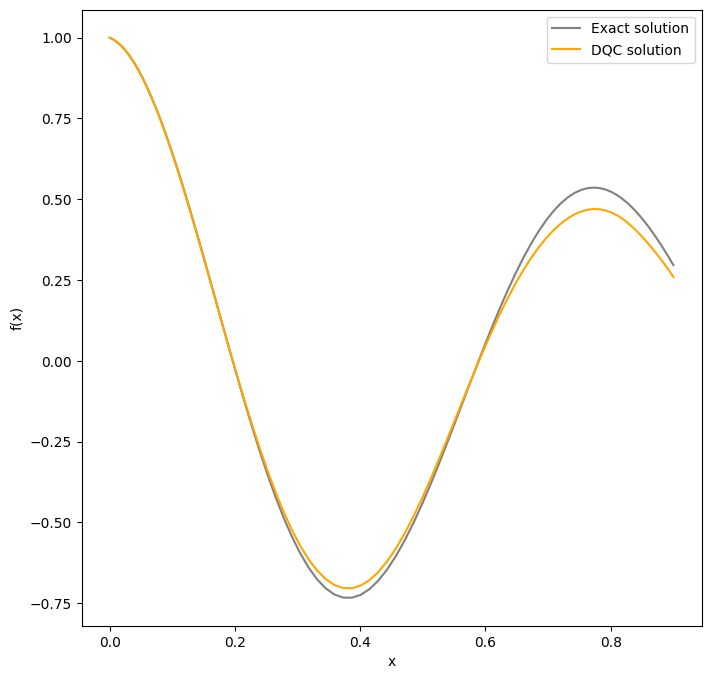

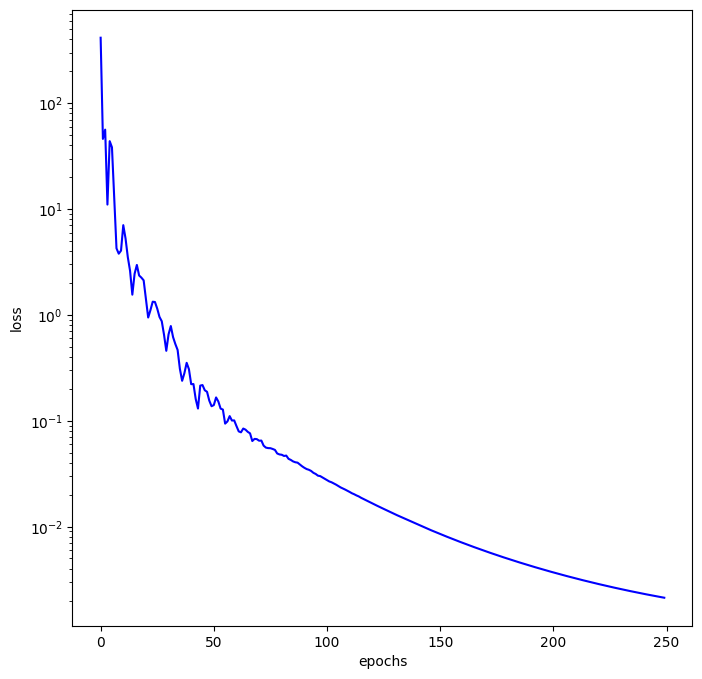

Seed id:  43
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.58908378 0.64763054 0.42842267 0.50783266 0.19451133 0.30785055
 0.51180928 0.35760112 0.01042606 0.52572935 0.29938058 0.23832665
 0.8144603  0.0769108  0.74053527 0.80480792 0.28885644 0.10298223
 0.36886528 0.08603453 0.40205029 0.63703222 0.04697431 0.02993219
 0.27654806 0.30993182 0.77086819 0.02815243 0.17568704 0.1859535
 0.29792252 0.85780011 0.90960578 0.08577337 0.80867296 0.49925684
 0.32404673 0.99518158 0.48320208 0.84660035 0.4064284  0.15105391
 0.71362684 0.91187735 0.94543793 0.08101493 0.60633971 0.11757411
 0.6860692  0.38162556 0.36022655 0.88456533 0.44419458 0.99286893
 0.6170663  0.46416892 0.41107074 0.04659939 0.00712601 0.43038445
 0.09246187 0.40783056 0.12138901 0.19301609 0.68181259 0.31482689
 0.4100038  0.31101966 0.10338451 0.83190742 0.45107479 0.13197416
 0.81780171 0.71176654 0.88731388 0.37680859 0.02206865 0.37710205
 0.60702355 0.76081116 0.89676084 0.44402314 0.69434971 0.18713

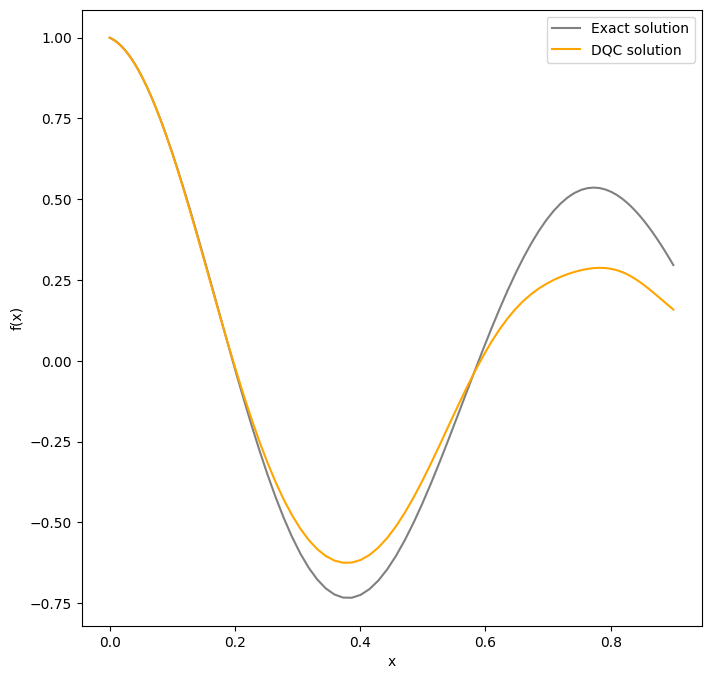

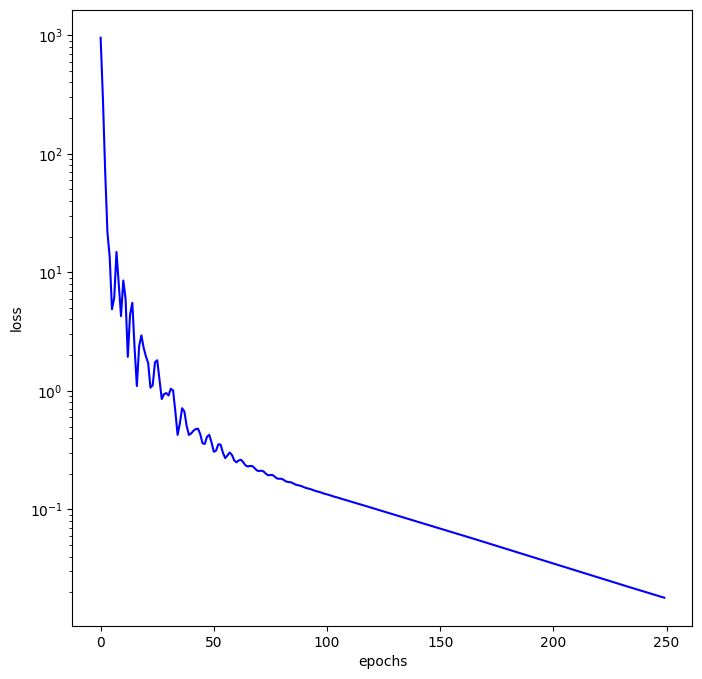

Seed id:  44
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.5754743  0.88288246 0.67935836 0.08459536 0.14180216 0.11900162
 0.5243941  0.44638475 0.66659117 0.805835   0.22078878 0.4398256
 0.23872689 0.68580136 0.21714529 0.14276299 0.74934211 0.86314442
 0.0047288  0.35061399 0.3395756  0.5921897  0.71060483 0.21877473
 0.48778009 0.54998811 0.63481143 0.65764523 0.96667501 0.83386981
 0.51763086 0.9463747  0.63176783 0.09790548 0.07708104 0.4221031
 0.86181055 0.92499517 0.54568087 0.67986626 0.1404073  0.687757
 0.12193078 0.79871307 0.7662738  0.08564675 0.03802459 0.84861408
 0.53322202 0.89839525 0.40145538 0.83884229 0.89076342 0.5198623
 0.25150747 0.98281632 0.24111397 0.23502402 0.59391337 0.31309574
 0.45250281 0.72037099 0.38492439 0.19608767 0.43100383 0.70281028
 0.4274444  0.99974667 0.18137537 0.18236932 0.71597501 0.24711082
 0.1149113  0.24920131 0.68195814 0.61104893 0.96398792 0.64369586
 0.05023102 0.3795857  0.60063019 0.44214617 0.05254413 0.69216232


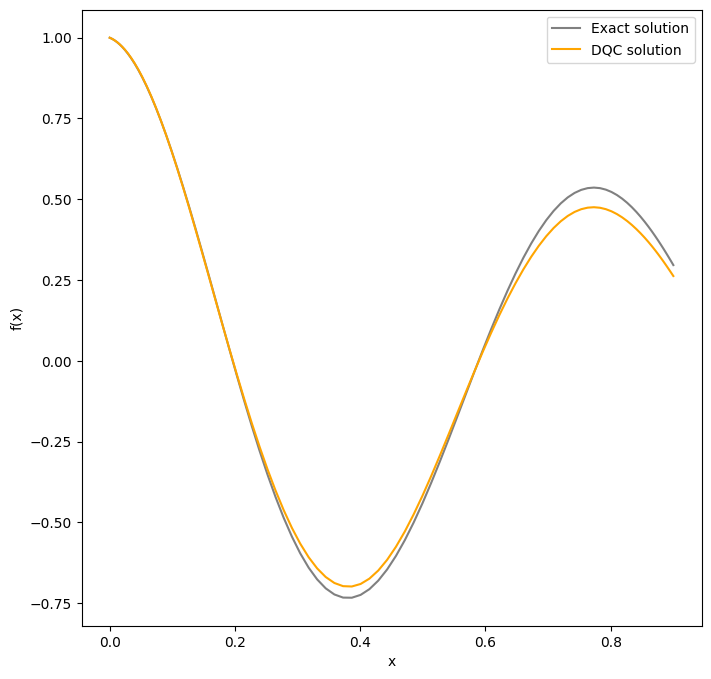

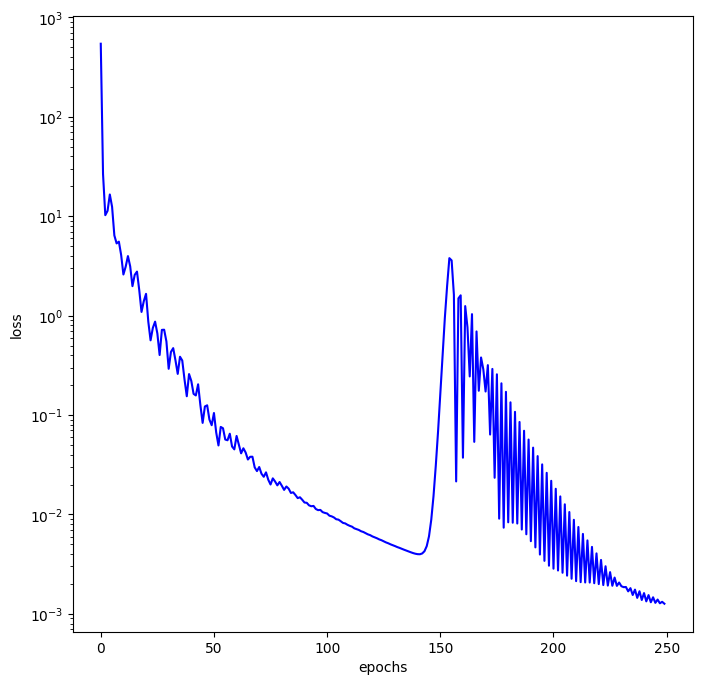

Seed id:  45
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.25884578 0.34223513 0.56722163 0.37788773 0.72824552 0.54982142
 0.90189732 0.51839749 0.86052859 0.44013984 0.42732477 0.86198327
 0.67734782 0.09476308 0.87288591 0.48132612 0.96466639 0.31397037
 0.87051598 0.72286447 0.3124249  0.63680194 0.41530377 0.08071345
 0.05806646 0.87085963 0.36065458 0.10821541 0.50513774 0.64981144
 0.08473865 0.35813189 0.96673271 0.32947579 0.3126039  0.5881922
 0.49941614 0.66952319 0.37202905 0.73489427 0.34532838 0.25690312
 0.91578569 0.88187564 0.00982122 0.76214238 0.00420564 0.5567531
 0.3650211  0.54902063 0.32255499 0.95218976 0.5717963  0.02690874
 0.14808789 0.82887278 0.34319294 0.32796322 0.9597979  0.40228881
 0.29850556 0.31375828 0.08534747 0.83666397 0.62127747 0.76075492
 0.00745167 0.73201069 0.09056907 0.60984656 0.55964369 0.91625668
 0.30201798 0.27730889 0.02401925 0.74719023 0.02716481 0.66986826
 0.46156533 0.6844137  0.33615792 0.84895346 0.81932845 0.905059

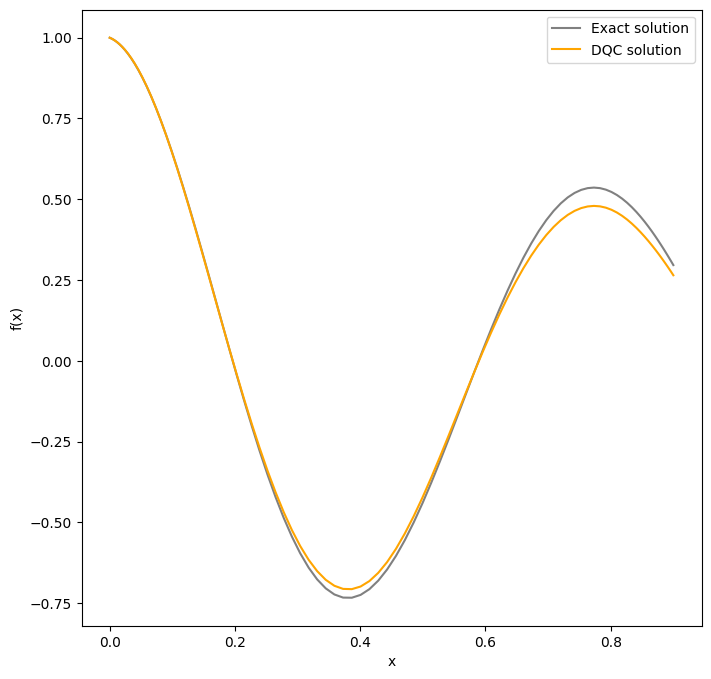

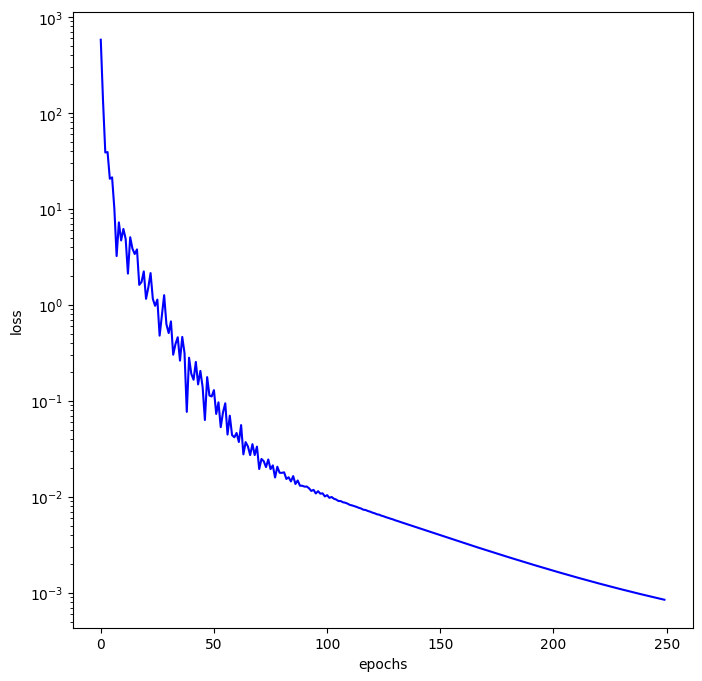

Seed id:  46
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.29666031 0.19953162 0.86788815 0.75925057 0.84018973 0.55036907
 0.12708047 0.47254467 0.82736625 0.60074437 0.66744396 0.64478662
 0.90904511 0.81632549 0.52844251 0.8570393  0.70727621 0.96207482
 0.74734664 0.51909501 0.09712991 0.53277233 0.91141597 0.80742182
 0.96016224 0.3958743  0.38996607 0.78252696 0.01821801 0.95405136
 0.20854371 0.74545519 0.62900439 0.75271105 0.20366593 0.01874364
 0.12609645 0.83522698 0.29998415 0.71670359 0.71564264 0.099372
 0.75620143 0.15206185 0.49001221 0.39638253 0.81495709 0.3217171
 0.66520441 0.45689525 0.13955738 0.22269204 0.39535046 0.5702051
 0.03742751 0.79205369 0.73278675 0.57353285 0.43974994 0.7416382
 0.48577312 0.65900527 0.65256258 0.29579889 0.33604342 0.36311988
 0.56088662 0.01377969 0.2911562  0.90132622 0.58623481 0.12601784
 0.05599024 0.15862443 0.16892696 0.12168041 0.57321064 0.28944621
 0.41795708 0.84361961 0.53229613 0.00556291 0.44869191 0.09160755


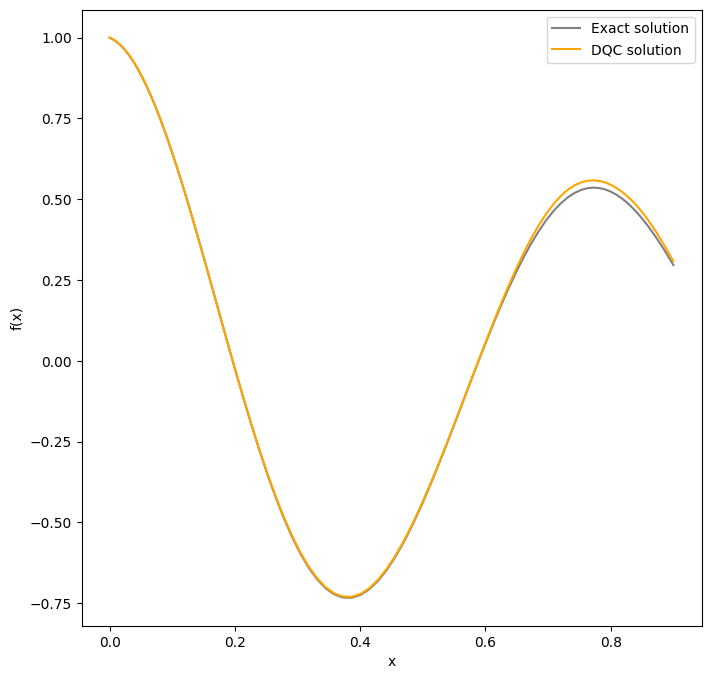

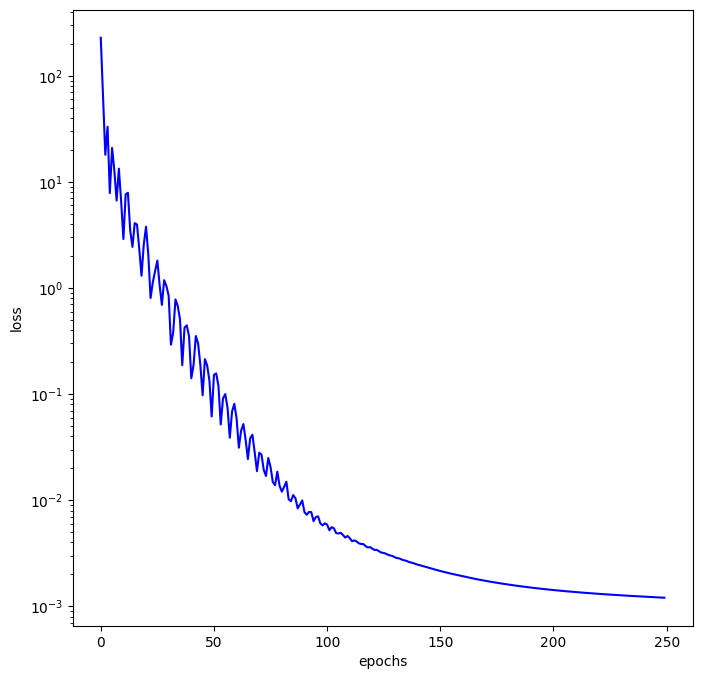

Seed id:  47
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.96874106 0.8409291  0.61254352 0.58303879 0.30888967 0.54473647
 0.75098219 0.97591711 0.82025585 0.79610439 0.11756396 0.85958158
 0.08830207 0.95700401 0.45685926 0.57699012 0.45228986 0.76148292
 0.26025974 0.9842621  0.63377808 0.66232532 0.69447292 0.99428573
 0.16823962 0.1839584  0.30452419 0.86101866 0.68565776 0.51140205
 0.19986092 0.5240612  0.632539   0.67813498 0.82512444 0.4491721
 0.92133191 0.70905879 0.50480707 0.47813678 0.78582144 0.32867007
 0.57317198 0.61481522 0.83106755 0.55724351 0.37505427 0.44247416
 0.01199557 0.18874101 0.94120835 0.84582179 0.49897442 0.91319786
 0.90862447 0.73470557 0.7459018  0.44215185 0.28615715 0.82364219
 0.6466614  0.0510037  0.79984929 0.14506818 0.08013307 0.96130557
 0.83951323 0.60276415 0.5812495  0.25301988 0.62209733 0.87683042
 0.27200299 0.41403006 0.51742282 0.32377867 0.50827086 0.83577984
 0.33856342 0.89699151 0.08421397 0.73405113 0.16195436 0.92709

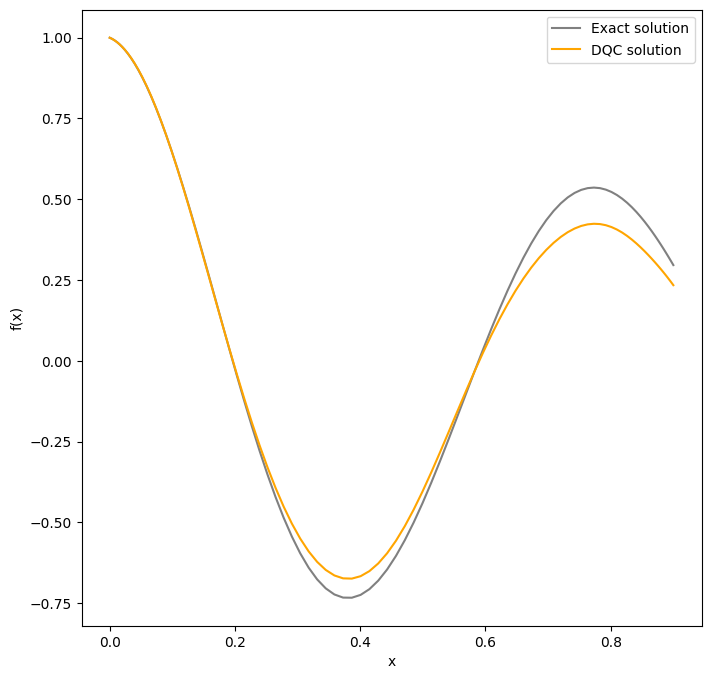

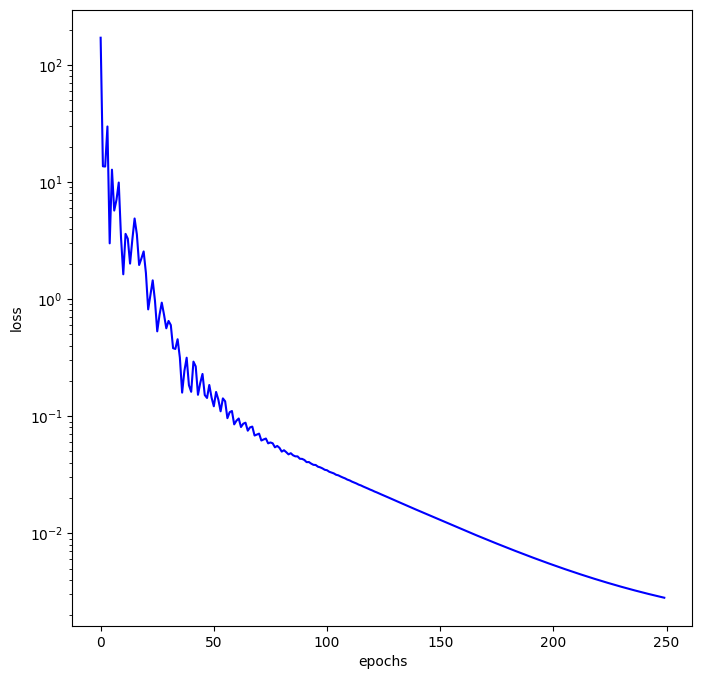

Seed id:  48
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.59595687 0.91429954 0.50511387 0.83858902 0.62939467 0.53023881
 0.98704291 0.59110888 0.62566023 0.75203506 0.34076139 0.50310384
 0.67480882 0.65415928 0.52847663 0.53694756 0.47007724 0.42604315
 0.02739102 0.52538407 0.13009134 0.25357164 0.78515658 0.04487381
 0.03202704 0.70871108 0.47723788 0.00725872 0.76832242 0.70935815
 0.67708505 0.86471176 0.43245793 0.44611212 0.83277259 0.92209214
 0.60502731 0.03717388 0.7356339  0.82803106 0.88672551 0.52165124
 0.16737068 0.38806878 0.99096518 0.25621949 0.5916879  0.25432219
 0.6903296  0.69365724 0.43697278 0.78280261 0.04279025 0.94590142
 0.26559491 0.28055547 0.9782638  0.83883135 0.18341551 0.82830447
 0.61404063 0.86807935 0.32381108 0.86068741 0.30331652 0.06818487
 0.18924586 0.33677425 0.75585691 0.39950056 0.3143696  0.46486642
 0.86827355 0.698548   0.82211748 0.51395399 0.11449181 0.19912178
 0.74561464 0.14995513 0.71906735 0.39826444 0.36651047 0.6198

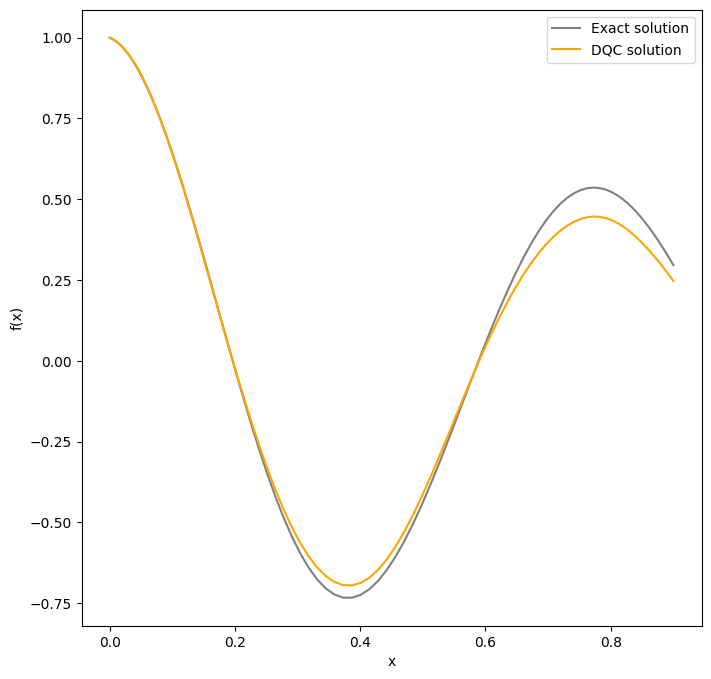

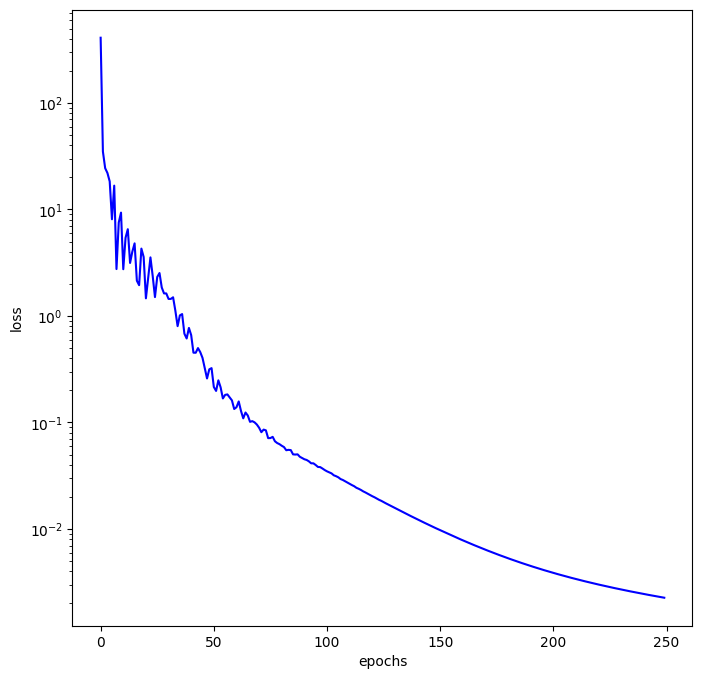

Seed id:  49
Learning rate:  0.1
k = 0.1
lamb = 8
Initial angles:  [0.87132583 0.6904629  0.25911266 0.54020292 0.15093117 0.2559189
 0.15868141 0.64579762 0.81248483 0.11483201 0.67457276 0.86478605
 0.31787118 0.00653679 0.85958595 0.02304735 0.5819679  0.83927574
 0.76414741 0.58208983 0.82530608 0.43458036 0.33835941 0.06989507
 0.4943628  0.67667882 0.8420043  0.60619917 0.49685557 0.55229653
 0.19151541 0.06823379 0.93503584 0.65555044 0.2000555  0.43486752
 0.22558452 0.61322918 0.99662107 0.99726907 0.5646584  0.77745792
 0.90270116 0.86466155 0.97106526 0.71668837 0.99130355 0.06663181
 0.25683568 0.00414503 0.798452   0.54121386 0.62486705 0.18224691
 0.73830093 0.44749131 0.7014738  0.24123452 0.83031697 0.87025221
 0.37616355 0.68572836 0.61637966 0.9237134  0.93509306 0.09598665
 0.0273837  0.74213356 0.17399701 0.73267151 0.53375475 0.63547433
 0.50819682 0.57951995 0.24385311 0.06799612 0.95261833 0.47184851
 0.72659875 0.44784647 0.84741604 0.97632203 0.09169855 0.99007

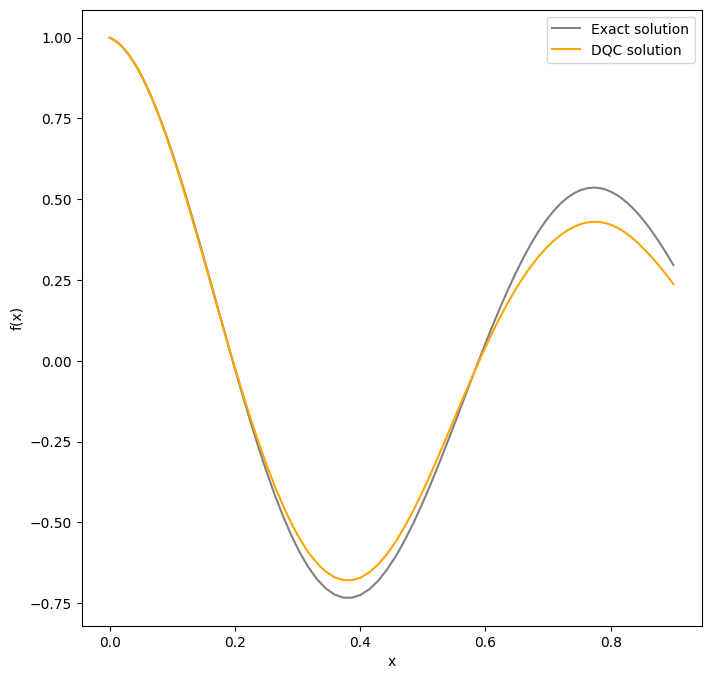

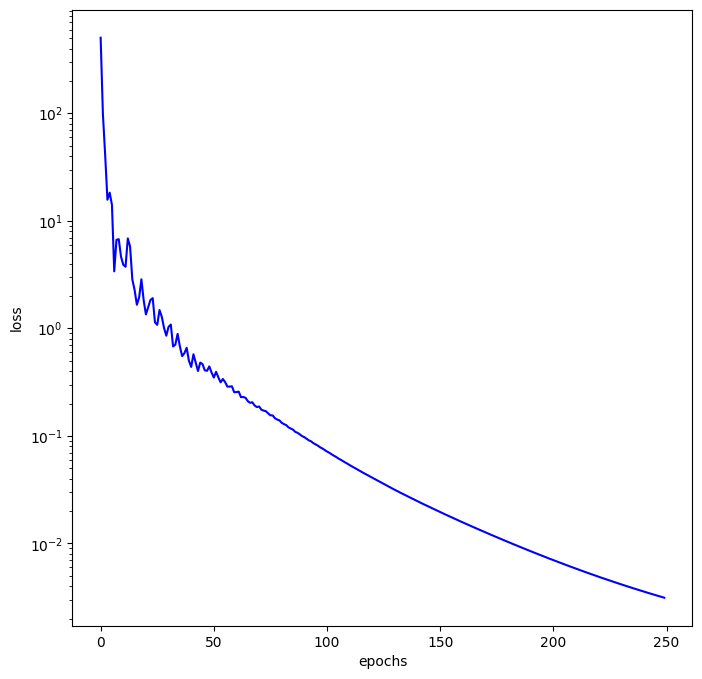

In [4]:
L_f = []
L_q = []
all_functions = []
all_losses = []
for state in range(len(RANDOM_STATES)):
    for lr in LEARNING_RATES:
        for k in K:
            for lamb in LAMBDA:
                print("Seed id: ",state)
                print("Learning rate: ",lr)
                print("k =",k)
                print("lamb =",lamb)


                ## SETTINGS ## 
                N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS = 6, 5, lr, N_POINTS
                b = 1

                chebT = feature_map(n_qubits=N_QUBITS, param="x", op=RY, fm_type = BasisSet.CHEBYSHEV, reupload_scaling = ReuploadScaling.TOWER)
                fm = chebT

                torch.manual_seed(RANDOM_STATES[state])
                ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH, operations=[RZ, RX, RZ])

                obs = total_magnetization(N_QUBITS) 
                 
                circuit = QuantumCircuit(N_QUBITS, chain(fm, ansatz))
                model = QNN(circuit=circuit, observable=obs, inputs=["x"])

                inital_vparams = model.vparams
                #print("Inital params: ",inital_vparams)
                sorted_keys = sorted(inital_vparams.keys(), key=lambda k: int(k.split('_')[1]))
                inital_thetas = np.array([inital_vparams[k].item() for k in sorted_keys])
                inital_thetas = np.reshape(inital_thetas, (DEPTH, 3, N_QUBITS))
                Theta_init = np.transpose(inital_thetas, (2, 0, 1))
                theta_init = Theta_init.reshape(-1)
                print("Initial angles: ",theta_init)
                #check
                #Theta_init = np.reshape(theta_init, (N_QUBITS,DEPTH,3))
                #print("Theta: ",Theta_init)

                def loss_fn(inputs: torch.tensor, outputs: torch.tensor) -> torch.tensor:
                    boundary_loss = b*torch.ones_like(inputs) - model(torch.zeros_like(inputs))
                    outputs = outputs + boundary_loss

                    df = grad(outputs=outputs.sum(), inputs=inputs, create_graph=True)[0] 
                    f = lamb*outputs*(k+torch.tan(lamb*inputs))
                    ode_loss = (df+f).pow(2)
        
                    return ode_loss.mean(), outputs 


                ## TRAINING ##
                epochs = 250
                opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
                losses = []
                for epoch in range(epochs):
                    opt.zero_grad()
                 
                    cp = cp_fixed.clone().detach().requires_grad_(True)
                    
                    loss, f = loss_fn(inputs=cp, outputs=model(cp))
                    losses.append(loss.item())
                
                    if (epoch % 50 == 0):
                        u = torch.exp(-k*lamb*cp.detach())*torch.cos(lamb*cp.detach()).detach().numpy()  
                        l_q = torch.sum((u-f.detach().numpy())**2)/N_POINTS
                        print(epoch, (loss.item(), l_q.item()))

                    loss.backward()
                    opt.step()


                ## TESTING ## 
                const = b*torch.ones_like(sample_points) - torch.exp(-k*lamb*torch.zeros_like(sample_points).detach())*torch.cos(lamb*torch.zeros_like(sample_points).detach())
                #print(const)
                analytic_sol = torch.exp(-k*lamb*sample_points.detach())*torch.cos(lamb*sample_points.detach() + const).detach().numpy()#+ const=0

                dqc_sol = (model(sample_points) + (b*torch.ones_like(sample_points)-model(torch.zeros_like(sample_points)))).detach().numpy() 
                x_data = sample_points.detach().numpy()

                plt.figure(figsize=(8, 8))
                plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
                plt.plot(x_data, dqc_sol.flatten(), color="orange", label="DQC solution")
                plt.xlabel("x")
                plt.ylabel("f(x)")
                plt.legend()
                #plt.savefig(f"f_x_{state}_{lr}_{k}_{lamb}.png")
                plt.show()

                plt.figure(figsize=(8, 8))
                plt.plot(losses, color="blue")
                plt.xlabel("epochs")
                plt.ylabel("loss")
                plt.yscale('log')
                #plt.savefig(f"losses_{state}_{lr}_{k}_{lamb}.png")
                plt.show()
                
                L_f.append(losses[-1])
                L_q.append(torch.sum((analytic_sol-dqc_sol)**2) /len(sample_points))
                all_functions.append(dqc_sol.flatten())
                all_losses.append(losses)

In [5]:
print("L_f: ",L_f)
print()
L_q = [q.item() for q in L_q]
print("L_q: ",L_q)

L_f:  [0.004118028034019506, 0.005413650540694972, 0.001235490146415451, 0.0003220457912815727, 0.005315053438210512, 0.0011605795564644612, 0.0003222793803588359, 0.01011661836381111, 0.0007112194400509404, 0.0025181402385041083, 0.0025498274060711235, 2.97106408365434, 0.0032495061715606386, 0.0031034913048446997, 0.020225054731096724, 0.006760898851988375, 0.014112080476421655, 0.00395660324786409, 0.008540876363305137, 0.0033185891785637496, 0.02770959052189224, 0.0002845214999064847, 0.001320723023154523, 0.0026182147753067543, 0.0005388979848432783, 0.006162979435384825, 0.0016675113695370169, 0.04636036743395648, 0.0010881880908919792, 0.0002178301738622547, 0.004544241053424085, 0.004930184054709694, 0.0025768122319411364, 0.002899479877178994, 0.0013270595046621359, 0.01605934690630405, 0.0050951936237056406, 0.0008434057742774852, 0.012467703273819191, 0.0013088275415002635, 0.001057671149498967, 0.007692623012354488, 0.00212722678071412, 0.01799039436815621, 0.00126508521598

### Best solutions

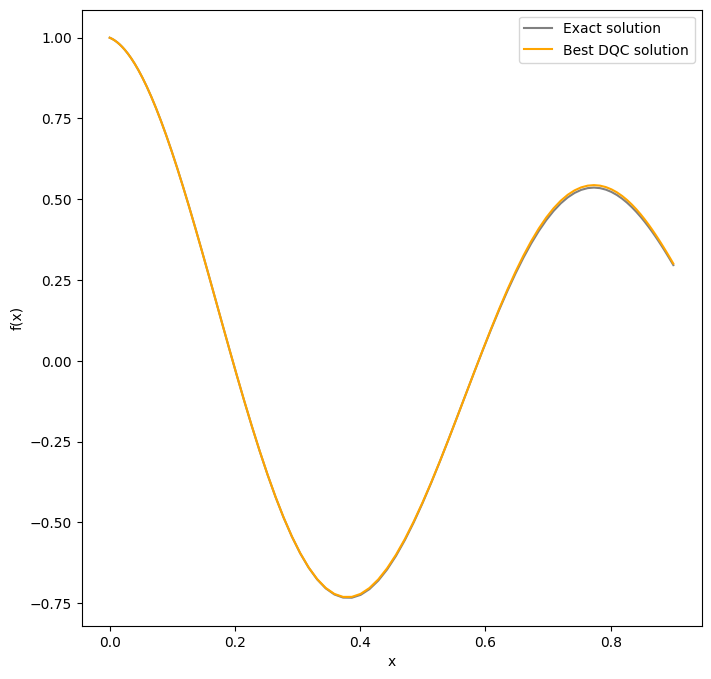

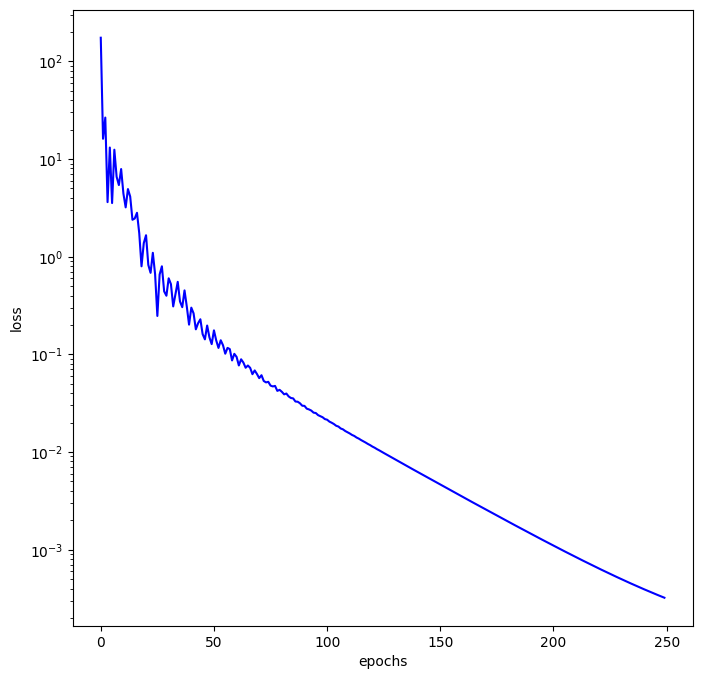


Top 10 indices (sorted by L_q): 
1. Index 3, L_f = 0.000322, L_q = 0.000019
2. Index 17, L_f = 0.003957, L_q = 0.000038
3. Index 29, L_f = 0.000218, L_q = 0.000045
4. Index 40, L_f = 0.001058, L_q = 0.000046
5. Index 6, L_f = 0.000322, L_q = 0.000064
6. Index 28, L_f = 0.001088, L_q = 0.000090
7. Index 46, L_f = 0.001207, L_q = 0.000127
8. Index 21, L_f = 0.000285, L_q = 0.000240
9. Index 30, L_f = 0.004544, L_q = 0.000270
10. Index 4, L_f = 0.005315, L_q = 0.000275


In [6]:
# Step 1: Collect all entries
all_entries = [(i, L_f[i], L_q[i]) for i in range(len(L_q))]

# Step 2: Sort by L_q only
top_10 = sorted(all_entries, key=lambda x: x[2])[:10]

# Step 3: Use the best one (lowest L_q) for plotting
best_index = top_10[0][0]
best_L_f = top_10[0][1]
best_L_q = top_10[0][2]
best_solution = all_functions[best_index]
best_loss = all_losses[best_index]

plt.figure(figsize=(8, 8))
plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data, best_solution.flatten(), color="orange", label="Best DQC solution")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.savefig("best_f_x.png")
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(best_loss, color="blue")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale('log')
plt.savefig("best_losses.png")
plt.show()

# Print top 10 indices
print("\nTop 10 indices (sorted by L_q): ")
for rank, (i, lf, lq) in enumerate(top_10, 1):
    print(f"{rank}. Index {i}, L_f = {lf:.6f}, L_q = {lq:.6f}")


### Mean solution

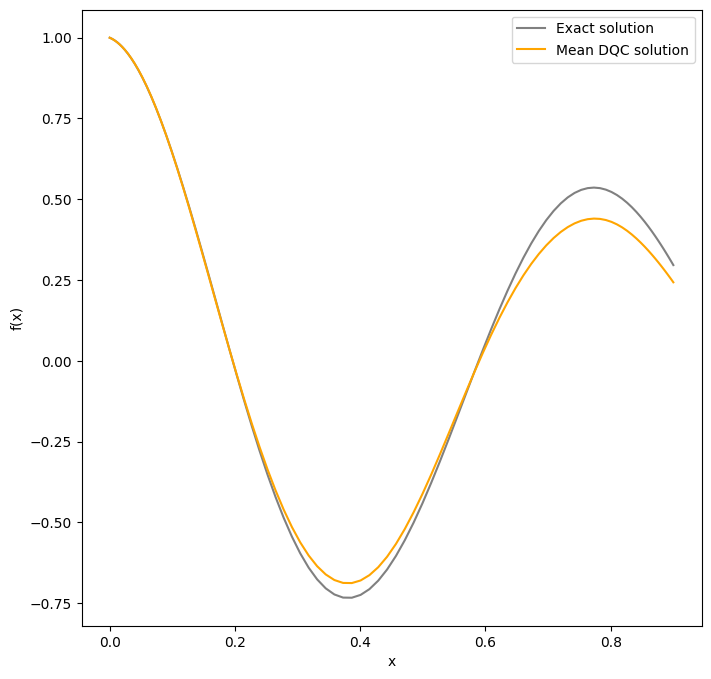

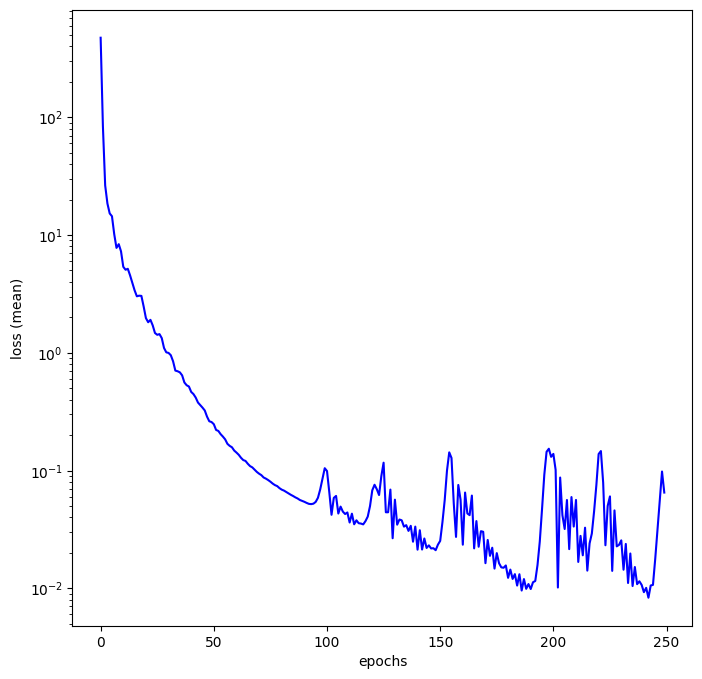

Preds std:  0.033921215249831306
Mean L_f:  0.0649705831325496
Mean L_q:  0.0035479718505667733


In [7]:
mean_loss = np.mean(all_losses, axis=0)
mean_solution = np.mean(all_functions, axis=0)
mean_L_f = np.mean(L_f, axis=0)
mean_L_q = np.mean(L_q, axis=0)

plt.figure(figsize=(8, 8))
plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data, mean_solution.flatten(), color="orange", label="Mean DQC solution")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.savefig("mean_f_x.png")
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(mean_loss, color="blue")
plt.xlabel("epochs")
plt.ylabel("loss (mean)")
plt.yscale('log')
plt.savefig("mean_losses.png")
plt.show()

print("Preds std: ",np.sqrt(np.mean(np.std(all_functions, axis=0)**2)))
print("Mean L_f: ",mean_L_f)
print("Mean L_q: ",mean_L_q)

### Stats

In [12]:
L_f_threshold = 10**(-1)
L_q_threshold = 10**(-2) #4
count = sum(1 for f, q in zip(L_f, L_q) if f < L_f_threshold and q < L_q_threshold)

print("Number of good solutions: ",count) 

Number of good solutions:  44


In [13]:
print("Number of good L_f: ",sum(1 for f in L_f if f < L_f_threshold)) 
print("Number of good L_q: ",sum(1 for q in L_q if q < L_q_threshold))

Number of good L_f:  49
Number of good L_q:  45
